# 环境准备和数据集下载

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# 数据增强和归一化
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [5]:
# 下载 CIFAR-10 训练集和测试集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

In [6]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=128,shuffle=False, num_workers=2)

# 类别标签
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 模型 v1

## CNN

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self, use_bn=True, pooling='max'):
        super(CustomCNN, self).__init__()
        self.use_bn = use_bn
        self.pooling = pooling

        def conv_block(in_channels, out_channels, kernel_size=3):
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            return nn.Sequential(*layers)

        self.features = nn.Sequential(
            conv_block(3, 64),
            self._get_pooling(),
            conv_block(64, 128),
            self._get_pooling(),
            conv_block(128, 256),
            self._get_pooling()
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def _get_pooling(self):
        if self.pooling == 'max':
            return nn.MaxPool2d(2)
        elif self.pooling == 'avg':
            return nn.AvgPool2d(2)
        elif self.pooling == 'none':
            return nn.Identity()
        else:
            raise ValueError(f"Unknown pooling type: {self.pooling}")

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## ResNet

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_bn=True, use_residual=True):
        super(BasicBlock, self).__init__()
        self.use_residual = use_residual
        self.bn = use_bn

        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)]
        if self.bn: layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))

        layers += [nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)]
        if self.bn: layers.append(nn.BatchNorm2d(out_channels))
        self.main_path = nn.Sequential(*layers)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels or stride != 1:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.main_path(x)
        if self.use_residual:
            out += self.shortcut(x)
        return self.relu(out)


In [ ]:
class CustomResNet(nn.Module):
    def __init__(self, use_bn=True, use_residual=True):
        super(CustomResNet, self).__init__()
        self.layer1 = BasicBlock(3, 64, use_bn=use_bn, use_residual=use_residual)
        self.layer2 = BasicBlock(64, 128, stride=2, use_bn=use_bn, use_residual=use_residual)
        self.layer3 = BasicBlock(128, 256, stride=2, use_bn=use_bn, use_residual=use_residual)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x).flatten(1)
        x = self.fc(x)
        return x


## VGG

In [ ]:
class CustomVGG(nn.Module):
    def __init__(self, cfg, num_classes=10, use_bn=True, pooling='max'):
        super(CustomVGG, self).__init__()
        self.features = self._make_layers(cfg, use_bn, pooling)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg, use_bn, pooling):
        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                if pooling == 'max':
                    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                elif pooling == 'avg':
                    layers += [nn.AvgPool2d(kernel_size=2, stride=2)]
                elif pooling == 'none':
                    layers += [nn.Identity()]
                else:
                    raise ValueError(f"Unsupported pooling: {pooling}")
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if use_bn:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        layers += [nn.AdaptiveAvgPool2d((1, 1))]
        return nn.Sequential(*layers)

vgg_cfg = [64, 'M', 128, 'M', 256, 'M', 512, 'M']


# 模型 v2

## CNN（4层卷积）

In [7]:
import torch
import torch.nn as nn

class CNN_v2(nn.Module):
    def __init__(self, use_bn=True, pooling='max', activation='relu', dropout_rate=0.0):
        super(CNN_v2, self).__init__()

        self.use_bn = use_bn
        self.pooling = pooling
        self.activation = activation
        self.dropout_rate = dropout_rate

        # 卷积层
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128) if use_bn else nn.Identity()

        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(256) if use_bn else nn.Identity()

        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512) if use_bn else nn.Identity()

        self.conv4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(1024) if use_bn else nn.Identity()

        # 激活函数
        if activation == 'relu':
            self.activation_fn = nn.ReLU()
        elif activation == 'leaky_relu':
            self.activation_fn = nn.LeakyReLU(negative_slope=0.01)
        elif activation == 'elu':
            self.activation_fn = nn.ELU()

        # 池化层
        if pooling == 'max':
            self.pooling_fn = nn.MaxPool2d(2)
        elif pooling == 'avg':
            self.pooling_fn = nn.AvgPool2d(2)
        elif pooling == 'none':
            self.pooling_fn = nn.Identity()

        # 自适应池化，确保输出为 (B, 1024, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Dropout
        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate > 0 else nn.Identity()

        # 全连接层
        self.fc1 = nn.Linear(1024, 4096)
        self.fc2 = nn.Linear(4096, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation_fn(x)
        x = self.pooling_fn(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.activation_fn(x)
        x = self.pooling_fn(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.activation_fn(x)
        x = self.pooling_fn(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.activation_fn(x)
        x = self.pooling_fn(x)

        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.fc2(x)
        return x


## VGG

In [8]:
import torch
import torch.nn as nn

class VGG_v2(nn.Module):
    def __init__(self, use_bn=True, pooling='max', activation='relu', dropout_rate1=0.0, dropout_rate2=0.0):
        super(VGG_v2, self).__init__()
        self.use_bn = use_bn
        self.pooling = pooling
        self.activation = activation

        assert activation in ['relu', 'leaky_relu', 'elu'], f"Unsupported activation: {activation}"
        assert pooling in ['max', 'avg', 'none'], f"Unsupported pooling: {pooling}"

        # VGG16结构
        cfg = [64,64,  'M',
               128, 128, 'M',
               256, 256,256, 'M',
               512, 512, 512,'M',
               512, 512, 512,'M']

        layers = []
        in_channels = 3
        for v in cfg:
            if v == 'M':
                if pooling == 'max':
                    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
                elif pooling == 'avg':
                    layers.append(nn.AvgPool2d(kernel_size=2, stride=2))
                elif pooling == 'none':
                    continue
            else:
                layers.append(nn.Conv2d(in_channels, v, kernel_size=3, padding=1))
                if use_bn:
                    layers.append(nn.BatchNorm2d(v))
                if activation == 'relu':
                    layers.append(nn.ReLU(inplace=True))
                elif activation == 'leaky_relu':
                    layers.append(nn.LeakyReLU(negative_slope=0.01))
                elif activation == 'elu':
                    layers.append(nn.ELU())
                in_channels = v

        self.features = nn.Sequential(*layers)

        # Dropout 层
        self.dropout1 = nn.Dropout(p=dropout_rate1) if dropout_rate1 > 0 else nn.Identity()
        self.dropout2 = nn.Dropout(p=dropout_rate2) if dropout_rate2 > 0 else nn.Identity()

        # 自适应池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # 全连接层
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)  # 可根据任务改分类数

        # 激活函数
        if activation == 'relu':
            self.activation_fn = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            self.activation_fn = nn.LeakyReLU(negative_slope=0.01)
        elif activation == 'elu':
            self.activation_fn = nn.ELU()

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.activation_fn(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.activation_fn(x)
        x = self.fc3(x)
        return x


## ResNet

In [9]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_bn=True, use_residual=True, activation='relu', dropout_rate=0.0, downsample=None):
        super(BasicBlock, self).__init__()
        self.use_residual = use_residual
        self.downsample = downsample

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=not use_bn)
        self.bn1 = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=not use_bn)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_bn else nn.Identity()
        self.dropout = nn.Dropout2d(p=dropout_rate) if dropout_rate > 0 else nn.Identity()

        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            self.activation = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            self.activation = nn.ELU(inplace=True)
        else:
            self.activation = nn.Identity()

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.use_residual:
            if self.downsample is not None:
                identity = self.downsample(x)
            out += identity

        out = self.activation(out)
        return out


class ResNet_v2(nn.Module):
    def __init__(self, num_classes=10, use_bn=True, use_residual=True, pooling='max', activation='relu', dropout_rate=0.0, fc_dropout_rate=0.0):
        super(ResNet_v2, self).__init__()
        self.use_bn = use_bn
        self.use_residual = use_residual

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=not use_bn)
        self.bn1 = nn.BatchNorm2d(64) if use_bn else nn.Identity()

        # 激活函数
        if activation == 'relu':
            act = nn.ReLU(inplace=True)
        elif activation == 'leaky_relu':
            act = nn.LeakyReLU(inplace=True)
        elif activation == 'elu':
            act = nn.ELU(inplace=True)
        else:
            act = nn.Identity()
        self.activation = act

        # 池化
        if pooling == 'max':
            pool = nn.MaxPool2d(2, 2)
        elif pooling == 'avg':
            pool = nn.AvgPool2d(2, 2)
        else:
            pool = nn.Identity()
        self.pool = pool

        # 残差层
        self.layer1 = nn.Sequential(
            BasicBlock(64, 64, 1, use_bn, use_residual, activation, dropout_rate),
            BasicBlock(64, 64, 1, use_bn, use_residual, activation, dropout_rate)
        )
        self.layer2 = nn.Sequential(
            BasicBlock(64, 128, 2, use_bn, use_residual, activation, dropout_rate,
                       downsample=nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=not use_bn)),
            BasicBlock(128, 128, 1, use_bn, use_residual, activation, dropout_rate)
        )
        self.layer3 = nn.Sequential(
            BasicBlock(128, 256, 2, use_bn, use_residual, activation, dropout_rate,
                       downsample=nn.Conv2d(128, 256, kernel_size=1, stride=2, bias=not use_bn)),
            BasicBlock(256, 256, 1, use_bn, use_residual, activation, dropout_rate)
        )
        self.layer4 = nn.Sequential(
            BasicBlock(256, 512, 2, use_bn, use_residual, activation, dropout_rate,
                       downsample=nn.Conv2d(256, 512, kernel_size=1, stride=2, bias=not use_bn)),
            BasicBlock(512, 512, 1, use_bn, use_residual, activation, dropout_rate)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_dropout = nn.Dropout(p=fc_dropout_rate) if fc_dropout_rate > 0 else nn.Identity()
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.activation(x)

        x = self.layer1(x)
        x = self.pool(x)
        x = self.layer2(x)
        x = self.pool(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc_dropout(x)
        x = self.fc(x)
        return x


### 绘制模型可视化图谱

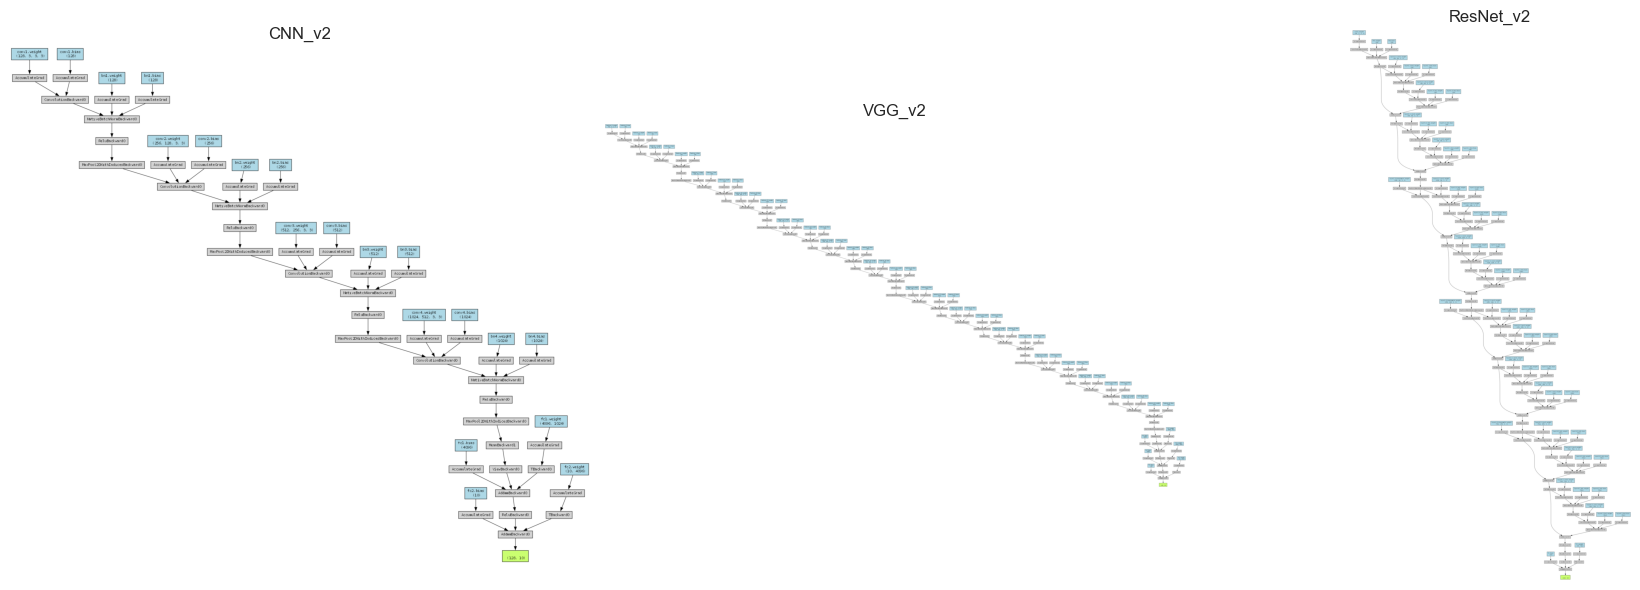

In [9]:
import torch
from torchviz import make_dot
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 创建模型实例
cnn_model = CNN_v2()
vgg_model = VGG_v2()
resnet_model = ResNet_v2()

# 模拟输入数据
input_tensor = torch.randn(128, 3, 32, 32)  

# 创建输出目录
output_dir = './results_v2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 绘制并保存 CNN_v2 的图
cnn_output = cnn_model(input_tensor)
cnn_dot = make_dot(cnn_output, params=dict(cnn_model.named_parameters()))
cnn_dot.render(os.path.join(output_dir, 'cnn_v2'), format='png')

# 绘制并保存 VGG_v2 的图
vgg_output = vgg_model(input_tensor)
vgg_dot = make_dot(vgg_output, params=dict(vgg_model.named_parameters()))
vgg_dot.render(os.path.join(output_dir, 'vgg_v2'), format='png')

# 绘制并保存 ResNet_v2 的图
resnet_output = resnet_model(input_tensor)
resnet_dot = make_dot(resnet_output, params=dict(resnet_model.named_parameters()))
resnet_dot.render(os.path.join(output_dir, 'resnet_v2'), format='png')

# 可视化显示三个模型图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 加载并显示 CNN_v2 图像
cnn_img = mpimg.imread(os.path.join(output_dir, 'cnn_v2.png'))
axes[0].imshow(cnn_img)
axes[0].axis('off')
axes[0].set_title('CNN_v2')

# 加载并显示 VGG_v2 图像
vgg_img = mpimg.imread(os.path.join(output_dir, 'vgg_v2.png'))
axes[1].imshow(vgg_img)
axes[1].axis('off')
axes[1].set_title('VGG_v2')

# 加载并显示 ResNet_v2 图像
resnet_img = mpimg.imread(os.path.join(output_dir, 'resnet_v2.png'))
axes[2].imshow(resnet_img)
axes[2].axis('off')
axes[2].set_title('ResNet_v2')

# 显示
plt.tight_layout()
plt.show()


# 训练和测试

In [10]:
import os
import csv
import copy
from tqdm import tqdm
import torch
import time

def train_model(model, trainloader, valloader, criterion,
        num_epochs, device, model_name, log_dir, model_dir,
        lr=0.01, momentum=0.9, weight_decay=5e-4,
        scheduler_patience=10, scheduler_factor=0.5):

    # 创建保存目录
    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    # 构建保存路径
    log_path = os.path.join(log_dir, f"{model_name}_log.csv")
    model_path = os.path.join(model_dir, f"{model_name}_best.pth")
    time_log_path = os.path.join(log_dir, "training_times.csv")

    model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 优化器 & 学习率调度器
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=scheduler_factor,patience=scheduler_patience)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # 初始化训练日志
    if not os.path.exists(log_path):
        with open(log_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Model', 'Epoch', 'Train Loss',
                    'Train Acc (%)', 'Val Loss',
                    'Val Acc (%)', 'Learning Rate'])

    # 记录训练起始时间
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # -------- Train --------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        train_bar = tqdm(trainloader, desc="Training", leave=False)

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # -------- Validate --------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_bar = tqdm(valloader, desc="Validating", leave=False)

        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_bar.set_postfix(loss=loss.item())

        val_loss /= val_total
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

        # -------- Save Best Model --------
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model_path)
            print(f"保存最佳模型路径: {model_path}")

        # -------- Append to CSV --------
        current_lr = optimizer.param_groups[0]['lr']
        with open(log_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                model_name, epoch+1,
                round(train_loss, 4), round(train_acc, 2),
                round(val_loss, 4), round(val_acc, 2),
                round(current_lr, 8)
            ])

        # -------- Update LR Scheduler --------
        scheduler.step(val_acc)
        print(f"当前学习率: {current_lr:.6f}")

    # -------- Load Best Weights --------
    model.load_state_dict(best_model_wts)

    # -------- 训练耗时记录 --------
    total_time = time.time() - start_time
    total_minutes = total_time / 60  # 转换为分钟
    print(f"训练时间 {model_name}: {total_minutes:.2f} 分钟")

    # -------- 写入时间日志文件（单位：分钟）--------
    if not os.path.exists(time_log_path):
        with open(time_log_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Model', 'Training Time (min)'])

    with open(time_log_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([model_name, round(total_minutes, 2)])


    return train_losses, val_losses, train_accuracies, val_accuracies

# 启动训练

## 模型处理 v1

In [ ]:
models = {
    "CNN_Baseline": CustomCNN(use_bn=True, pooling='max'),
    "CNN_No_BN": CustomCNN(use_bn=False, pooling='max'),
    "CNN_AvgPool": CustomCNN(use_bn=True, pooling='avg'),
    "CNN_No_BN_Avg": CustomCNN(use_bn=False, pooling='avg'),

    "ResNet_Baseline": CustomResNet(use_bn=True, use_residual=True),
    "ResNet_No_Res": CustomResNet(use_bn=True, use_residual=False),
    "ResNet_No_BN": CustomResNet(use_bn=False, use_residual=True),
    "ResNet_No_BN_No_Res": CustomResNet(use_bn=False, use_residual=False),

    "VGG_Baseline": CustomVGG(vgg_cfg, use_bn=True, pooling='max'),
    "VGG_No_BN": CustomVGG(vgg_cfg, use_bn=False, pooling='max'),
    "VGG_AvgPool": CustomVGG(vgg_cfg, use_bn=True, pooling='avg'),
    "VGG_NoPooling": CustomVGG(vgg_cfg, use_bn=True, pooling='none')
}

## 模型处理 v2

In [23]:
models_v2 = {

    #使用BN、最大池化、ReLU激活
    # "CNN_v2_Baseline": CNN_v2(use_bn=True, pooling='max', activation='relu', dropout_rate=0.0),
    # "CNN_v2_Dropout": CNN_v2(use_bn=True, pooling='max', activation='relu', dropout_rate=0.5), #带Dropout的

    # "CNN_v2_No_BN": CNN_v2(use_bn=False, pooling='max', activation='relu', dropout_rate=0.0), #无BN
    # "CNN_v2_AvgPool": CNN_v2(use_bn=True, pooling='avg', activation='relu', dropout_rate=0.0), #平均池化
    # "CNN_v2_No_BN_Avg": CNN_v2(use_bn=False, pooling='avg', activation='relu', dropout_rate=0.0), # 无BN的平均池化
    # "CNN_v2_NoPooling": CNN_v2(use_bn=True, pooling='none', activation='relu', dropout_rate=0.0), # 不使用池化

    # "CNN_v2_LeakyReLU": CNN_v2(use_bn=True, pooling='max', activation='leaky_relu', dropout_rate=0.0), #LeakyReLU激活
   # "CNN_v2_ELU": CNN_v2(use_bn=True, pooling='max', activation='elu', dropout_rate=0.0),  #ELU激活
    
    
    # === 基础配置 ===
    #"ResNet_v2_Baseline": ResNet_v2(use_bn=True,use_residual=True,pooling='max',activation='relu',dropout_rate=0.0,fc_dropout_rate=0.0),
    # "ResNet_v2_Dropout": ResNet_v2(use_bn=True,use_residual=True,pooling='max',activation='relu',dropout_rate=0.2,fc_dropout_rate=0.5),

    # === 消融实验 ===
    # 关闭残差
    # "ResNet_v2_No_Res": ResNet_v2(use_bn=True,use_residual=False,  pooling='max',activation='relu',dropout_rate=0.0,fc_dropout_rate=0.0),
    # 关闭BN
    # "ResNet_v2_No_BN": ResNet_v2(use_bn=False,  use_residual=True,pooling='max',activation='relu',dropout_rate=0.0,fc_dropout_rate=0.0),
    # "ResNet_v2_No_BN_No_Res": ResNet_v2(use_bn=False,use_residual=False,pooling='max',activation='relu',dropout_rate=0.0,fc_dropout_rate=0.0),
    # 
    # # === 池化对比 ===
    # # 平均池化
    # "ResNet_v2_AvgPool": ResNet_v2(use_bn=True,use_residual=True,pooling='avg', activation='relu',dropout_rate=0.0,fc_dropout_rate=0.0),
    # "ResNet_v2_No_BN_AvgPool": ResNet_v2(use_bn=False,use_residual=True,pooling='avg',activation='relu',dropout_rate=0.0,fc_dropout_rate=0.0),
    # # 无池化
    # "ResNet_v2_No_Pool": ResNet_v2(use_bn=True,use_residual=True,pooling='none',  activation='relu',dropout_rate=0.0,fc_dropout_rate=0.0),
    # # === 激活函数对比 ===
    # # LeakyReLU
    # "ResNet_v2_LeakyReLU": ResNet_v2(use_bn=True,use_residual=True,pooling='max',activation='leaky_relu',  dropout_rate=0.0,fc_dropout_rate=0.0),
    # # ELU
    # "ResNet_v2_ELU": ResNet_v2(use_bn=True,use_residual=True,pooling='max',activation='elu',  dropout_rate=0.0,fc_dropout_rate=0.0),
    

    # 使用BN、最大池化、ReLU激活
    # "VGG_v2_Baseline": VGG_v2( use_bn=True, pooling='max', activation='relu', dropout_rate1=0.0, dropout_rate2=0.0),
    # # 带Dropout
    # "VGG_v2_Dropout": VGG_v2( use_bn=True, pooling='max', activation='relu', dropout_rate1=0.2, dropout_rate2=0.5),
    # # 使用LeakyReLU激活
    # "VGG_v2_LeakyReLU": VGG_v2( use_bn=True, pooling='max', activation='leaky_relu', dropout_rate1=0.0, dropout_rate2=0.0),
    # # 使用ELU激活
    # "VGG_v2_ELU": VGG_v2( use_bn=True, pooling='max', activation='elu', dropout_rate1=0.0, dropout_rate2=0.0),
    # 使用平均池化
    # "VGG_v2_AvgPool": VGG_v2( use_bn=True, pooling='avg', activation='relu', dropout_rate1=0.0, dropout_rate2=0.0),
    
   
}

## 融合组件

In [11]:
models_fusion={
    
    # # === 多组件融合 · CNN_v2 ===
    # # 使用 LeakyReLU + AvgPool + Dropout + BN（融合三个模块）
    # "CNN_v2_Leaky_AvgPool_Dropout": CNN_v2(
    #     use_bn=True,
    #     pooling='avg',
    #     activation='leaky_relu',
    #     dropout_rate=0.5
    # ),
    # 
    # # 去除 BN + 使用 ELU 激活 + Dropout（极端配置）
    # "CNN_v2_NoBN_ELU_Dropout": CNN_v2(
    #     use_bn=False,
    #     pooling='max',
    #     activation='elu',
    #     dropout_rate=0.5
    # ),
    # 
    # # === 多组件融合 · ResNet_v2 ===
    # # LeakyReLU 激活 + AvgPool + Dropout + BN（融合三个模块）
    # "ResNet_v2_Leaky_AvgPool_Dropout": ResNet_v2(
    #     use_bn=True,
    #     use_residual=True,
    #     pooling='avg',
    #     activation='leaky_relu',
    #     dropout_rate=0.2,
    #     fc_dropout_rate=0.5
    # ),
    # 
    # # 去除 BN + 使用 ELU 激活 + Dropout（深层极限配置）
    # "ResNet_v2_NoBN_ELU_Dropout": ResNet_v2(
    #     use_bn=False,
    #     use_residual=True,
    #     pooling='max',
    #     activation='elu',
    #     dropout_rate=0.2,
    #     fc_dropout_rate=0.5
    # ),
    # 
    # # === 多组件融合 · VGG_v2 ===
    # 
    # # 使用 LeakyReLU 激活 + AvgPool + 双Dropout（融合三个模块）
    # "VGG_v2_Leaky_AvgPool_Dropout": VGG_v2(
    #     use_bn=True,
    #     pooling='avg',
    #     activation='leaky_relu',
    #     dropout_rate1=0.2,
    #     dropout_rate2=0.5
    # ),

    # 使用 ELU 激活 + 双Dropout（融合 Dropout + 激活函数）
    "VGG_v2_ELU_Dropout": VGG_v2(
        use_bn=True,
        pooling='max',
        activation='elu',
        dropout_rate1=0.2,
        dropout_rate2=0.5
    ),
   
}

## 训练和模型复杂度分析

In [12]:
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("使用设备：", device)

使用设备： cuda


### 复杂度分析

In [13]:
from thop import profile
from thop import clever_format

In [14]:
def analyze_model_complexity(model, input_size=(3, 32, 32), device='cpu'):
    model_copy = copy.deepcopy(model).to(device)
    model_copy.eval()
    dummy_input = torch.randn(1, *input_size).to(device)

    macs, params = profile(model_copy, inputs=(dummy_input,), verbose=False)
    macs, params = clever_format([macs, params], "%.3f")

    return macs, params


### v1

In [ ]:
log_dir = "./logs"
model_dir = "./models"

In [ ]:
for name, model in models.items():
    print(f"\nTraining model: {name}")
    macs, params = analyze_model_complexity(model, device=device)
    print(f"模型 {name} 参数量: {params}, FLOPs: {macs}")

    # 保存模型复杂度到日志 CSV
    with open(os.path.join('./logs', 'model_complexity.csv'), 'a', newline='') as f:
        writer = csv.writer(f)
        if f.tell() == 0:
            writer.writerow(['Model', 'Params', 'FLOPs'])
        writer.writerow([name, params, macs])

    train_model(
        model=model,
        trainloader=train_loader,
        valloader=test_loader,
        criterion=criterion,
        num_epochs=80,
        device=device,
        model_name=name,
        log_dir=log_dir,
        model_dir=model_dir,
        
    )


### v2

In [25]:
log_dir = "./logs_v2"
model_dir = "./models_v2"

In [26]:
for name, model in models_v2.items():
    print(f"\nTraining model: {name}")
    macs, params = analyze_model_complexity(model, device=device)
    print(f"模型 {name} 参数量: {params}, FLOPs: {macs}")

    # 保存模型复杂度到日志 CSV
    with open(os.path.join(log_dir, 'model_complexity.csv'), 'a', newline='') as f:
        writer = csv.writer(f)
        if f.tell() == 0:
            writer.writerow(['Model', 'Params', 'FLOPs'])
        writer.writerow([name, params, macs])

    train_model(
        model=model,
        trainloader=train_loader,
        valloader=test_loader,
        criterion=criterion,
        num_epochs=120,
        device=device,
        model_name=name,
        log_dir=log_dir,
        model_dir=model_dir,
    )


Training model: ResNet_v2_Baseline
模型 ResNet_v2_Baseline 参数量: 11.172M, FLOPs: 204.569M

Epoch 1/120


Train Loss: 1.4555, Acc: 47.02% | Val Loss: 1.3607, Acc: 52.50%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 2/120


Train Loss: 1.0163, Acc: 64.01% | Val Loss: 0.8760, Acc: 68.75%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 3/120


Train Loss: 0.8193, Acc: 71.02% | Val Loss: 0.7932, Acc: 71.60%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 4/120


Train Loss: 0.7149, Acc: 74.93% | Val Loss: 0.7420, Acc: 73.88%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 5/120


Train Loss: 0.6307, Acc: 77.99% | Val Loss: 0.7452, Acc: 74.44%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 6/120


Train Loss: 0.5785, Acc: 79.92% | Val Loss: 0.7219, Acc: 75.91%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 7/120


Train Loss: 0.5263, Acc: 81.75% | Val Loss: 0.6495, Acc: 78.42%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 8/120


Train Loss: 0.4913, Acc: 82.86% | Val Loss: 0.5516, Acc: 81.24%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 9/120


Train Loss: 0.4584, Acc: 84.10% | Val Loss: 0.5954, Acc: 79.80%
当前学习率: 0.010000

Epoch 10/120


Train Loss: 0.4337, Acc: 85.00% | Val Loss: 0.5713, Acc: 81.02%
当前学习率: 0.010000

Epoch 11/120


Train Loss: 0.4043, Acc: 85.91% | Val Loss: 0.5249, Acc: 82.33%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 12/120


Train Loss: 0.3817, Acc: 86.69% | Val Loss: 0.5394, Acc: 81.99%
当前学习率: 0.010000

Epoch 13/120


Train Loss: 0.3628, Acc: 87.37% | Val Loss: 0.5083, Acc: 83.16%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 14/120


Train Loss: 0.3469, Acc: 88.04% | Val Loss: 0.4694, Acc: 83.75%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 15/120


Train Loss: 0.3374, Acc: 88.16% | Val Loss: 0.4529, Acc: 84.36%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 16/120


Train Loss: 0.3164, Acc: 88.97% | Val Loss: 0.4604, Acc: 84.26%
当前学习率: 0.010000

Epoch 17/120


Train Loss: 0.3038, Acc: 89.56% | Val Loss: 0.4673, Acc: 84.72%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 18/120


Train Loss: 0.2924, Acc: 89.71% | Val Loss: 0.4528, Acc: 84.93%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 19/120


Train Loss: 0.2782, Acc: 90.26% | Val Loss: 0.4269, Acc: 85.58%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 20/120


Train Loss: 0.2657, Acc: 90.69% | Val Loss: 0.4480, Acc: 84.96%
当前学习率: 0.010000

Epoch 21/120


Train Loss: 0.2629, Acc: 90.82% | Val Loss: 0.4854, Acc: 84.02%
当前学习率: 0.010000

Epoch 22/120


Train Loss: 0.2488, Acc: 91.32% | Val Loss: 0.4438, Acc: 85.46%
当前学习率: 0.010000

Epoch 23/120


Train Loss: 0.2380, Acc: 91.76% | Val Loss: 0.4445, Acc: 85.86%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 24/120


Train Loss: 0.2328, Acc: 91.87% | Val Loss: 0.4298, Acc: 85.66%
当前学习率: 0.010000

Epoch 25/120


Train Loss: 0.2244, Acc: 92.24% | Val Loss: 0.3966, Acc: 86.83%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 26/120


Train Loss: 0.2180, Acc: 92.37% | Val Loss: 0.4131, Acc: 86.41%
当前学习率: 0.010000

Epoch 27/120


Train Loss: 0.2172, Acc: 92.37% | Val Loss: 0.3817, Acc: 87.55%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 28/120


Train Loss: 0.2040, Acc: 92.80% | Val Loss: 0.3942, Acc: 87.15%
当前学习率: 0.010000

Epoch 29/120


Train Loss: 0.2018, Acc: 92.87% | Val Loss: 0.4599, Acc: 85.56%
当前学习率: 0.010000

Epoch 30/120


Train Loss: 0.1966, Acc: 93.13% | Val Loss: 0.4430, Acc: 85.97%
当前学习率: 0.010000

Epoch 31/120


Train Loss: 0.1851, Acc: 93.59% | Val Loss: 0.4121, Acc: 86.95%
当前学习率: 0.010000

Epoch 32/120


Train Loss: 0.1831, Acc: 93.52% | Val Loss: 0.4036, Acc: 87.09%
当前学习率: 0.010000

Epoch 33/120


Train Loss: 0.1812, Acc: 93.56% | Val Loss: 0.4124, Acc: 87.22%
当前学习率: 0.010000

Epoch 34/120


Train Loss: 0.1784, Acc: 93.72% | Val Loss: 0.3966, Acc: 87.43%
当前学习率: 0.010000

Epoch 35/120


Train Loss: 0.1763, Acc: 93.83% | Val Loss: 0.3799, Acc: 87.91%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 36/120


Train Loss: 0.1639, Acc: 94.19% | Val Loss: 0.4115, Acc: 87.27%
当前学习率: 0.010000

Epoch 37/120


Train Loss: 0.1609, Acc: 94.32% | Val Loss: 0.4433, Acc: 86.71%
当前学习率: 0.010000

Epoch 38/120


Train Loss: 0.1618, Acc: 94.19% | Val Loss: 0.3942, Acc: 87.86%
当前学习率: 0.010000

Epoch 39/120


Train Loss: 0.1546, Acc: 94.41% | Val Loss: 0.4890, Acc: 85.41%
当前学习率: 0.010000

Epoch 40/120


Train Loss: 0.1528, Acc: 94.63% | Val Loss: 0.3933, Acc: 87.63%
当前学习率: 0.010000

Epoch 41/120


Train Loss: 0.1499, Acc: 94.66% | Val Loss: 0.4128, Acc: 87.51%
当前学习率: 0.010000

Epoch 42/120


Train Loss: 0.1469, Acc: 94.82% | Val Loss: 0.3946, Acc: 88.10%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 43/120


Train Loss: 0.1446, Acc: 94.82% | Val Loss: 0.3717, Acc: 88.59%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 44/120


Train Loss: 0.1418, Acc: 95.10% | Val Loss: 0.3888, Acc: 87.98%
当前学习率: 0.010000

Epoch 45/120


Train Loss: 0.1386, Acc: 95.16% | Val Loss: 0.3763, Acc: 88.64%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.010000

Epoch 46/120


Train Loss: 0.1309, Acc: 95.35% | Val Loss: 0.3935, Acc: 87.86%
当前学习率: 0.010000

Epoch 47/120


Train Loss: 0.1334, Acc: 95.28% | Val Loss: 0.3841, Acc: 88.34%
当前学习率: 0.010000

Epoch 48/120


Train Loss: 0.1358, Acc: 95.15% | Val Loss: 0.3941, Acc: 88.17%
当前学习率: 0.010000

Epoch 49/120


Train Loss: 0.1314, Acc: 95.36% | Val Loss: 0.3973, Acc: 87.53%
当前学习率: 0.010000

Epoch 50/120


Train Loss: 0.1278, Acc: 95.57% | Val Loss: 0.3798, Acc: 88.18%
当前学习率: 0.010000

Epoch 51/120


Train Loss: 0.1277, Acc: 95.55% | Val Loss: 0.3770, Acc: 88.57%
当前学习率: 0.010000

Epoch 52/120


Train Loss: 0.1248, Acc: 95.53% | Val Loss: 0.4428, Acc: 86.69%
当前学习率: 0.010000

Epoch 53/120


Train Loss: 0.1244, Acc: 95.63% | Val Loss: 0.4024, Acc: 87.98%
当前学习率: 0.010000

Epoch 54/120


Train Loss: 0.1240, Acc: 95.68% | Val Loss: 0.4332, Acc: 87.45%
当前学习率: 0.010000

Epoch 55/120


Train Loss: 0.1225, Acc: 95.69% | Val Loss: 0.4027, Acc: 88.40%
当前学习率: 0.010000

Epoch 56/120


Train Loss: 0.1213, Acc: 95.80% | Val Loss: 0.4095, Acc: 87.44%
当前学习率: 0.010000

Epoch 57/120


Train Loss: 0.0764, Acc: 97.32% | Val Loss: 0.3524, Acc: 89.96%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.005000

Epoch 58/120


Train Loss: 0.0598, Acc: 97.92% | Val Loss: 0.3663, Acc: 89.92%
当前学习率: 0.005000

Epoch 59/120


Train Loss: 0.0588, Acc: 97.94% | Val Loss: 0.3736, Acc: 89.96%
当前学习率: 0.005000

Epoch 60/120


Train Loss: 0.0553, Acc: 98.11% | Val Loss: 0.3741, Acc: 90.29%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.005000

Epoch 61/120


Train Loss: 0.0531, Acc: 98.17% | Val Loss: 0.3832, Acc: 89.80%
当前学习率: 0.005000

Epoch 62/120


Train Loss: 0.0531, Acc: 98.11% | Val Loss: 0.3613, Acc: 90.29%
当前学习率: 0.005000

Epoch 63/120


Train Loss: 0.0517, Acc: 98.21% | Val Loss: 0.3762, Acc: 90.29%
当前学习率: 0.005000

Epoch 64/120


Train Loss: 0.0528, Acc: 98.09% | Val Loss: 0.3580, Acc: 90.18%
当前学习率: 0.005000

Epoch 65/120


Train Loss: 0.0484, Acc: 98.29% | Val Loss: 0.3975, Acc: 89.82%
当前学习率: 0.005000

Epoch 66/120


Train Loss: 0.0494, Acc: 98.31% | Val Loss: 0.3729, Acc: 90.03%
当前学习率: 0.005000

Epoch 67/120


Train Loss: 0.0510, Acc: 98.19% | Val Loss: 0.4088, Acc: 89.49%
当前学习率: 0.005000

Epoch 68/120


Train Loss: 0.0480, Acc: 98.33% | Val Loss: 0.3998, Acc: 89.75%
当前学习率: 0.005000

Epoch 69/120


Train Loss: 0.0463, Acc: 98.39% | Val Loss: 0.4017, Acc: 89.87%
当前学习率: 0.005000

Epoch 70/120


Train Loss: 0.0519, Acc: 98.21% | Val Loss: 0.3913, Acc: 89.71%
当前学习率: 0.005000

Epoch 71/120


Train Loss: 0.0496, Acc: 98.23% | Val Loss: 0.3857, Acc: 90.14%
当前学习率: 0.005000

Epoch 72/120


Train Loss: 0.0321, Acc: 98.92% | Val Loss: 0.3734, Acc: 90.55%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.002500

Epoch 73/120


Train Loss: 0.0242, Acc: 99.19% | Val Loss: 0.3717, Acc: 90.99%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.002500

Epoch 74/120


Train Loss: 0.0224, Acc: 99.27% | Val Loss: 0.3806, Acc: 90.82%
当前学习率: 0.002500

Epoch 75/120


Train Loss: 0.0209, Acc: 99.30% | Val Loss: 0.3825, Acc: 90.90%
当前学习率: 0.002500

Epoch 76/120


Train Loss: 0.0198, Acc: 99.37% | Val Loss: 0.3847, Acc: 90.98%
当前学习率: 0.002500

Epoch 77/120


Train Loss: 0.0181, Acc: 99.41% | Val Loss: 0.3855, Acc: 90.92%
当前学习率: 0.002500

Epoch 78/120


Train Loss: 0.0192, Acc: 99.36% | Val Loss: 0.3890, Acc: 90.88%
当前学习率: 0.002500

Epoch 79/120


Train Loss: 0.0181, Acc: 99.37% | Val Loss: 0.3940, Acc: 90.91%
当前学习率: 0.002500

Epoch 80/120


Train Loss: 0.0194, Acc: 99.35% | Val Loss: 0.3950, Acc: 91.01%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.002500

Epoch 81/120


Train Loss: 0.0181, Acc: 99.41% | Val Loss: 0.3725, Acc: 91.28%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.002500

Epoch 82/120


Train Loss: 0.0161, Acc: 99.46% | Val Loss: 0.3816, Acc: 91.43%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.002500

Epoch 83/120


Train Loss: 0.0164, Acc: 99.45% | Val Loss: 0.3796, Acc: 91.27%
当前学习率: 0.002500

Epoch 84/120


Train Loss: 0.0167, Acc: 99.46% | Val Loss: 0.4083, Acc: 90.54%
当前学习率: 0.002500

Epoch 85/120


Train Loss: 0.0184, Acc: 99.37% | Val Loss: 0.3861, Acc: 91.26%
当前学习率: 0.002500

Epoch 86/120


Train Loss: 0.0175, Acc: 99.45% | Val Loss: 0.4017, Acc: 90.93%
当前学习率: 0.002500

Epoch 87/120


Train Loss: 0.0161, Acc: 99.46% | Val Loss: 0.3855, Acc: 91.08%
当前学习率: 0.002500

Epoch 88/120


Train Loss: 0.0149, Acc: 99.53% | Val Loss: 0.3811, Acc: 91.12%
当前学习率: 0.002500

Epoch 89/120


Train Loss: 0.0140, Acc: 99.56% | Val Loss: 0.4034, Acc: 90.93%
当前学习率: 0.002500

Epoch 90/120


Train Loss: 0.0148, Acc: 99.54% | Val Loss: 0.3988, Acc: 91.00%
当前学习率: 0.002500

Epoch 91/120


Train Loss: 0.0161, Acc: 99.46% | Val Loss: 0.4049, Acc: 90.87%
当前学习率: 0.002500

Epoch 92/120


Train Loss: 0.0172, Acc: 99.41% | Val Loss: 0.4314, Acc: 90.36%
当前学习率: 0.002500

Epoch 93/120


Train Loss: 0.0167, Acc: 99.43% | Val Loss: 0.4104, Acc: 90.92%
当前学习率: 0.002500

Epoch 94/120


Train Loss: 0.0125, Acc: 99.60% | Val Loss: 0.3675, Acc: 91.50%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.001250

Epoch 95/120


Train Loss: 0.0099, Acc: 99.67% | Val Loss: 0.3671, Acc: 91.50%
当前学习率: 0.001250

Epoch 96/120


Train Loss: 0.0090, Acc: 99.74% | Val Loss: 0.3756, Acc: 91.36%
当前学习率: 0.001250

Epoch 97/120


Train Loss: 0.0084, Acc: 99.74% | Val Loss: 0.3859, Acc: 91.66%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.001250

Epoch 98/120


Train Loss: 0.0082, Acc: 99.72% | Val Loss: 0.4022, Acc: 91.24%
当前学习率: 0.001250

Epoch 99/120


Train Loss: 0.0078, Acc: 99.78% | Val Loss: 0.3826, Acc: 91.50%
当前学习率: 0.001250

Epoch 100/120


Train Loss: 0.0080, Acc: 99.76% | Val Loss: 0.3965, Acc: 91.28%
当前学习率: 0.001250

Epoch 101/120


Train Loss: 0.0078, Acc: 99.74% | Val Loss: 0.3880, Acc: 91.11%
当前学习率: 0.001250

Epoch 102/120


Train Loss: 0.0071, Acc: 99.79% | Val Loss: 0.3916, Acc: 91.25%
当前学习率: 0.001250

Epoch 103/120


Train Loss: 0.0072, Acc: 99.77% | Val Loss: 0.3873, Acc: 91.46%
当前学习率: 0.001250

Epoch 104/120


Train Loss: 0.0072, Acc: 99.78% | Val Loss: 0.3777, Acc: 91.53%
当前学习率: 0.001250

Epoch 105/120


Train Loss: 0.0074, Acc: 99.76% | Val Loss: 0.3892, Acc: 91.43%
当前学习率: 0.001250

Epoch 106/120


Train Loss: 0.0060, Acc: 99.84% | Val Loss: 0.3854, Acc: 91.75%
保存最佳模型路径: ./models_v2\ResNet_v2_Baseline_best.pth
当前学习率: 0.001250

Epoch 107/120


Train Loss: 0.0060, Acc: 99.84% | Val Loss: 0.3757, Acc: 91.54%
当前学习率: 0.001250

Epoch 108/120


Train Loss: 0.0069, Acc: 99.80% | Val Loss: 0.3856, Acc: 91.58%
当前学习率: 0.001250

Epoch 109/120


Train Loss: 0.0056, Acc: 99.84% | Val Loss: 0.3942, Acc: 91.48%
当前学习率: 0.001250

Epoch 110/120


Train Loss: 0.0061, Acc: 99.82% | Val Loss: 0.3810, Acc: 91.65%
当前学习率: 0.001250

Epoch 111/120


Train Loss: 0.0066, Acc: 99.80% | Val Loss: 0.4012, Acc: 91.22%
当前学习率: 0.001250

Epoch 112/120


Train Loss: 0.0058, Acc: 99.82% | Val Loss: 0.3892, Acc: 91.55%
当前学习率: 0.001250

Epoch 113/120


Train Loss: 0.0053, Acc: 99.86% | Val Loss: 0.3940, Acc: 91.67%
当前学习率: 0.001250

Epoch 114/120


Train Loss: 0.0060, Acc: 99.82% | Val Loss: 0.4114, Acc: 91.17%
当前学习率: 0.001250

Epoch 115/120


Train Loss: 0.0054, Acc: 99.85% | Val Loss: 0.4073, Acc: 91.48%
当前学习率: 0.001250

Epoch 116/120


Train Loss: 0.0047, Acc: 99.87% | Val Loss: 0.3909, Acc: 91.60%
当前学习率: 0.001250

Epoch 117/120


Train Loss: 0.0055, Acc: 99.84% | Val Loss: 0.3948, Acc: 91.54%
当前学习率: 0.001250

Epoch 118/120


Train Loss: 0.0047, Acc: 99.86% | Val Loss: 0.3909, Acc: 91.66%
当前学习率: 0.000625

Epoch 119/120


Train Loss: 0.0044, Acc: 99.88% | Val Loss: 0.3946, Acc: 91.70%
当前学习率: 0.000625

Epoch 120/120


Train Loss: 0.0046, Acc: 99.86% | Val Loss: 0.3925, Acc: 91.61%
当前学习率: 0.000625
训练时间 ResNet_v2_Baseline: 76.55 分钟


### fusion

In [15]:
log_dir = "./logs_fusion"
model_dir = "./models_fusion"

In [16]:
for name, model in models_fusion.items():
    print(f"\nTraining model: {name}")
    macs, params = analyze_model_complexity(model, device=device)
    print(f"模型 {name} 参数量: {params}, FLOPs: {macs}")

    # 保存模型复杂度到日志 CSV
    with open(os.path.join(log_dir, 'model_complexity.csv'), 'a', newline='') as f:
        writer = csv.writer(f)
        if f.tell() == 0:
            writer.writerow(['Model', 'Params', 'FLOPs'])
        writer.writerow([name, params, macs])

    train_model(
        model=model,
        trainloader=train_loader,
        valloader=test_loader,
        criterion=criterion,
        num_epochs=120,
        device=device,
        model_name=name,
        log_dir=log_dir,
        model_dir=model_dir,
    )


Training model: VGG_v2_ELU_Dropout
模型 VGG_v2_ELU_Dropout 参数量: 33.647M, FLOPs: 333.219M

Epoch 1/120


Train Loss: 1.4301, Acc: 47.83% | Val Loss: 1.2544, Acc: 55.64%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 2/120


Train Loss: 0.9693, Acc: 65.97% | Val Loss: 0.9283, Acc: 68.52%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 3/120


Train Loss: 0.8146, Acc: 71.47% | Val Loss: 0.7733, Acc: 73.38%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 4/120


Train Loss: 0.7195, Acc: 75.08% | Val Loss: 0.7340, Acc: 74.70%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 5/120


Train Loss: 0.6557, Acc: 77.37% | Val Loss: 0.7237, Acc: 75.57%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 6/120


Train Loss: 0.6144, Acc: 78.98% | Val Loss: 0.6996, Acc: 76.54%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 7/120


Train Loss: 0.5710, Acc: 80.27% | Val Loss: 0.6137, Acc: 79.12%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 8/120


Train Loss: 0.5359, Acc: 81.61% | Val Loss: 0.6364, Acc: 78.78%
当前学习率: 0.010000

Epoch 9/120


Train Loss: 0.5120, Acc: 82.22% | Val Loss: 0.5744, Acc: 80.28%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 10/120


Train Loss: 0.4887, Acc: 83.26% | Val Loss: 0.5559, Acc: 80.98%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 11/120


Train Loss: 0.4684, Acc: 83.96% | Val Loss: 0.5858, Acc: 80.18%
当前学习率: 0.010000

Epoch 12/120


Train Loss: 0.4534, Acc: 84.40% | Val Loss: 0.5383, Acc: 81.55%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 13/120


Train Loss: 0.4318, Acc: 84.98% | Val Loss: 0.5540, Acc: 81.68%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 14/120


Train Loss: 0.4194, Acc: 85.66% | Val Loss: 0.5302, Acc: 82.32%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 15/120


Train Loss: 0.4059, Acc: 86.12% | Val Loss: 0.4880, Acc: 83.16%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 16/120


Train Loss: 0.3900, Acc: 86.73% | Val Loss: 0.5299, Acc: 82.90%
当前学习率: 0.010000

Epoch 17/120


Train Loss: 0.3827, Acc: 86.72% | Val Loss: 0.4843, Acc: 83.90%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 18/120


Train Loss: 0.3703, Acc: 87.07% | Val Loss: 0.4888, Acc: 83.42%
当前学习率: 0.010000

Epoch 19/120


Train Loss: 0.3642, Acc: 87.56% | Val Loss: 0.4716, Acc: 84.00%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 20/120


Train Loss: 0.3521, Acc: 87.85% | Val Loss: 0.4882, Acc: 83.56%
当前学习率: 0.010000

Epoch 21/120


Train Loss: 0.3429, Acc: 88.02% | Val Loss: 0.4526, Acc: 84.80%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 22/120


Train Loss: 0.3400, Acc: 88.37% | Val Loss: 0.4357, Acc: 85.30%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 23/120


Train Loss: 0.3280, Acc: 88.67% | Val Loss: 0.4742, Acc: 84.41%
当前学习率: 0.010000

Epoch 24/120


Train Loss: 0.3172, Acc: 89.02% | Val Loss: 0.4727, Acc: 84.44%
当前学习率: 0.010000

Epoch 25/120


Train Loss: 0.3211, Acc: 88.85% | Val Loss: 0.4631, Acc: 84.48%
当前学习率: 0.010000

Epoch 26/120


Train Loss: 0.3071, Acc: 89.32% | Val Loss: 0.4266, Acc: 85.87%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 27/120


Train Loss: 0.3043, Acc: 89.57% | Val Loss: 0.4660, Acc: 84.52%
当前学习率: 0.010000

Epoch 28/120


Train Loss: 0.3011, Acc: 89.63% | Val Loss: 0.4514, Acc: 85.04%
当前学习率: 0.010000

Epoch 29/120


Train Loss: 0.2971, Acc: 89.64% | Val Loss: 0.4111, Acc: 85.97%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 30/120


Train Loss: 0.2925, Acc: 89.86% | Val Loss: 0.4329, Acc: 85.59%
当前学习率: 0.010000

Epoch 31/120


Train Loss: 0.2859, Acc: 90.02% | Val Loss: 0.4870, Acc: 84.12%
当前学习率: 0.010000

Epoch 32/120


Train Loss: 0.2827, Acc: 90.30% | Val Loss: 0.4452, Acc: 85.30%
当前学习率: 0.010000

Epoch 33/120


Train Loss: 0.2796, Acc: 90.13% | Val Loss: 0.4370, Acc: 85.33%
当前学习率: 0.010000

Epoch 34/120


Train Loss: 0.2758, Acc: 90.53% | Val Loss: 0.4278, Acc: 85.81%
当前学习率: 0.010000

Epoch 35/120


Train Loss: 0.2733, Acc: 90.47% | Val Loss: 0.4528, Acc: 84.93%
当前学习率: 0.010000

Epoch 36/120


Train Loss: 0.2706, Acc: 90.66% | Val Loss: 0.4298, Acc: 85.67%
当前学习率: 0.010000

Epoch 37/120


Train Loss: 0.2645, Acc: 90.81% | Val Loss: 0.4181, Acc: 86.46%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 38/120


Train Loss: 0.2615, Acc: 90.95% | Val Loss: 0.4126, Acc: 86.32%
当前学习率: 0.010000

Epoch 39/120


Train Loss: 0.2576, Acc: 91.07% | Val Loss: 0.4146, Acc: 86.60%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 40/120


Train Loss: 0.2505, Acc: 91.26% | Val Loss: 0.4460, Acc: 85.64%
当前学习率: 0.010000

Epoch 41/120


Train Loss: 0.2546, Acc: 91.13% | Val Loss: 0.4105, Acc: 86.31%
当前学习率: 0.010000

Epoch 42/120


Train Loss: 0.2506, Acc: 91.34% | Val Loss: 0.3895, Acc: 87.02%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.010000

Epoch 43/120


Train Loss: 0.2480, Acc: 91.39% | Val Loss: 0.4311, Acc: 85.94%
当前学习率: 0.010000

Epoch 44/120


Train Loss: 0.2438, Acc: 91.48% | Val Loss: 0.3982, Acc: 86.75%
当前学习率: 0.010000

Epoch 45/120


Train Loss: 0.2458, Acc: 91.51% | Val Loss: 0.4133, Acc: 86.63%
当前学习率: 0.010000

Epoch 46/120


Train Loss: 0.2454, Acc: 91.39% | Val Loss: 0.4313, Acc: 86.28%
当前学习率: 0.010000

Epoch 47/120


Train Loss: 0.2386, Acc: 91.62% | Val Loss: 0.4051, Acc: 86.63%
当前学习率: 0.010000

Epoch 48/120


Train Loss: 0.2317, Acc: 91.98% | Val Loss: 0.4057, Acc: 86.75%
当前学习率: 0.010000

Epoch 49/120


Train Loss: 0.2303, Acc: 91.84% | Val Loss: 0.4314, Acc: 86.16%
当前学习率: 0.010000

Epoch 50/120


Train Loss: 0.2296, Acc: 92.00% | Val Loss: 0.4450, Acc: 85.66%
当前学习率: 0.010000

Epoch 51/120


Train Loss: 0.2286, Acc: 91.99% | Val Loss: 0.4309, Acc: 86.00%
当前学习率: 0.010000

Epoch 52/120


Train Loss: 0.2284, Acc: 91.90% | Val Loss: 0.4595, Acc: 85.14%
当前学习率: 0.010000

Epoch 53/120


Train Loss: 0.2287, Acc: 92.00% | Val Loss: 0.4044, Acc: 86.51%
当前学习率: 0.010000

Epoch 54/120


Train Loss: 0.1564, Acc: 94.56% | Val Loss: 0.3469, Acc: 89.10%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.005000

Epoch 55/120


Train Loss: 0.1409, Acc: 95.11% | Val Loss: 0.3781, Acc: 88.19%
当前学习率: 0.005000

Epoch 56/120


Train Loss: 0.1412, Acc: 95.05% | Val Loss: 0.3597, Acc: 88.68%
当前学习率: 0.005000

Epoch 57/120


Train Loss: 0.1361, Acc: 95.16% | Val Loss: 0.3799, Acc: 88.32%
当前学习率: 0.005000

Epoch 58/120


Train Loss: 0.1365, Acc: 95.32% | Val Loss: 0.3744, Acc: 88.56%
当前学习率: 0.005000

Epoch 59/120


Train Loss: 0.1319, Acc: 95.35% | Val Loss: 0.3988, Acc: 88.30%
当前学习率: 0.005000

Epoch 60/120


Train Loss: 0.1305, Acc: 95.47% | Val Loss: 0.3983, Acc: 88.48%
当前学习率: 0.005000

Epoch 61/120


Train Loss: 0.1304, Acc: 95.43% | Val Loss: 0.3870, Acc: 88.55%
当前学习率: 0.005000

Epoch 62/120


Train Loss: 0.1340, Acc: 95.30% | Val Loss: 0.3970, Acc: 88.16%
当前学习率: 0.005000

Epoch 63/120


Train Loss: 0.1294, Acc: 95.46% | Val Loss: 0.3884, Acc: 88.55%
当前学习率: 0.005000

Epoch 64/120


Train Loss: 0.1282, Acc: 95.44% | Val Loss: 0.3810, Acc: 88.22%
当前学习率: 0.005000

Epoch 65/120


Train Loss: 0.1314, Acc: 95.39% | Val Loss: 0.3787, Acc: 88.49%
当前学习率: 0.005000

Epoch 66/120


Train Loss: 0.0898, Acc: 96.96% | Val Loss: 0.3463, Acc: 89.82%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.002500

Epoch 67/120


Train Loss: 0.0746, Acc: 97.50% | Val Loss: 0.3573, Acc: 89.38%
当前学习率: 0.002500

Epoch 68/120


Train Loss: 0.0740, Acc: 97.37% | Val Loss: 0.3738, Acc: 89.49%
当前学习率: 0.002500

Epoch 69/120


Train Loss: 0.0739, Acc: 97.41% | Val Loss: 0.3635, Acc: 89.94%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.002500

Epoch 70/120


Train Loss: 0.0693, Acc: 97.60% | Val Loss: 0.3770, Acc: 89.69%
当前学习率: 0.002500

Epoch 71/120


Train Loss: 0.0698, Acc: 97.69% | Val Loss: 0.3829, Acc: 89.58%
当前学习率: 0.002500

Epoch 72/120


Train Loss: 0.0684, Acc: 97.68% | Val Loss: 0.3811, Acc: 89.45%
当前学习率: 0.002500

Epoch 73/120


Train Loss: 0.0657, Acc: 97.68% | Val Loss: 0.3770, Acc: 89.81%
当前学习率: 0.002500

Epoch 74/120


Train Loss: 0.0664, Acc: 97.70% | Val Loss: 0.3878, Acc: 89.51%
当前学习率: 0.002500

Epoch 75/120


Train Loss: 0.0688, Acc: 97.62% | Val Loss: 0.3844, Acc: 89.50%
当前学习率: 0.002500

Epoch 76/120


Train Loss: 0.0643, Acc: 97.81% | Val Loss: 0.3910, Acc: 89.29%
当前学习率: 0.002500

Epoch 77/120


Train Loss: 0.0652, Acc: 97.65% | Val Loss: 0.3934, Acc: 89.43%
当前学习率: 0.002500

Epoch 78/120


Train Loss: 0.0641, Acc: 97.77% | Val Loss: 0.3942, Acc: 89.20%
当前学习率: 0.002500

Epoch 79/120


Train Loss: 0.0635, Acc: 97.84% | Val Loss: 0.4022, Acc: 89.43%
当前学习率: 0.002500

Epoch 80/120


Train Loss: 0.0655, Acc: 97.66% | Val Loss: 0.3919, Acc: 89.40%
当前学习率: 0.002500

Epoch 81/120


Train Loss: 0.0480, Acc: 98.37% | Val Loss: 0.3614, Acc: 90.35%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.001250

Epoch 82/120


Train Loss: 0.0408, Acc: 98.67% | Val Loss: 0.3823, Acc: 90.06%
当前学习率: 0.001250

Epoch 83/120


Train Loss: 0.0386, Acc: 98.77% | Val Loss: 0.3911, Acc: 89.96%
当前学习率: 0.001250

Epoch 84/120


Train Loss: 0.0380, Acc: 98.76% | Val Loss: 0.3980, Acc: 89.80%
当前学习率: 0.001250

Epoch 85/120


Train Loss: 0.0358, Acc: 98.85% | Val Loss: 0.3798, Acc: 90.40%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.001250

Epoch 86/120


Train Loss: 0.0334, Acc: 98.91% | Val Loss: 0.3849, Acc: 90.20%
当前学习率: 0.001250

Epoch 87/120


Train Loss: 0.0339, Acc: 98.87% | Val Loss: 0.3888, Acc: 90.43%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.001250

Epoch 88/120


Train Loss: 0.0336, Acc: 98.91% | Val Loss: 0.3834, Acc: 90.26%
当前学习率: 0.001250

Epoch 89/120


Train Loss: 0.0319, Acc: 98.99% | Val Loss: 0.3968, Acc: 90.17%
当前学习率: 0.001250

Epoch 90/120


Train Loss: 0.0306, Acc: 99.00% | Val Loss: 0.3934, Acc: 90.16%
当前学习率: 0.001250

Epoch 91/120


Train Loss: 0.0317, Acc: 98.99% | Val Loss: 0.3878, Acc: 90.10%
当前学习率: 0.001250

Epoch 92/120


Train Loss: 0.0326, Acc: 98.96% | Val Loss: 0.3926, Acc: 90.32%
当前学习率: 0.001250

Epoch 93/120


Train Loss: 0.0318, Acc: 98.97% | Val Loss: 0.4097, Acc: 90.07%
当前学习率: 0.001250

Epoch 94/120


Train Loss: 0.0310, Acc: 99.01% | Val Loss: 0.3987, Acc: 90.21%
当前学习率: 0.001250

Epoch 95/120


Train Loss: 0.0313, Acc: 98.95% | Val Loss: 0.4019, Acc: 90.20%
当前学习率: 0.001250

Epoch 96/120


Train Loss: 0.0301, Acc: 98.98% | Val Loss: 0.3977, Acc: 90.20%
当前学习率: 0.001250

Epoch 97/120


Train Loss: 0.0279, Acc: 99.08% | Val Loss: 0.4152, Acc: 90.09%
当前学习率: 0.001250

Epoch 98/120


Train Loss: 0.0299, Acc: 98.98% | Val Loss: 0.3995, Acc: 90.30%
当前学习率: 0.001250

Epoch 99/120


Train Loss: 0.0256, Acc: 99.21% | Val Loss: 0.3971, Acc: 90.19%
当前学习率: 0.000625

Epoch 100/120


Train Loss: 0.0208, Acc: 99.37% | Val Loss: 0.3938, Acc: 90.50%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.000625

Epoch 101/120


Train Loss: 0.0216, Acc: 99.33% | Val Loss: 0.3892, Acc: 90.82%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.000625

Epoch 102/120


Train Loss: 0.0200, Acc: 99.39% | Val Loss: 0.3850, Acc: 90.51%
当前学习率: 0.000625

Epoch 103/120


Train Loss: 0.0189, Acc: 99.41% | Val Loss: 0.3950, Acc: 90.48%
当前学习率: 0.000625

Epoch 104/120


Train Loss: 0.0195, Acc: 99.42% | Val Loss: 0.3907, Acc: 90.45%
当前学习率: 0.000625

Epoch 105/120


Train Loss: 0.0188, Acc: 99.44% | Val Loss: 0.3808, Acc: 90.64%
当前学习率: 0.000625

Epoch 106/120


Train Loss: 0.0177, Acc: 99.47% | Val Loss: 0.3919, Acc: 90.51%
当前学习率: 0.000625

Epoch 107/120


Train Loss: 0.0173, Acc: 99.48% | Val Loss: 0.3931, Acc: 90.80%
当前学习率: 0.000625

Epoch 108/120


Train Loss: 0.0182, Acc: 99.44% | Val Loss: 0.4010, Acc: 90.57%
当前学习率: 0.000625

Epoch 109/120


Train Loss: 0.0184, Acc: 99.44% | Val Loss: 0.4022, Acc: 90.32%
当前学习率: 0.000625

Epoch 110/120


Train Loss: 0.0167, Acc: 99.53% | Val Loss: 0.4109, Acc: 90.31%
当前学习率: 0.000625

Epoch 111/120


Train Loss: 0.0162, Acc: 99.51% | Val Loss: 0.3941, Acc: 90.80%
当前学习率: 0.000625

Epoch 112/120


Train Loss: 0.0172, Acc: 99.44% | Val Loss: 0.3858, Acc: 90.84%
保存最佳模型路径: ./models_fusion\VGG_v2_ELU_Dropout_best.pth
当前学习率: 0.000625

Epoch 113/120


Train Loss: 0.0168, Acc: 99.55% | Val Loss: 0.3927, Acc: 90.78%
当前学习率: 0.000625

Epoch 114/120


Train Loss: 0.0164, Acc: 99.51% | Val Loss: 0.4150, Acc: 90.31%
当前学习率: 0.000625

Epoch 115/120


Train Loss: 0.0168, Acc: 99.50% | Val Loss: 0.4046, Acc: 90.73%
当前学习率: 0.000625

Epoch 116/120


Train Loss: 0.0173, Acc: 99.47% | Val Loss: 0.4027, Acc: 90.34%
当前学习率: 0.000625

Epoch 117/120


Train Loss: 0.0156, Acc: 99.53% | Val Loss: 0.4170, Acc: 90.47%
当前学习率: 0.000625

Epoch 118/120


Train Loss: 0.0146, Acc: 99.60% | Val Loss: 0.4126, Acc: 90.26%
当前学习率: 0.000625

Epoch 119/120


Train Loss: 0.0145, Acc: 99.59% | Val Loss: 0.3929, Acc: 90.59%
当前学习率: 0.000625

Epoch 120/120


Train Loss: 0.0159, Acc: 99.54% | Val Loss: 0.4230, Acc: 89.86%
当前学习率: 0.000625
训练时间 VGG_v2_ELU_Dropout: 86.15 分钟


# 可视化训练结果

## 训练曲线对比

图片已保存到: ./results_v2/train_logs\vggf.png


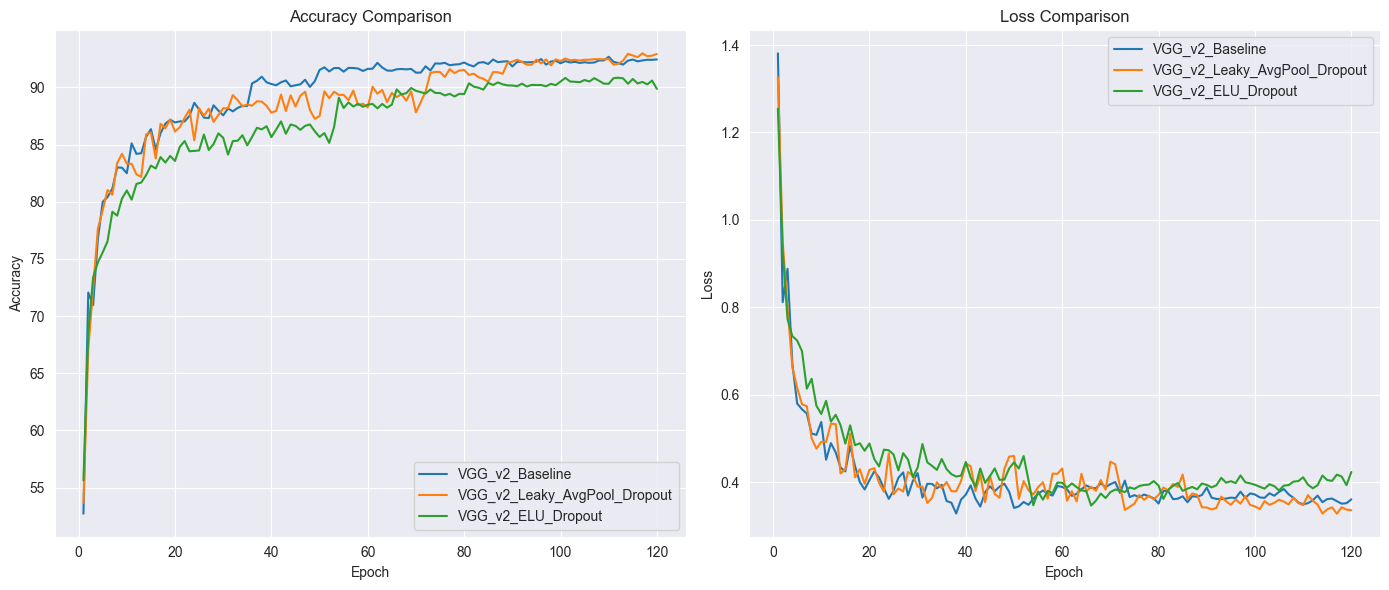

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 模型日志文件路径列表（可替换为你的文件路径）
log_files = {
    # 'CNN_v2_Baseline': './logs_v2/CNN_v2_Baseline_log.csv',
    # 'CNN_v2_Leaky_AvgPool_Dropout': './logs_fusion/CNN_v2_Leaky_AvgPool_Dropout_log.csv',
    # 'CNN_v2_NoBN_ELU_Dropout': './logs_fusion/CNN_v2_NoBN_ELU_Dropout_log.csv',
    # 'ResNet_v2_Baseline': './logs_v2/ResNet_v2_Baseline_log.csv',
    # 'ResNet_v2_Leaky_AvgPool_Dropout': './logs_fusion/ResNet_v2_Leaky_AvgPool_Dropout_log.csv',
    # 'ResNet_v2_NoBN_ELU_Dropout': './logs_fusion/ResNet_v2_NoBN_ELU_Dropout_log.csv',
    'VGG_v2_Baseline': './logs_v2/VGG_v2_Baseline_log.csv',
    'VGG_v2_Leaky_AvgPool_Dropout': './logs_fusion/VGG_v2_Leaky_AvgPool_Dropout_log.csv',
    'VGG_v2_ELU_Dropout': './logs_fusion/VGG_v2_ELU_Dropout_log.csv',
}

save_dir = './results_v2/train_logs'
os.makedirs(save_dir, exist_ok=True)

# 读取并绘图
plt.figure(figsize=(14, 6))

# 子图1：Accuracy
plt.subplot(1, 2, 1)
for model_name, file_path in log_files.items():
    df = pd.read_csv(file_path)
    plt.plot(df['Epoch'], df['Val Acc (%)'], label=model_name)
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 子图2：Loss
plt.subplot(1, 2, 2)
for model_name, file_path in log_files.items():
    df = pd.read_csv(file_path)
    plt.plot(df['Epoch'], df['Val Loss'], label=model_name)
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()

# 保存图片
save_path = os.path.join(save_dir, 'vggf.png')
plt.savefig(save_path, dpi=300)
print(f'图片已保存到: {save_path}')

plt.show()


## 读取训练日志数据

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.ticker import MaxNLocator

# 配置路径
log_dir = "./logs_v2"
output_dir = "./results_v2"
os.makedirs(output_dir, exist_ok=True)

# 加载所有日志文件
log_files = glob.glob(os.path.join(log_dir, "*_log.csv"))
logs = {os.path.basename(f).replace("_log.csv", ""): pd.read_csv(f) for f in log_files if "log" in f and "time" not in f and "complexity" not in f}

# 加载模型时间与复杂度表格
time_df = pd.read_csv(os.path.join(log_dir, "training_times.csv"))
complexity_df = pd.read_csv(os.path.join(log_dir, "model_complexity.csv"))


## 获取关键指标

In [29]:
# 获取每个模型的最佳测试准确率
summary = []
for name, df in logs.items():
    best_acc = df["Val Acc (%)"].max()  # 提取最大验证准确率
    summary.append([name, best_acc])

summary_df = pd.DataFrame(summary, columns=["Model", "Best Test Acc (%)"])

# 合并训练时间和复杂度
merged_df = summary_df.merge(time_df, on="Model", how="left").merge(complexity_df, on="Model", how="left")
merged_df.to_csv(os.path.join(output_dir, "2.1_关键指标表格.csv"), index=False)
merged_df

Model  Best Test Acc (%)  Training Time (min)   Params  \
0            CNN_v2_AvgPool              90.61                65.11  10.442M   
1           CNN_v2_Baseline              91.27                50.92  10.442M   
2            CNN_v2_Dropout              90.63                54.18  10.442M   
3                CNN_v2_ELU              89.57                53.02  10.442M   
4          CNN_v2_LeakyReLU              91.36                53.80  10.442M   
5          CNN_v2_NoPooling              88.27               382.54  10.442M   
6          CNN_v2_No_BN_Avg              86.09                64.71  10.438M   
7              CNN_v2_No_BN              89.06                52.92  10.438M   
8         ResNet_v2_AvgPool              92.51                71.94  11.172M   
9        ResNet_v2_Baseline              91.75                76.55  11.172M   
10        ResNet_v2_Dropout              91.73                66.83  11.172M   
11            ResNet_v2_ELU              89.96                71.43  11.172M   
12      ResNet_v2_LeakyReLU              91.80                71.89  11.172M   
13  ResNet_v2_No_BN_AvgPool              89.97                68.94  11.169M   
14          ResNet_v2_No_BN              90.24                69.23  11.169M   
15        ResNet_v2_No_Pool              94.12                99.71  11.172M   
16         ResNet_v2_No_Res              91.63                83.13  11.000M   
17           VGG_v2_AvgPool              92.82               100.02  33.647M   
18          VGG_v2_Baseline              92.67                78.76  33.647M   
19           VGG_v2_Dropout              92.68                78.70  33.647M   
20           VGG_v2_Dropout              92.68                78.70  33.647M   
21               VGG_v2_ELU              91.32                78.16  33.647M   
22         VGG_v2_LeakyReLU              92.88                78.43  33.647M   

       FLOPs  
0   235.316M  
1   235.255M  
2   235.255M  
3   235.255M  
4   235.255M  
5     6.358G  
6   234.333M  
7   234.272M  
8   204.587M  
9   204.569M  
10  204.569M  
11  204.569M  
12  204.569M  
13  203.121M  
14  203.102M  
15  557.660M  
16  203.782M  
17  333.250M  
18  333.219M  
19  333.219M  
20  333.219M  
21  333.219M  
22  333.219M

## 最佳测试准确率柱状图

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\4189869770.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=merged_df, x="Model", y="Best Test Acc (%)", palette="Set3")


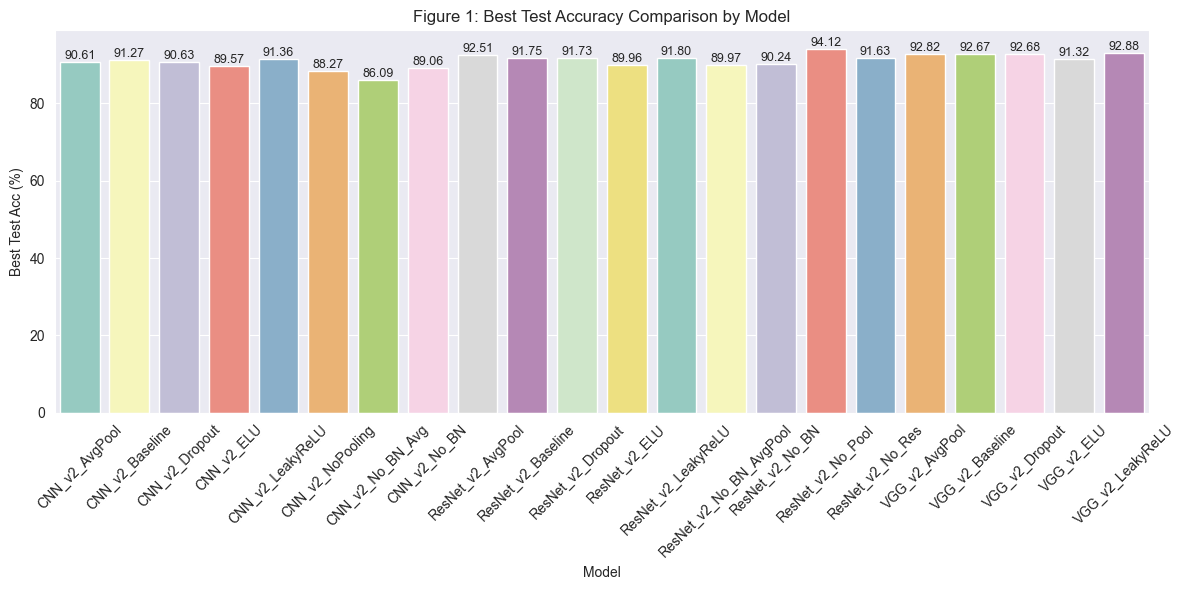

In [30]:

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=merged_df, x="Model", y="Best Test Acc (%)", palette="Set3")
plt.xticks(rotation=45)
plt.title("Figure 1: Best Test Accuracy Comparison by Model")
plt.tight_layout()

# 添加数值标签
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", label_type="edge", fontsize=9)

# 保存图像
plt.savefig(os.path.join(output_dir, "Fig1_Test_Accuracy_Comparison.png"))
plt.show()


## acc,params,flops,train_time

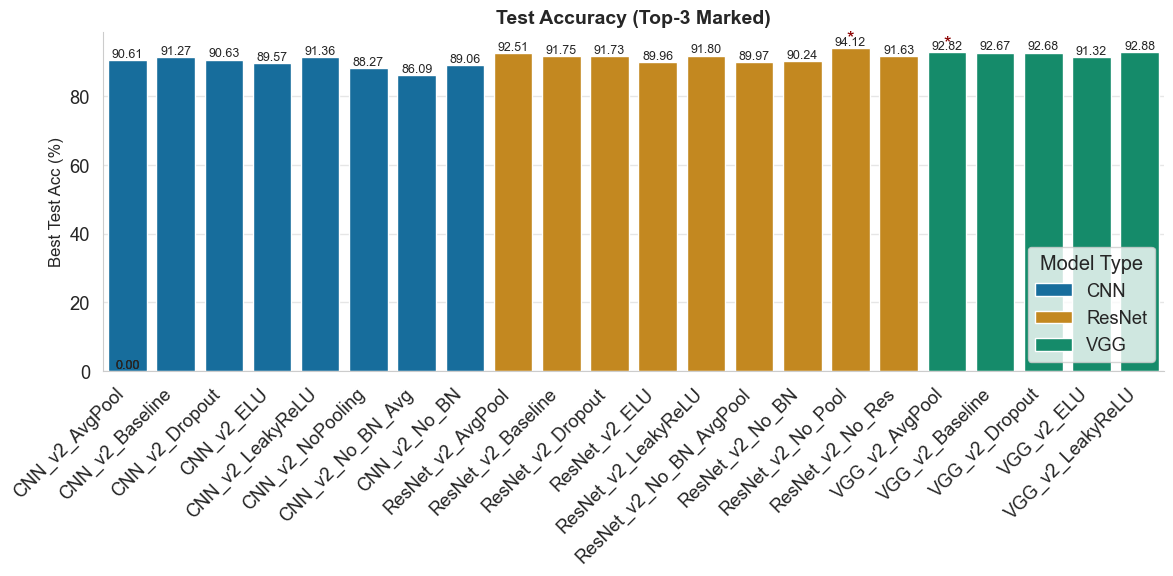

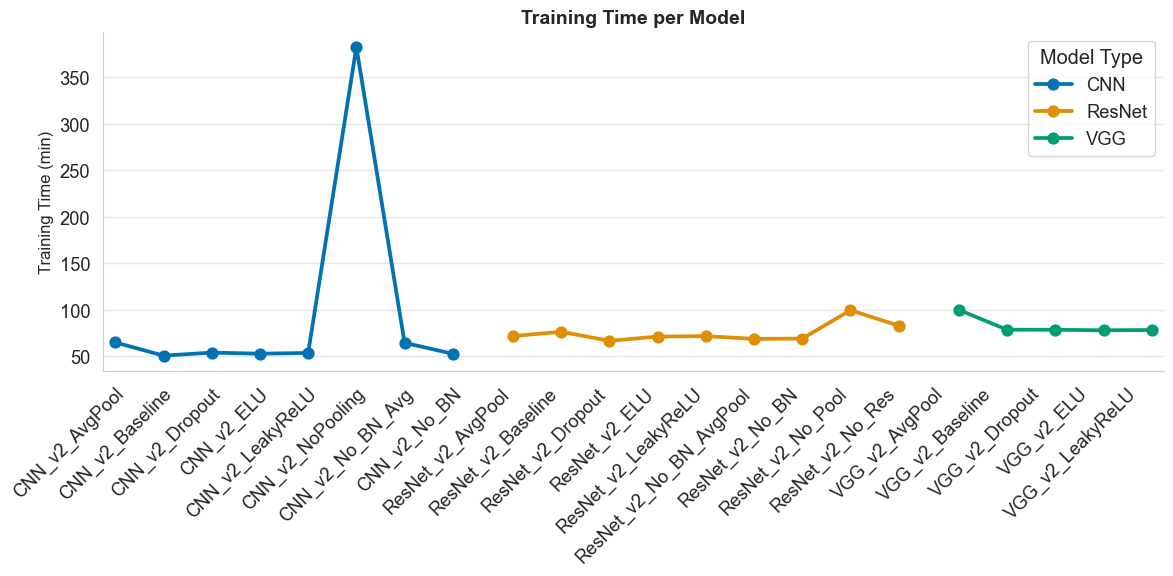

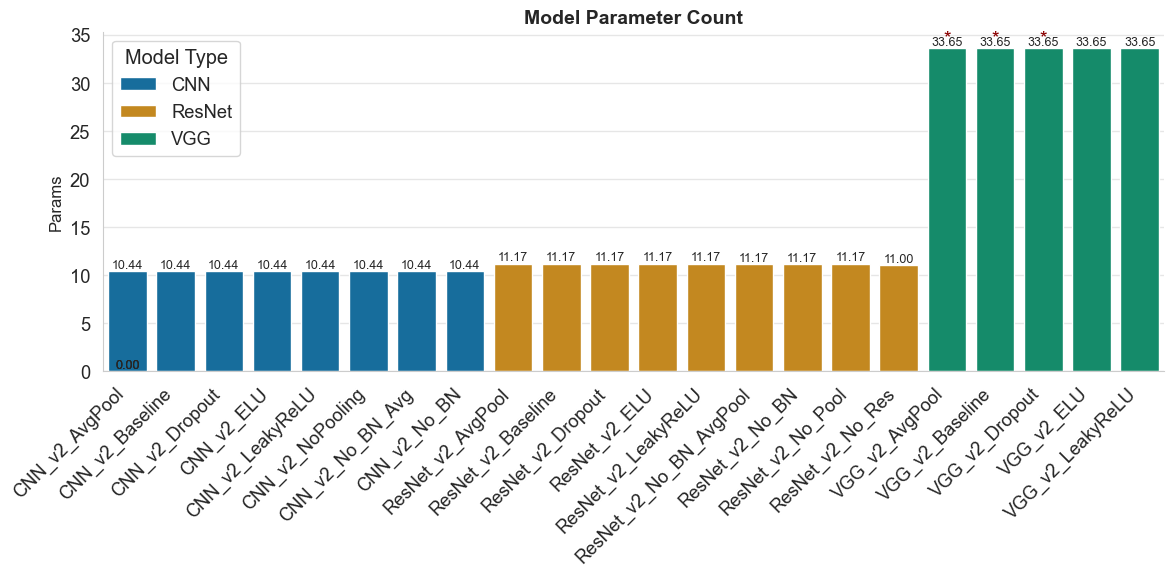

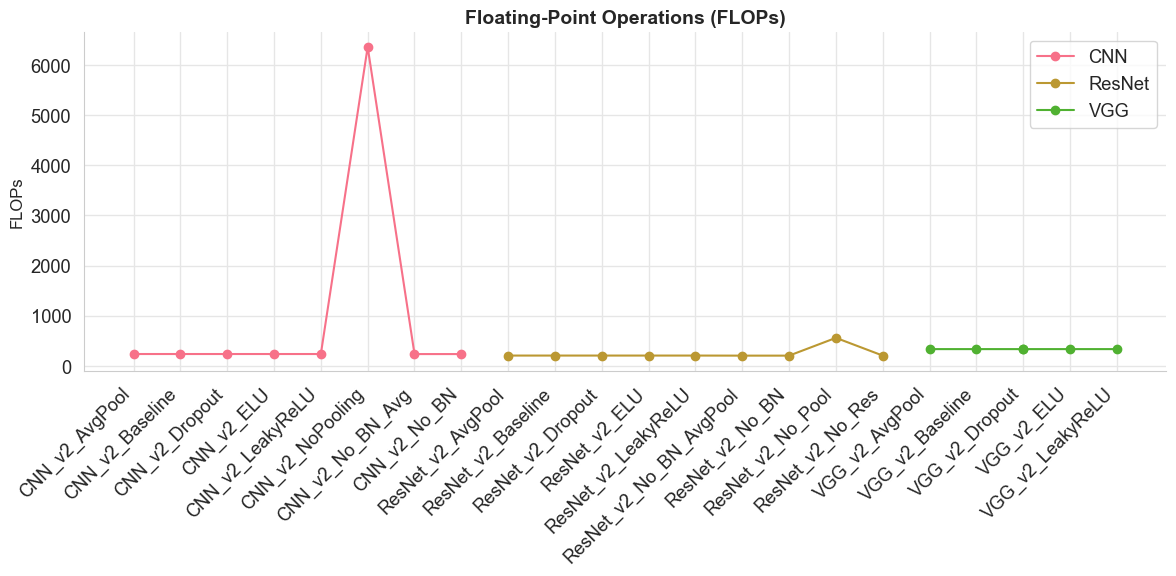

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\2088661087.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=avg_df, x='Model Type', y='Best Test Acc (%)', palette='coolwarm')


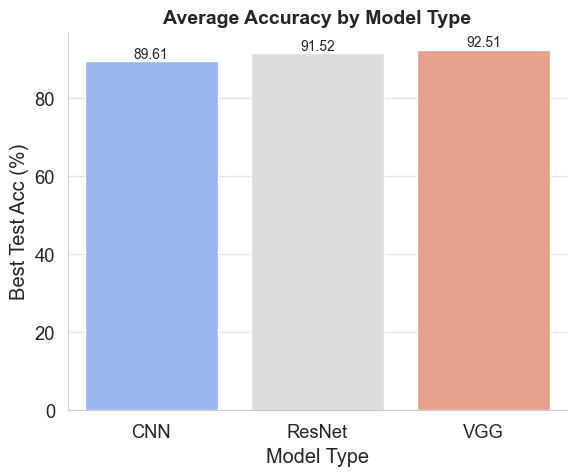

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

# 配置风格
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid", {'axes.edgecolor': '0.8', 'grid.color': '0.9'})
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.linewidth'] = 0.8
plt.rcParams['savefig.dpi'] = 300

# 读取数据
df = pd.read_csv('./results_v2/2.1_关键指标表格.csv')
# 将 Params 和 FLOPs 列转为 float（去除单位）
def parse_param(x):
    if isinstance(x, str):
        if 'M' in x:
            return float(x.replace('M', ''))
        elif 'K' in x:
            return float(x.replace('K', '')) / 1000
        elif 'G' in x:
            return float(x.replace('G', '')) * 1000
        else:
            return float(x)
    return x

df['Params'] = df['Params'].apply(parse_param)
df['FLOPs'] = df['FLOPs'].apply(parse_param)

# 标注模型类别
def model_type(name):
    if 'CNN' in name:
        return 'CNN'
    elif 'ResNet' in name:
        return 'ResNet'
    elif 'VGG' in name:
        return 'VGG'
    return 'Other'

df['Model Type'] = df['Model'].apply(model_type)

# 确保保存图目录存在
os.makedirs('figures1', exist_ok=True)

# 自动标记 Top-3 模型
def annotate_top3(ax, data, value_col):
    top3 = data.nlargest(3, value_col)
    for _, row in top3.iterrows():
        for bar in ax.patches:
            if bar.get_x() < row.name + 0.5 and bar.get_x() > row.name - 0.5:
                ax.annotate('*', (bar.get_x() + bar.get_width() / 2., bar.get_height()),
                            ha='center', va='bottom', fontsize=14, color='darkred')

# 绘图函数
def plot_metric(data, x, y, title, filename, kind='bar', palette='colorblind', annotate=True):
    plt.figure(figsize=(12, 6))

    if kind == 'bar':
        ax = sns.barplot(data=data, x=x, y=y, hue='Model Type', palette=palette)
    elif kind == 'point':
        ax = sns.pointplot(data=data, x=x, y=y, hue='Model Type', dodge=0.5, palette=palette)
    elif kind == 'line':
        for label in data['Model Type'].unique():
            subset = data[data['Model Type'] == label]
            plt.plot(subset[x], subset[y], marker='o', label=label)
        ax = plt.gca()
        plt.legend()

    # 标注具体数值
    if kind != 'line':
        for bar in ax.patches:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}', (bar.get_x() + bar.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=9)

    if annotate and kind == 'bar':
        annotate_top3(ax, data, y)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('')
    plt.ylabel(y, fontsize=12)
    plt.xticks(rotation=45, ha='right')
    sns.despine()
    plt.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.show()

# 图1: 准确率（Top3 标星）
plot_metric(df, 'Model', 'Best Test Acc (%)', 'Test Accuracy (Top-3 Marked)', 'acc_comparison_top3', kind='bar')

# 图2: 训练时间（点图）
plot_metric(df, 'Model', 'Training Time (min)', 'Training Time per Model', 'train_time_comparison', kind='point')

# 图3: 参数量（柱状图）
plot_metric(df, 'Model', 'Params', 'Model Parameter Count', 'params_comparison', kind='bar')

# 图4: FLOPs（折线图）
plot_metric(df, 'Model', 'FLOPs', 'Floating-Point Operations (FLOPs)', 'flops_comparison', kind='line')

# 图5: 不同模型类别的平均准确率
avg_df = df.groupby('Model Type')['Best Test Acc (%)'].mean().reset_index()
plt.figure(figsize=(6, 5))
ax = sns.barplot(data=avg_df, x='Model Type', y='Best Test Acc (%)', palette='coolwarm')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)
plt.title('Average Accuracy by Model Type', fontsize=14, fontweight='bold')
sns.despine()
plt.tight_layout()
plt.savefig('figures/avg_acc_by_type.png')
plt.show()


## 指定模型组绘制多种风格的图表

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid')
plt.rcParams.update({'figure.figsize': (10, 5), 'font.size': 10})

# Load CSV
csv_path = './results_v2/2.1_关键指标表格.csv'
df = pd.read_csv(csv_path)
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces


In [45]:
def plot_multiple_styles(group_name, models, metric):
    """
    为指定模型组绘制多种风格的图表
    
    参数:
        group_name: 组别名称(用于标题和文件名)
        models: 要绘制的模型列表
        metric: 要绘制的指标列名
    """
    # 准备数据
    data = df[df['Model'].isin(models)].copy()
    data = data.set_index('Model').loc[models]
    
    # 转换带单位的数值为纯数字
    if metric == "FLOPs":
        data[metric] = data[metric].str.replace('M', '').str.replace('G', 'e3').astype(float)
    elif metric == "Training Time (min)":
        data[metric] = data[metric].astype(float)
    elif metric == "Best Test Acc (%)":
        data[metric] = data[metric].astype(float)
    
    # 创建输出目录
    os.makedirs(group_name, exist_ok=True)
    
    # 设置全局样式
    available_styles = plt.style.available
    if 'seaborn' in available_styles:
        plt.style.use('seaborn')
    else:
        plt.style.use('ggplot')
    
    sns.set_palette("husl")
    label_font = {'size': 12, 'weight': 'bold'}
    title_font = {'size': 14, 'weight': 'bold'}
    
    # 1. 竖向柱状图
    plt.figure(figsize=(12, 7))
    ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)
    
    # 添加数据标签（根据数据类型调整格式）
    for i, val in enumerate(data[metric]):
        label = f'{val:.1f}M' if metric == "FLOPs" and val > 1000 else f'{val:.2f}'
        ax.text(i, val/2, label, 
                ha='center', va='center', 
                color='white', fontsize=11, fontweight='bold')
    
    # 美化图表
    ylabel = "FLOPs (Millions)" if metric == "FLOPs" else metric
    ax.set_title(f"{group_name} - {metric}\nVertical Bar Chart", **title_font)
    ax.set_xlabel("Model", **label_font)
    ax.set_ylabel(ylabel, **label_font)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'./results_v2/{group_name}/{metric}_vertical_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 2. 横向柱状图
    plt.figure(figsize=(12, 7))
    data_sorted = data.sort_values(metric, ascending=False)
    ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)
    
    # 添加数据标签
    for i, val in enumerate(data_sorted[metric]):
        label = f'{val:.1f}M' if metric == "FLOPs" and val > 1000 else f'{val:.2f}'
        ax.text(val/2, i, label, 
                ha='center', va='center', 
                color='white', fontsize=11, fontweight='bold')
    
    # 美化图表
    xlabel = "FLOPs (Millions)" if metric == "FLOPs" else metric
    ax.set_title(f"{group_name} - {metric}\nHorizontal Bar Chart", **title_font)
    ax.set_ylabel("Model", **label_font)
    ax.set_xlabel(xlabel, **label_font)
    plt.tight_layout()
    plt.savefig(f'./results_v2/{group_name}/{metric}_horizontal_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 3. 折线图
    plt.figure(figsize=(12, 7))
    ax = sns.lineplot(x=data.index, y=data[metric], 
                     marker='o', markersize=10, linewidth=3, color='royalblue')
    
    # 添加数据标签
    for i, val in enumerate(data[metric]):
        label = f'{val:.1f}M' if metric == "FLOPs" and val > 1000 else f'{val:.2f}'
        ax.text(i, val+0.02*data[metric].max(), label, 
                ha='center', va='bottom', 
                fontsize=11, bbox=dict(facecolor='white', alpha=0.8))
    
    # 美化图表
    ylabel = "FLOPs (Millions)" if metric == "FLOPs" else metric
    ax.set_title(f"{group_name} - {metric}\nTrend Line Chart", **title_font)
    ax.set_xlabel("Model", **label_font)
    ax.set_ylabel(ylabel, **label_font)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'./results_v2/{group_name}/{metric}_line_chart.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

    # 4. 点图
    plt.figure(figsize=(12, 7))
    ax = sns.stripplot(x=data.index, y=data[metric], 
                      size=15, jitter=0.1, palette="deep", alpha=0.8)
    
    # 添加数据标签
    for i, val in enumerate(data[metric]):
        label = f'{val:.1f}M' if metric == "FLOPs" and val > 1000 else f'{val:.2f}'
        ax.text(i, val, label, 
                ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # 美化图表
    ylabel = "FLOPs (Millions)" if metric == "FLOPs" else metric
    ax.set_title(f"{group_name} - {metric}\nDot Distribution Chart", **title_font)
    ax.set_xlabel("Model", **label_font)
    ax.set_ylabel(ylabel, **label_font)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'./results_v2/{group_name}/{metric}_dot_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


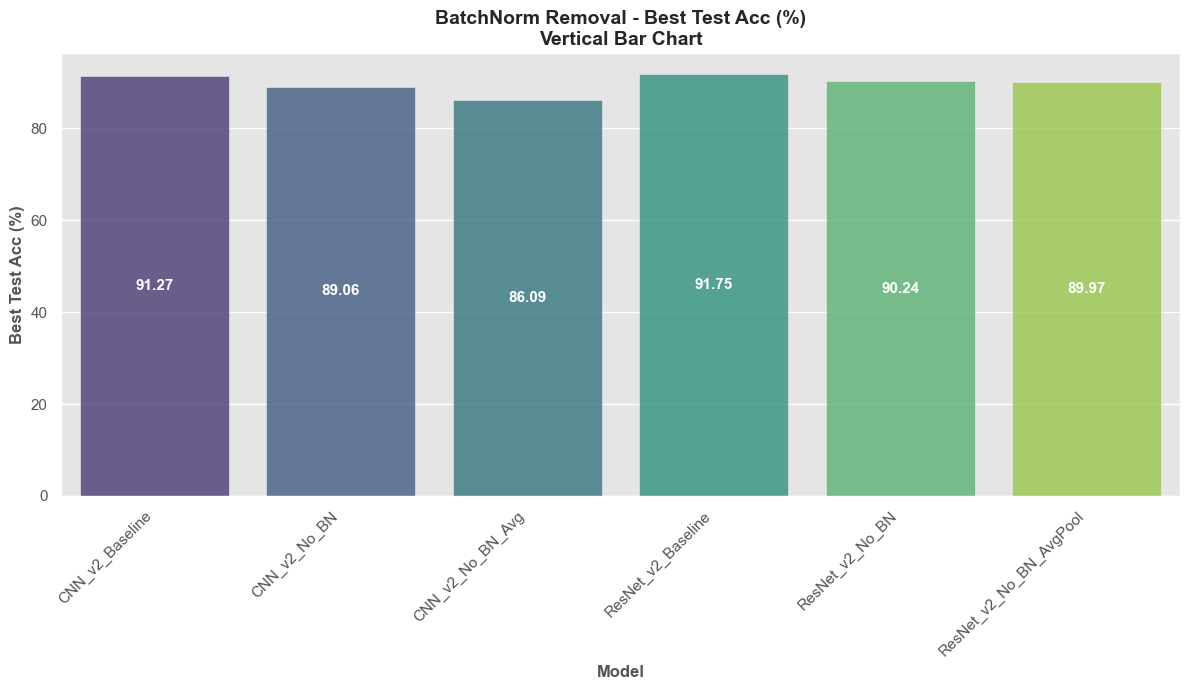

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


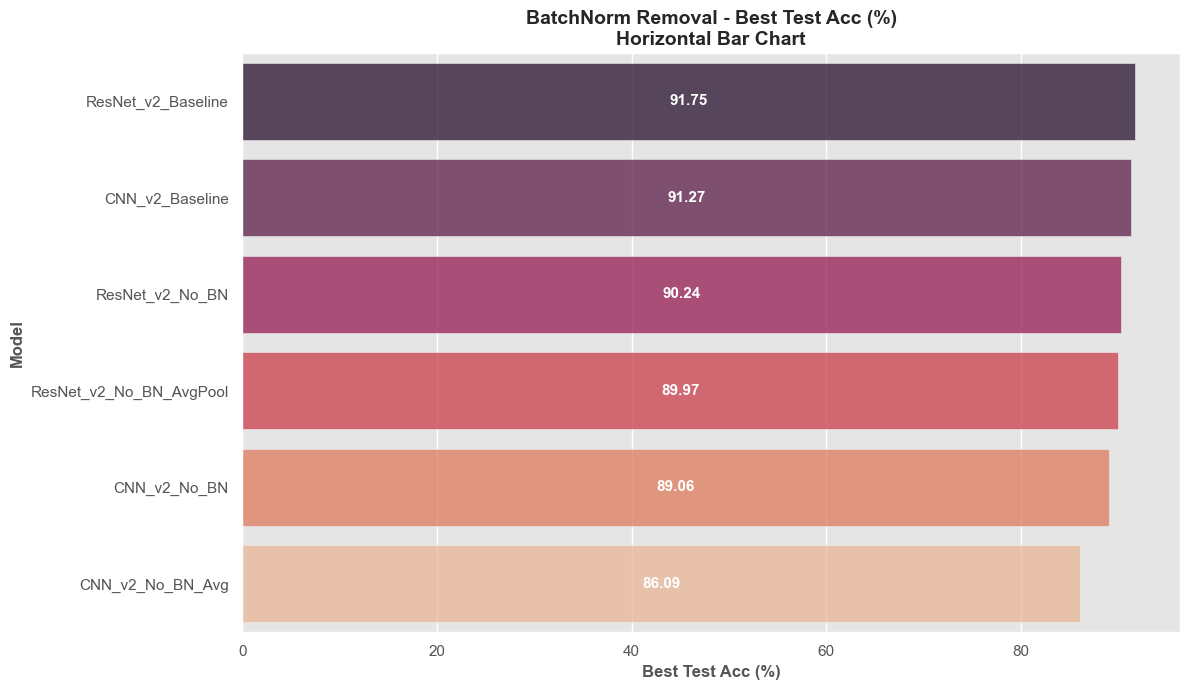

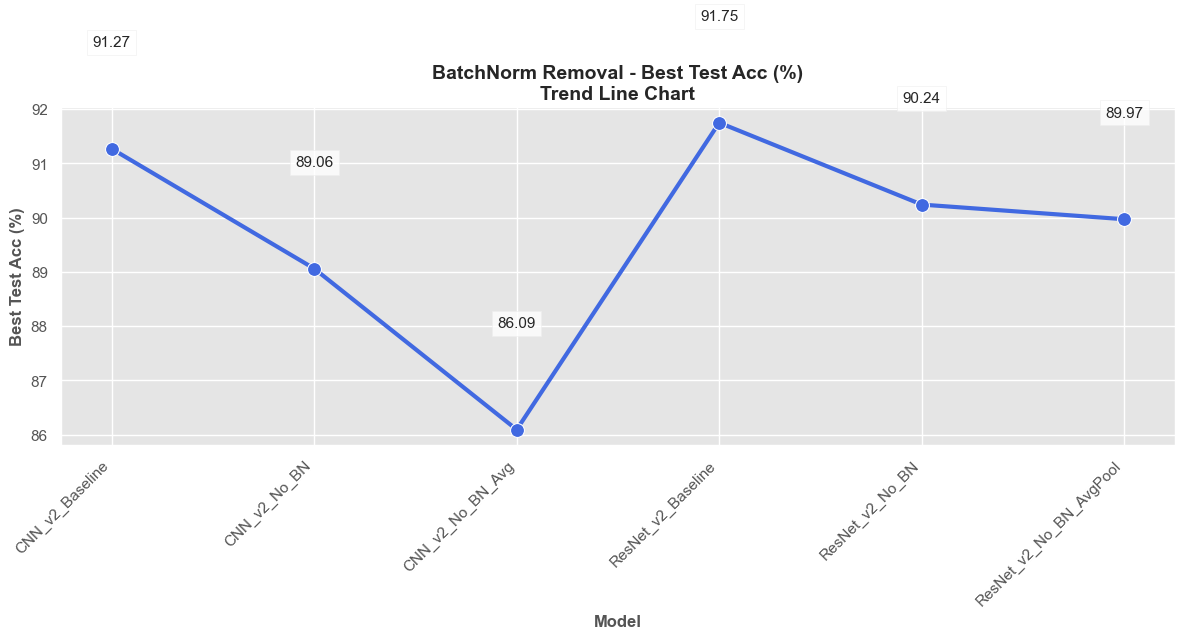

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


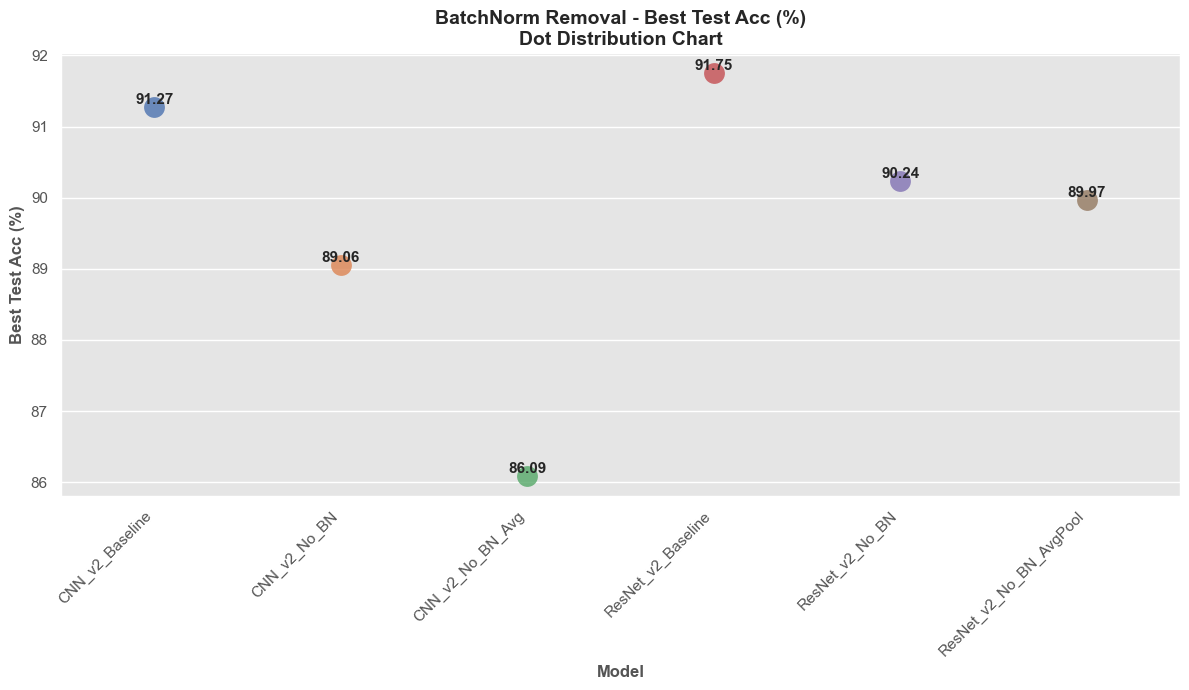

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


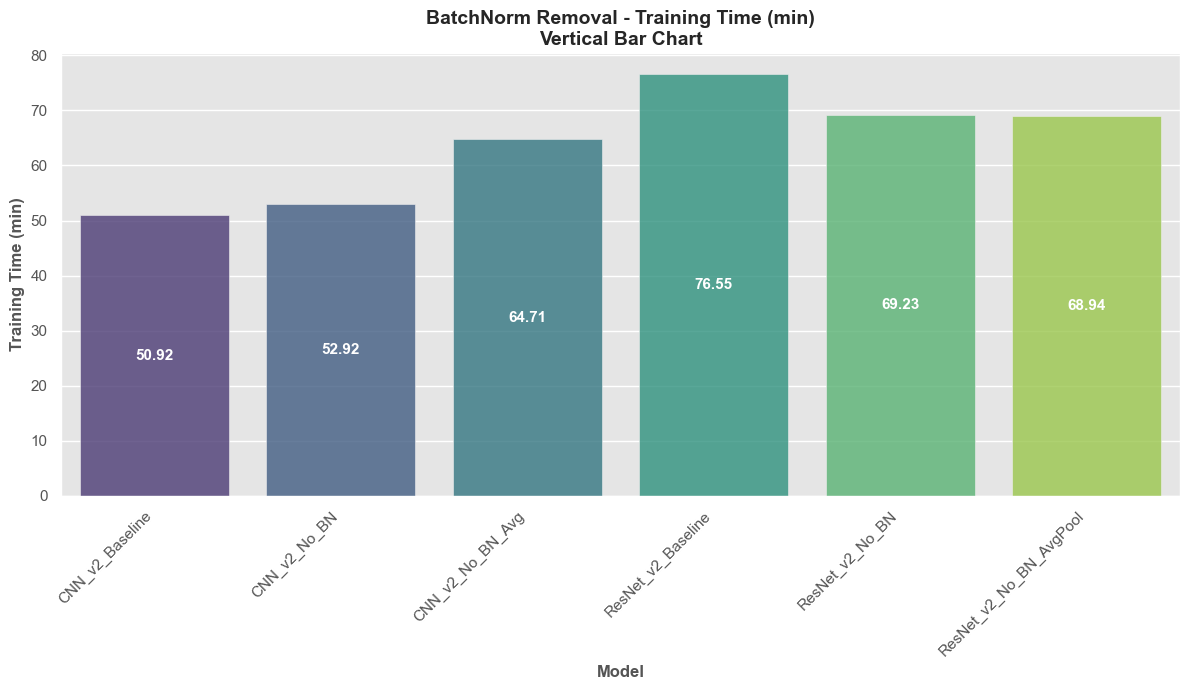

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


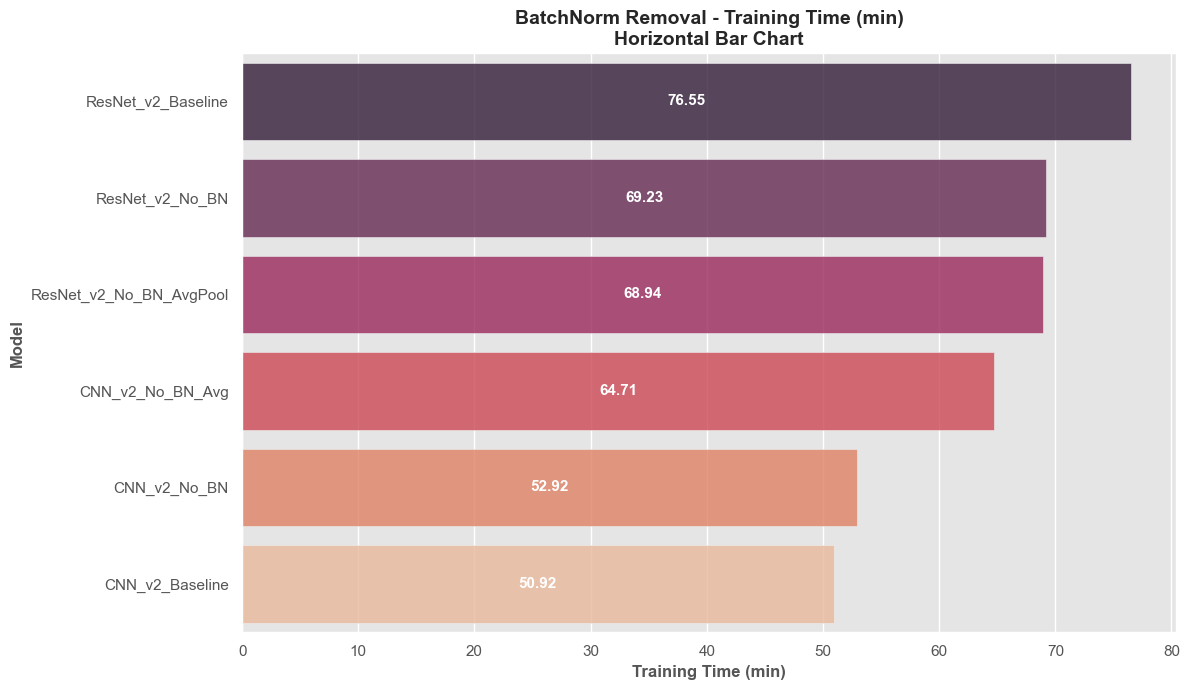

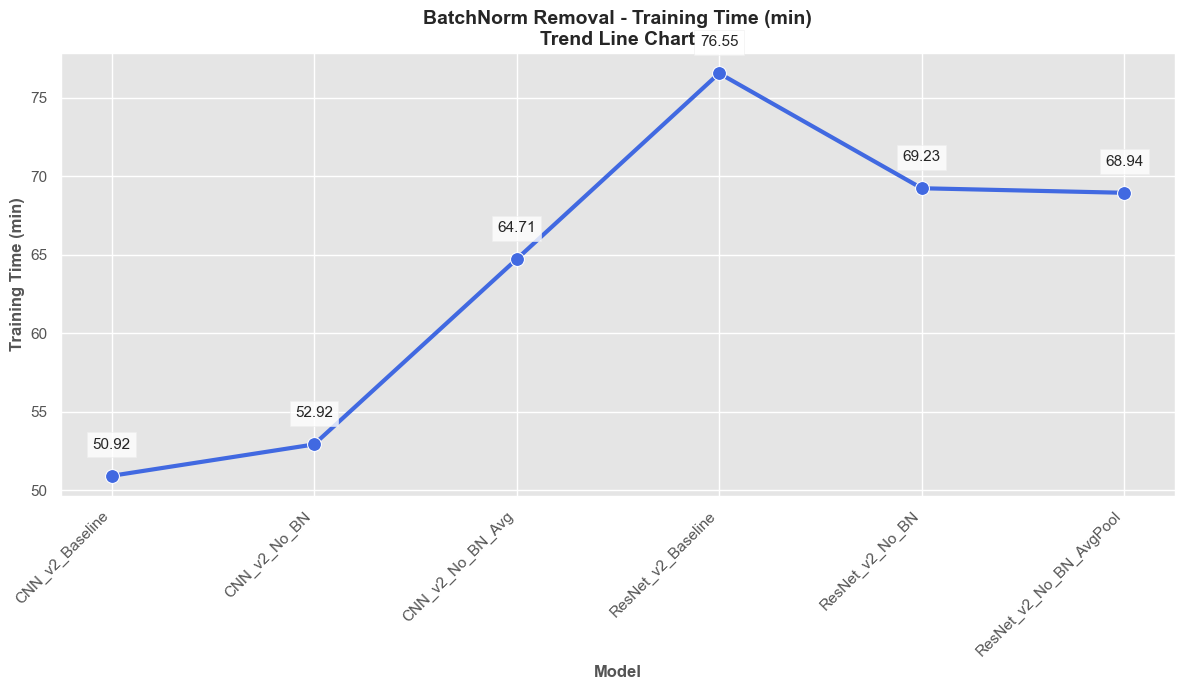

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


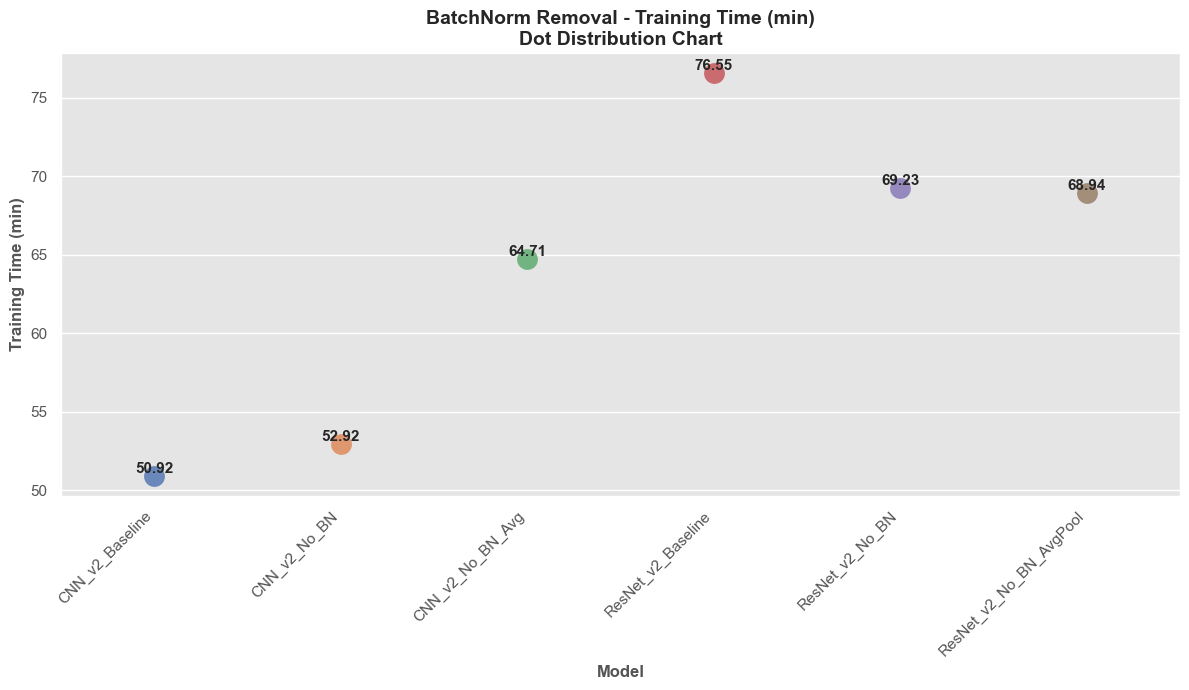

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


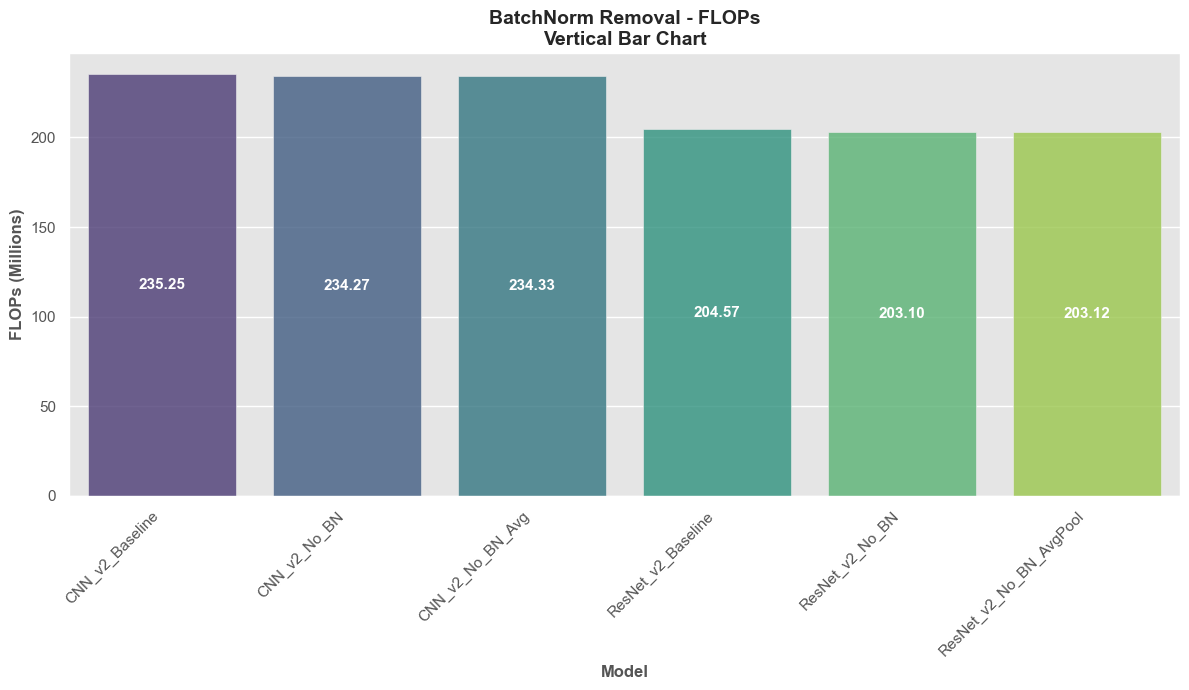

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


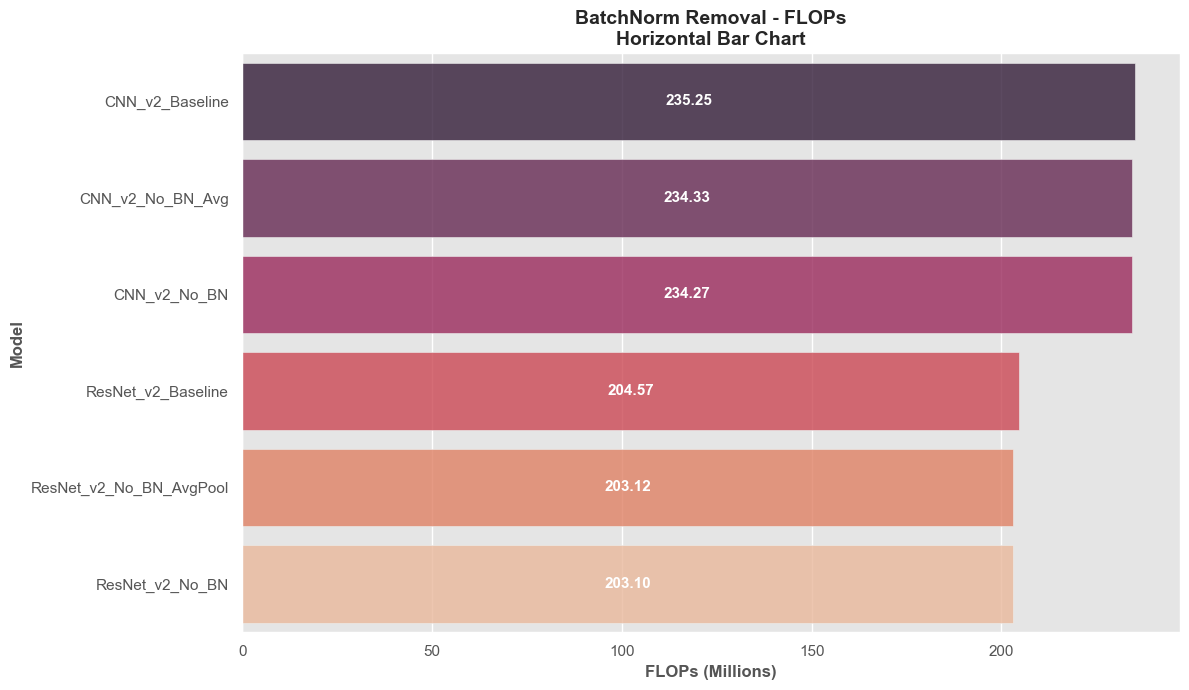

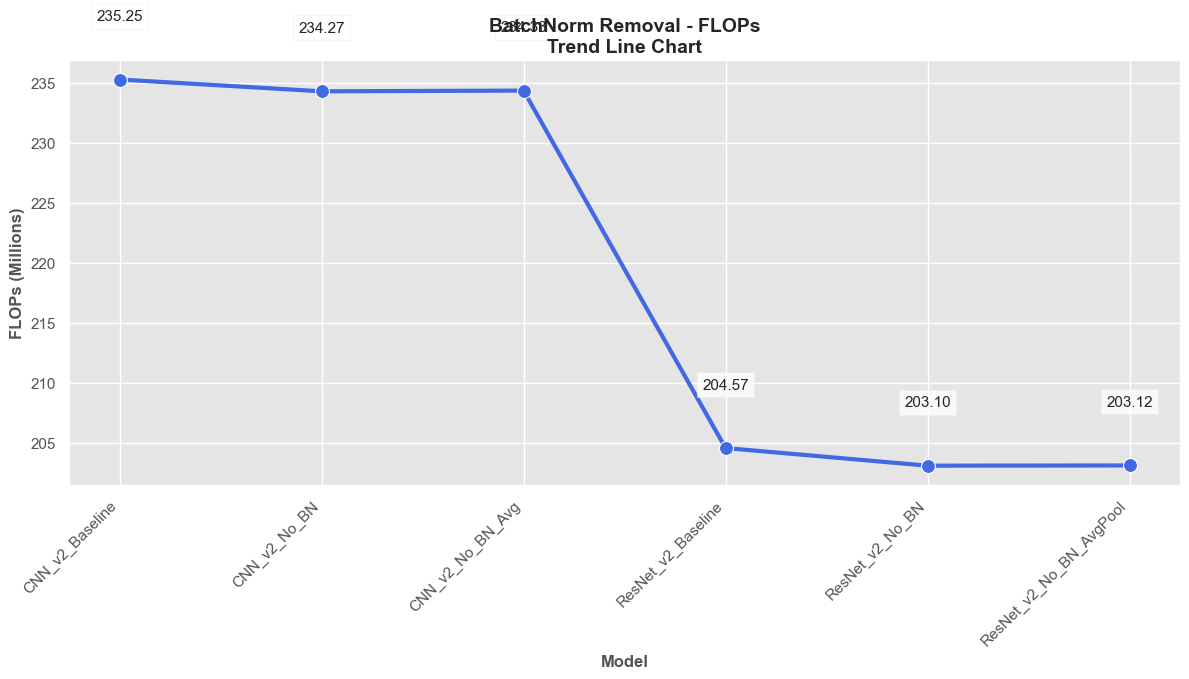

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


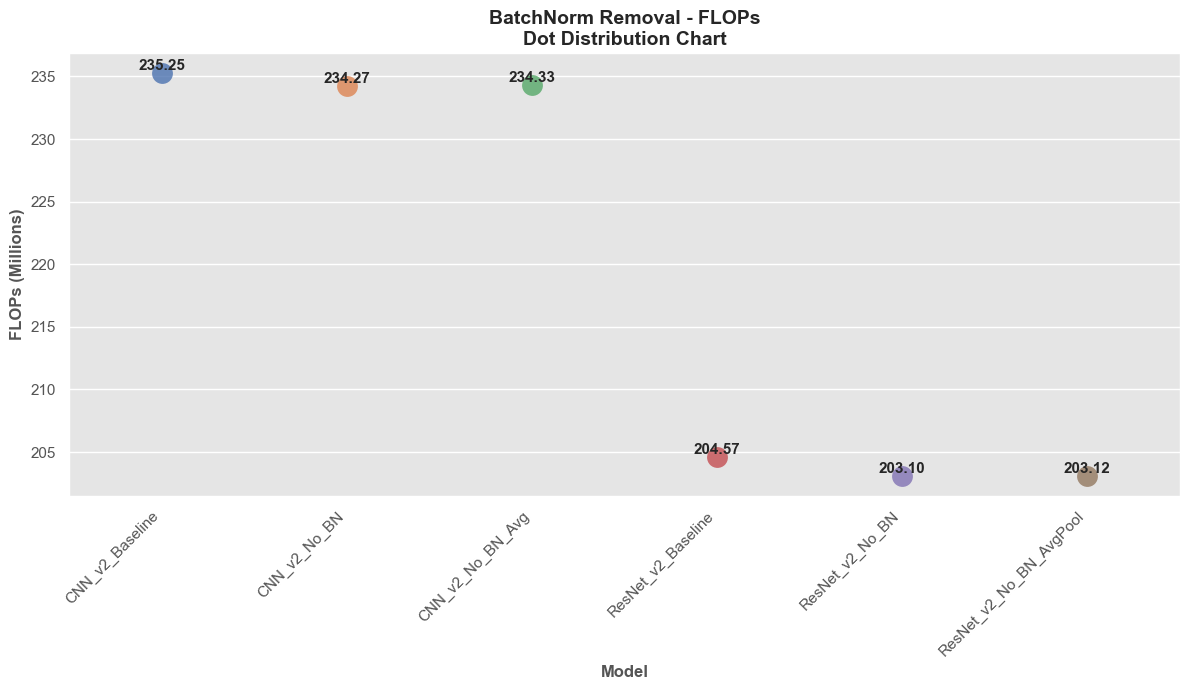

In [46]:
# Cell 2: BatchNorm Removal - Plot all styles
group_name = "BatchNorm Removal"
models = [
    "CNN_v2_Baseline", "CNN_v2_No_BN", "CNN_v2_No_BN_Avg",
    "ResNet_v2_Baseline", "ResNet_v2_No_BN", "ResNet_v2_No_BN_AvgPool"
]

for metric in ["Best Test Acc (%)", "Training Time (min)", "FLOPs"]:
    plot_multiple_styles(group_name, models, metric)


C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


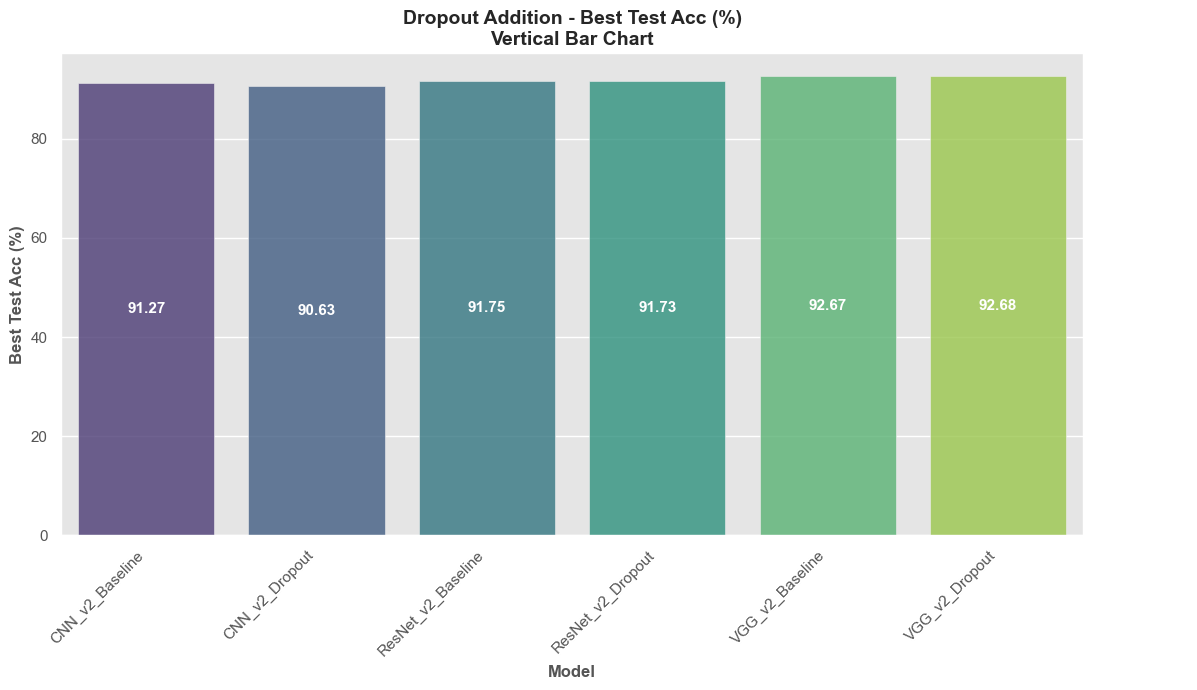

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


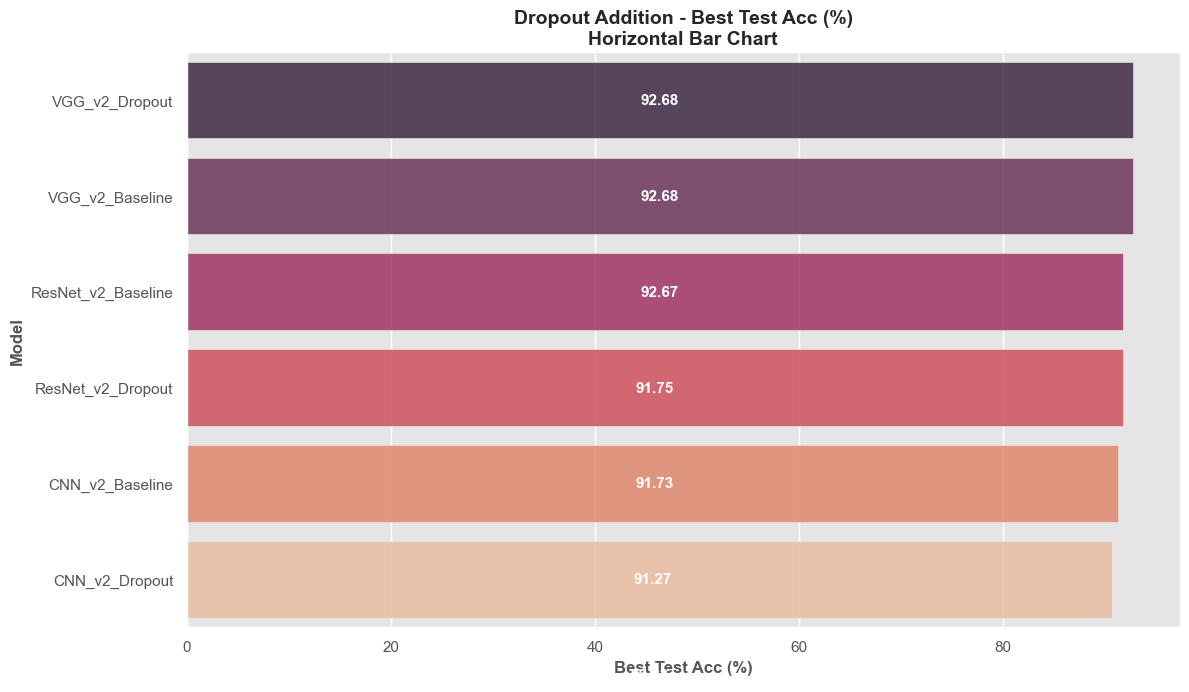

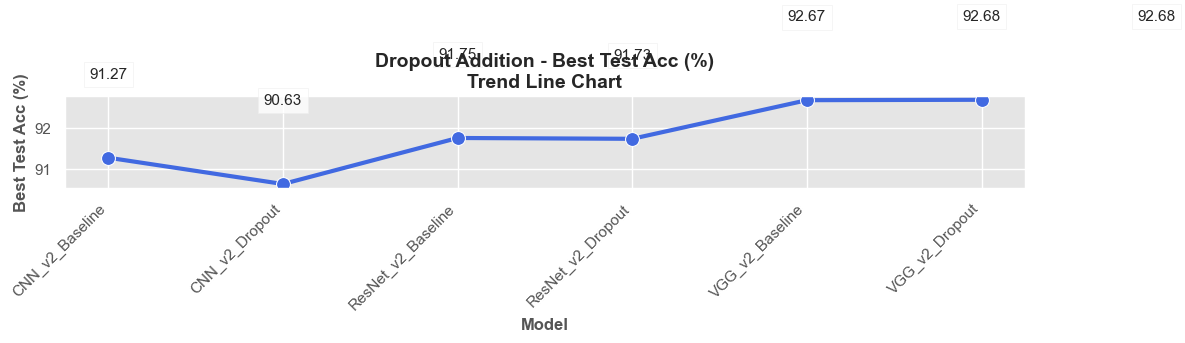

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


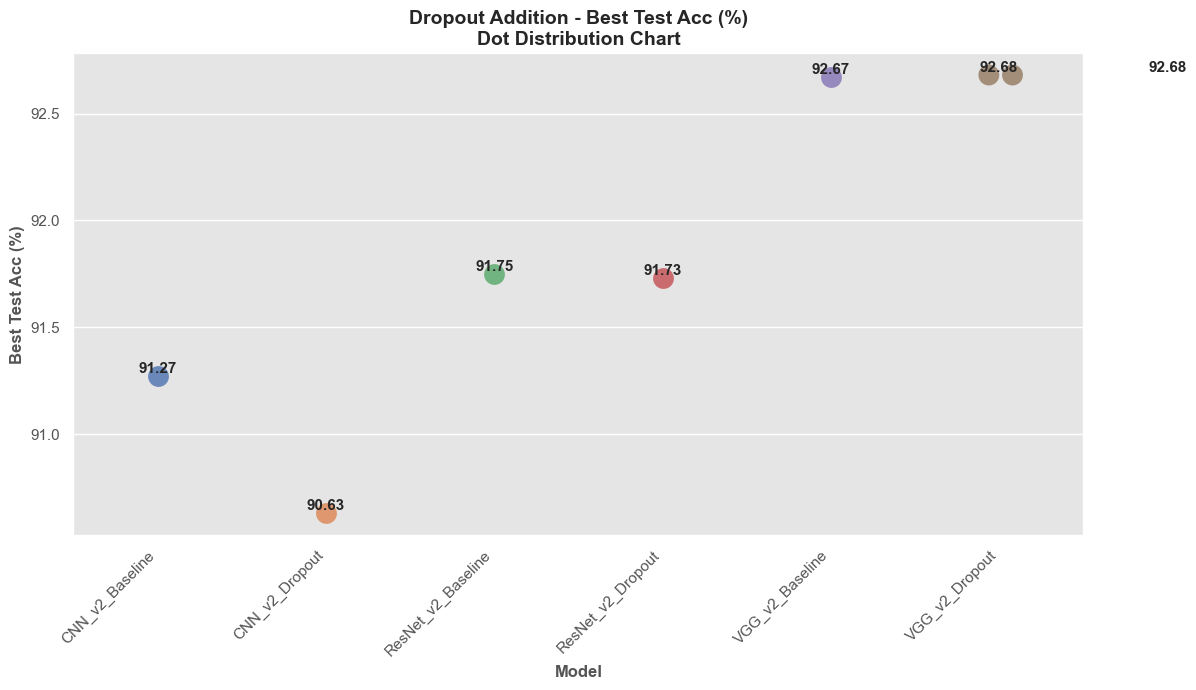

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


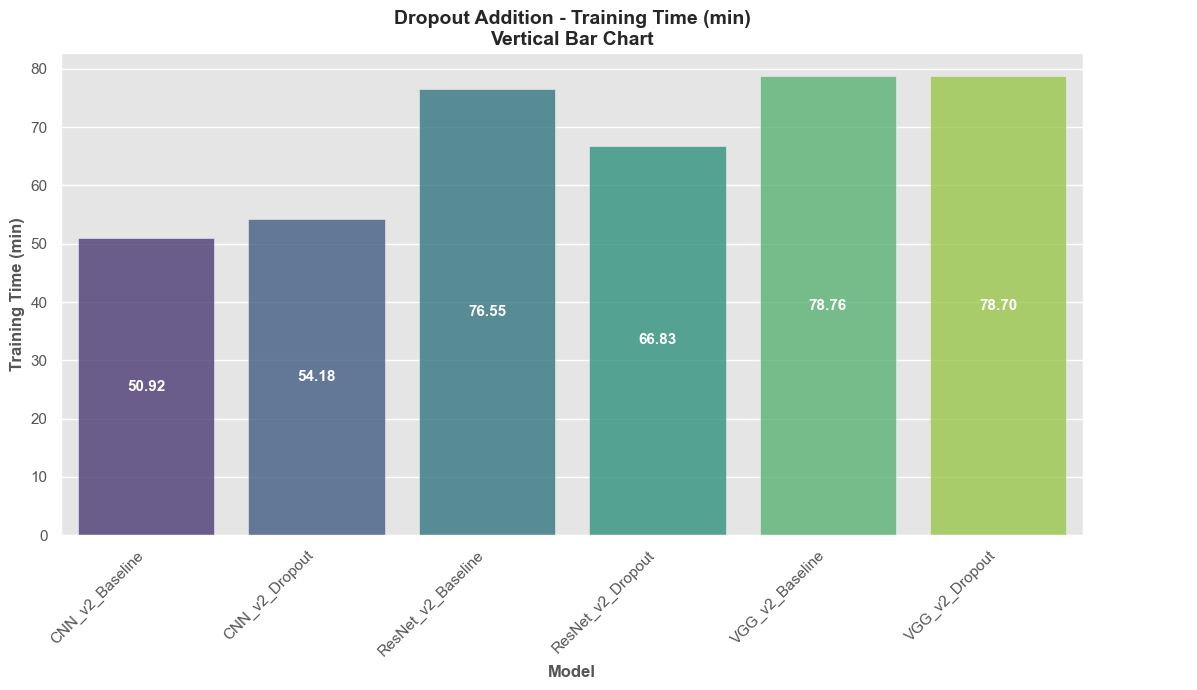

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


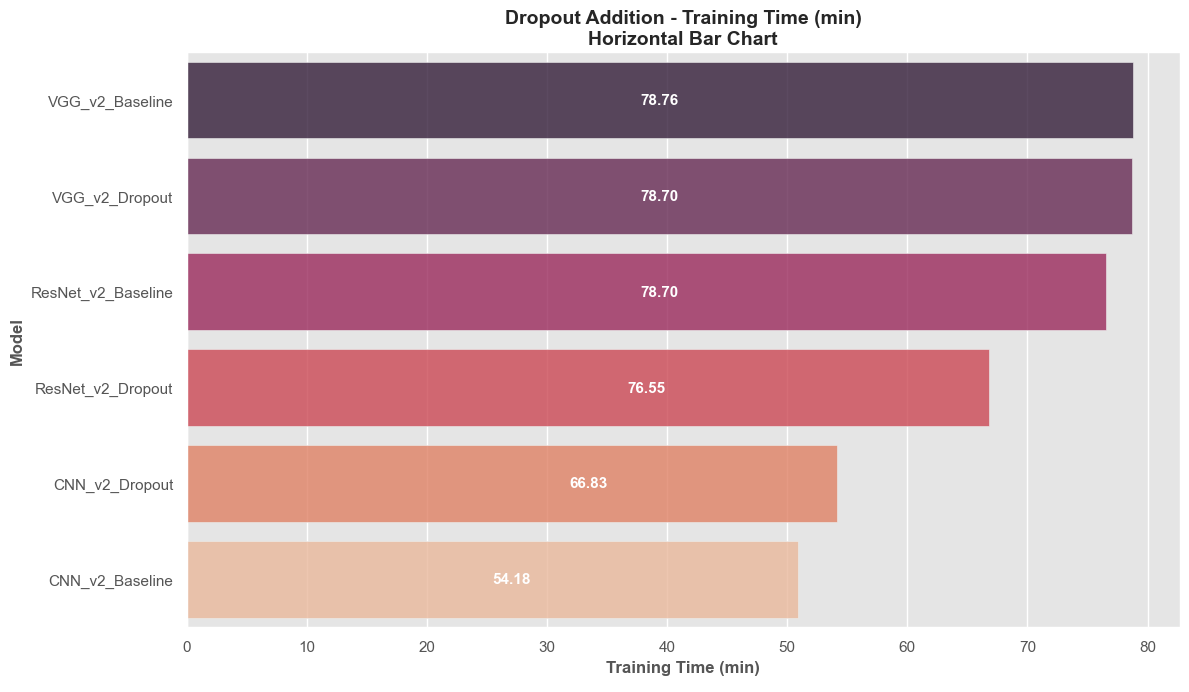

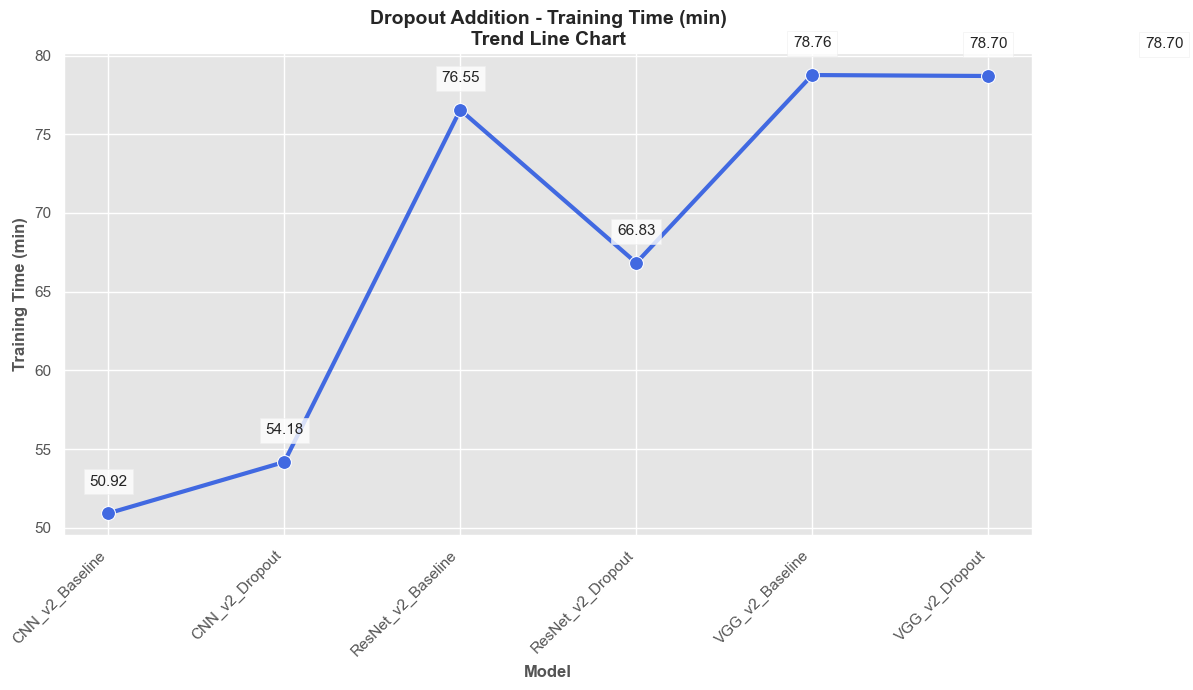

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


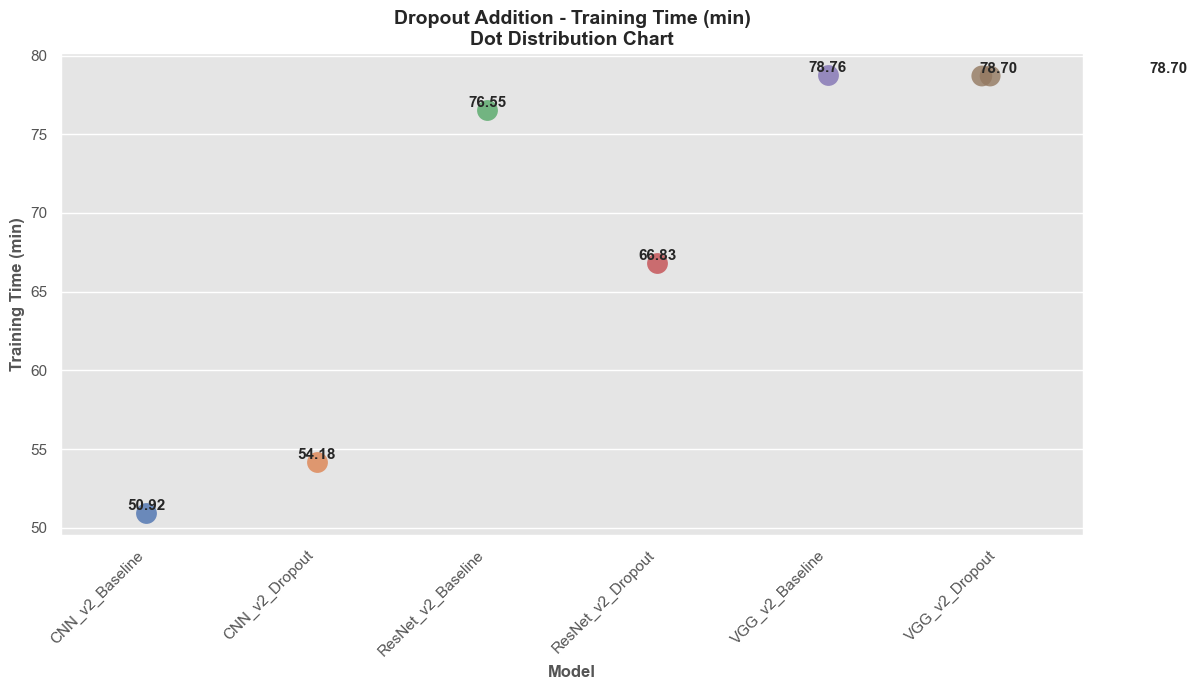

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


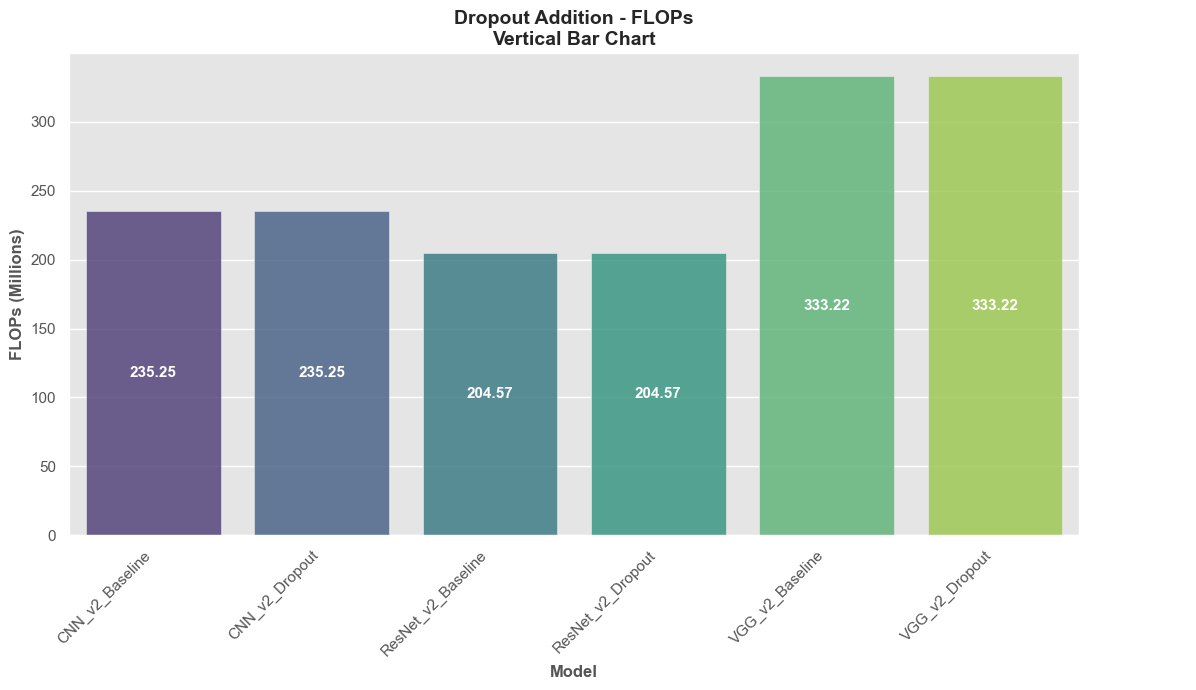

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


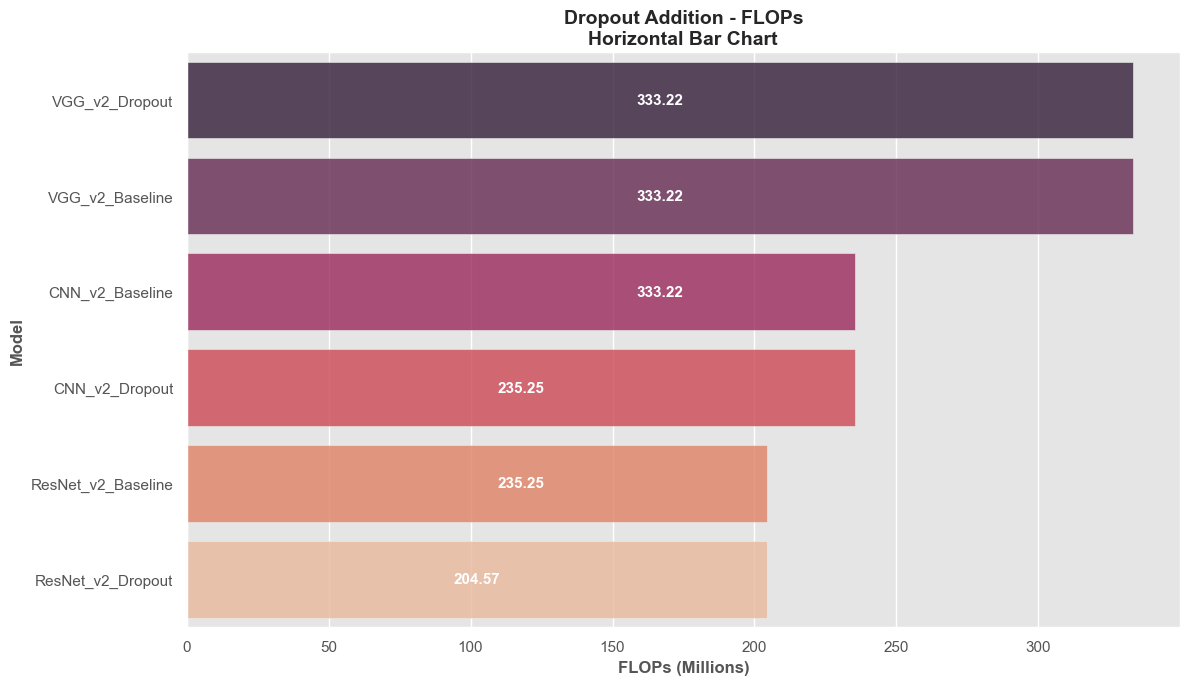

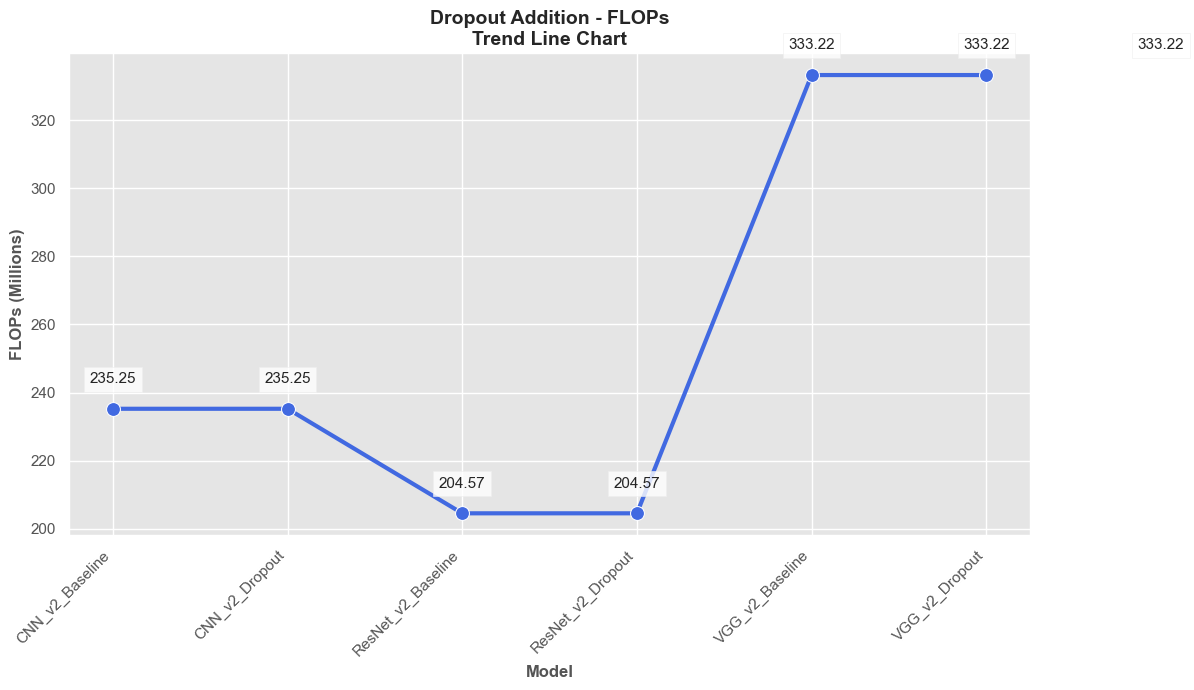

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


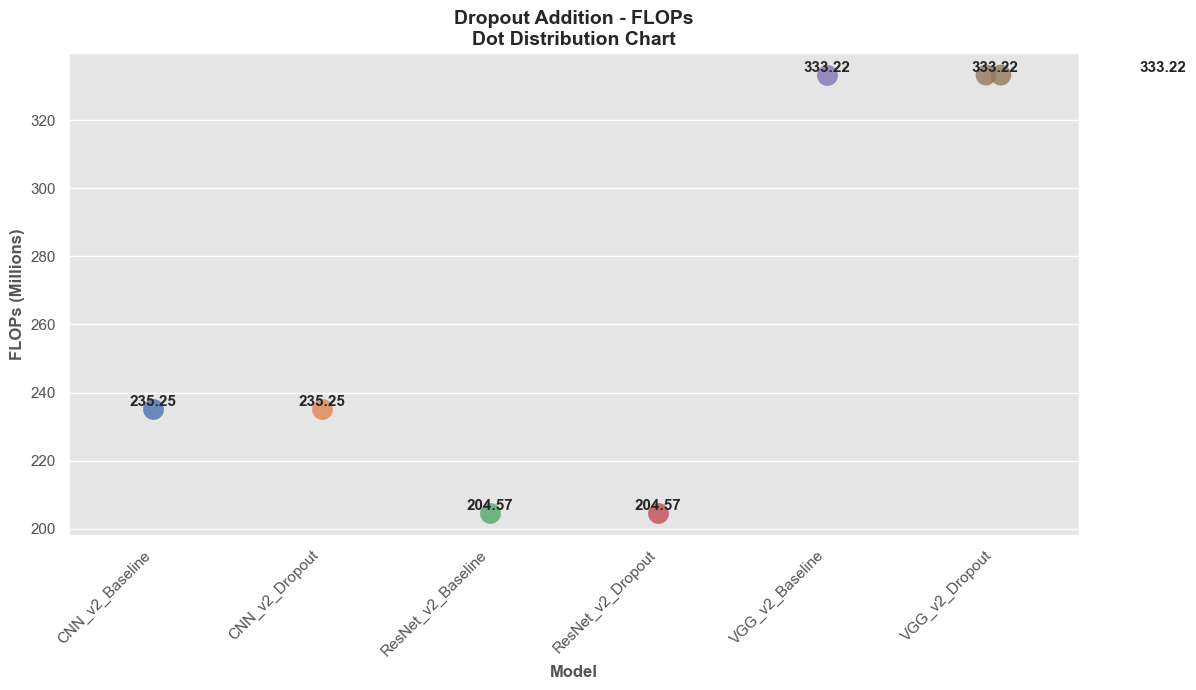

In [47]:
group_name = "Dropout Addition"
models = [
    "CNN_v2_Baseline", "CNN_v2_Dropout",
    "ResNet_v2_Baseline", "ResNet_v2_Dropout",
    "VGG_v2_Baseline", "VGG_v2_Dropout"
]

for metric in ["Best Test Acc (%)", "Training Time (min)", "FLOPs"]:
    plot_multiple_styles(group_name, models, metric)


C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


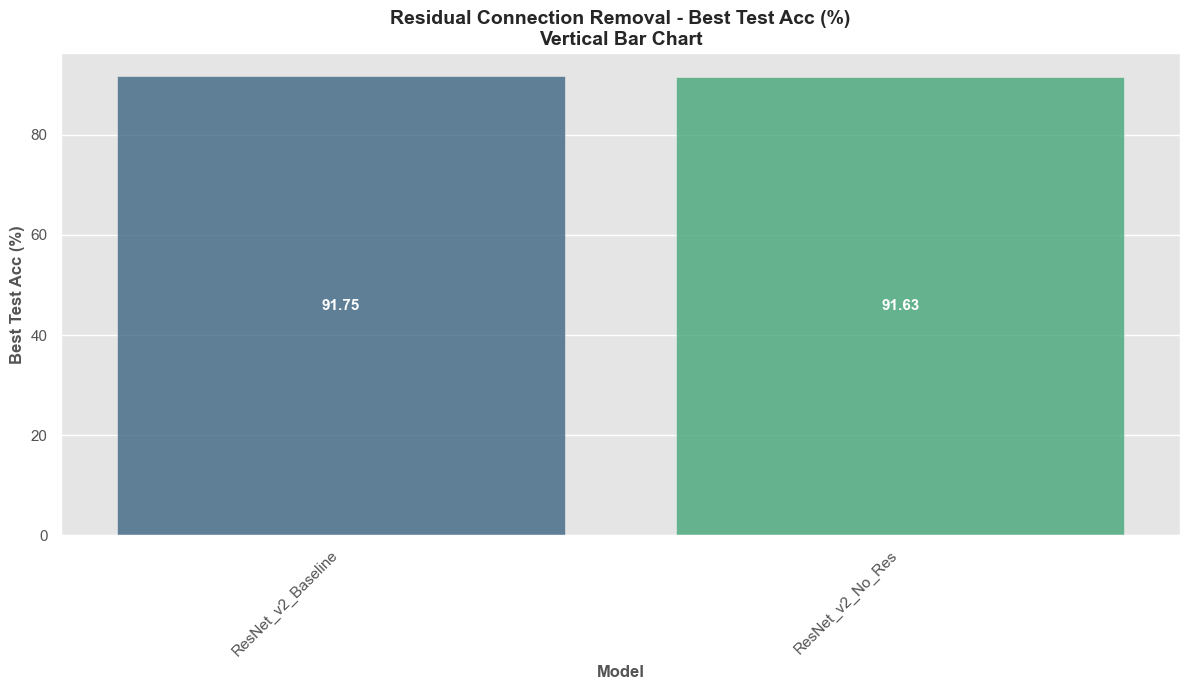

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


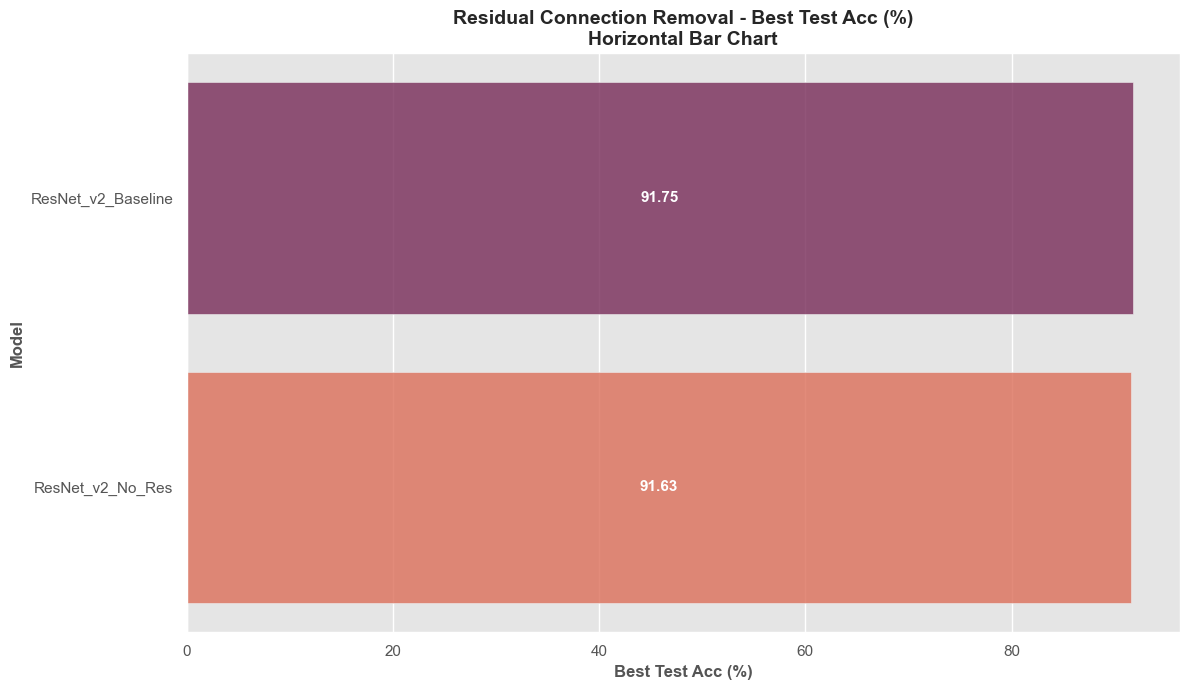

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:98: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


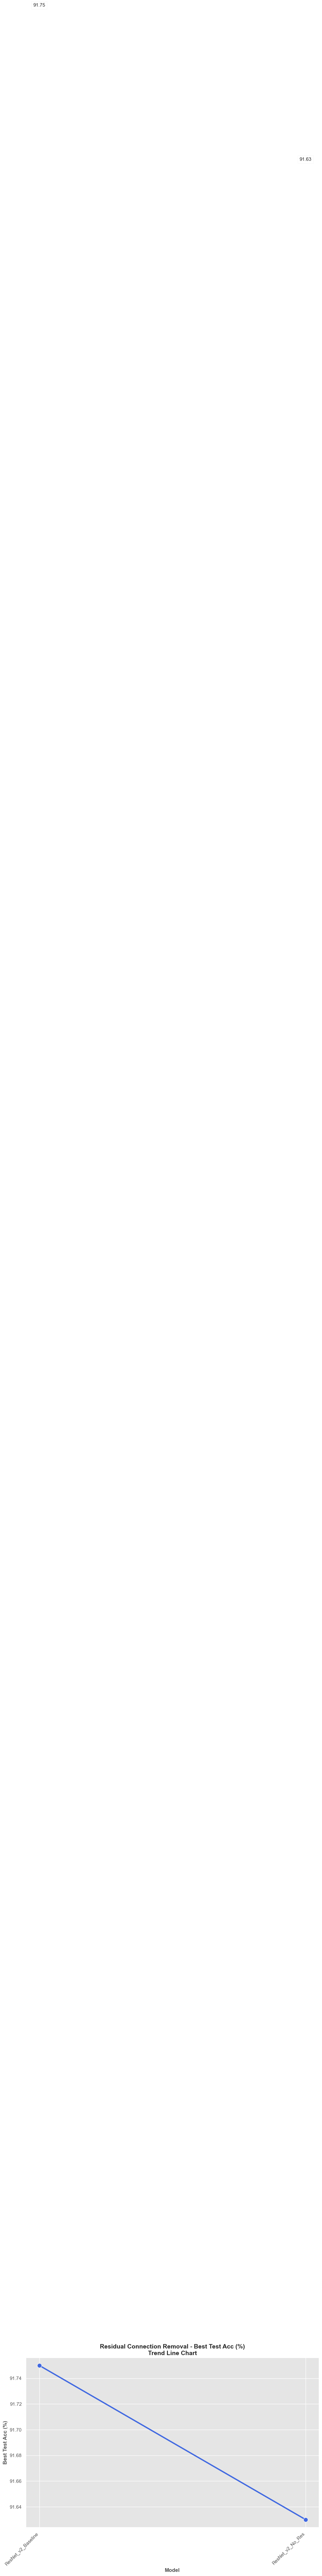

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


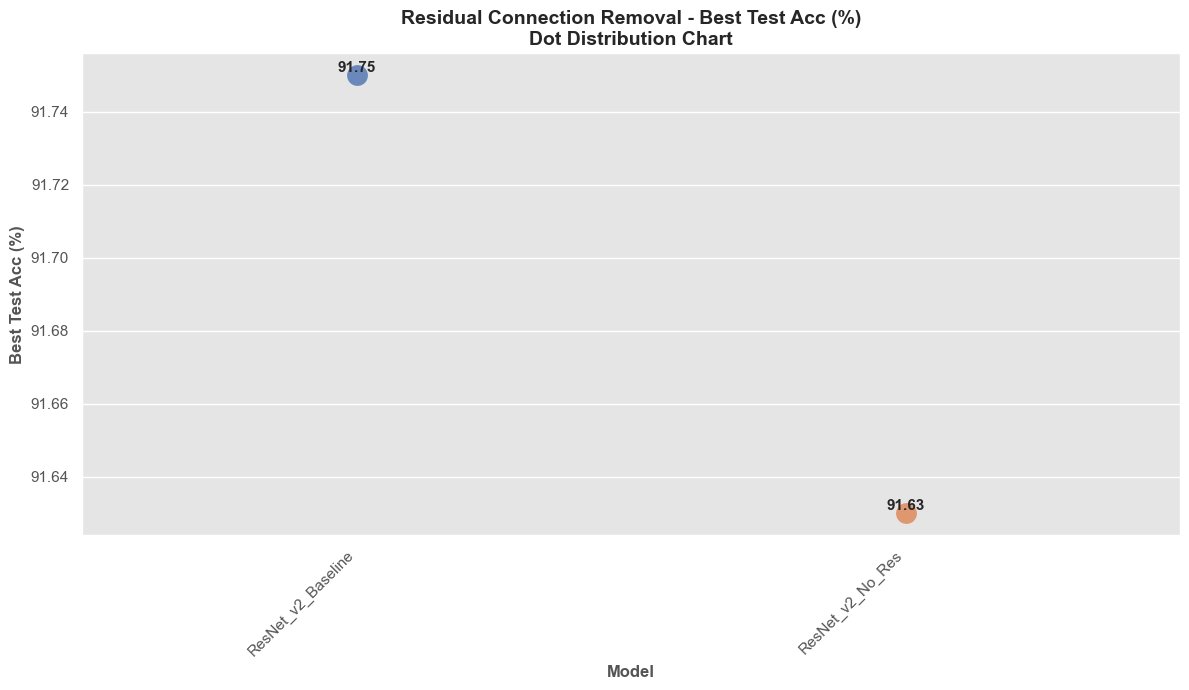

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


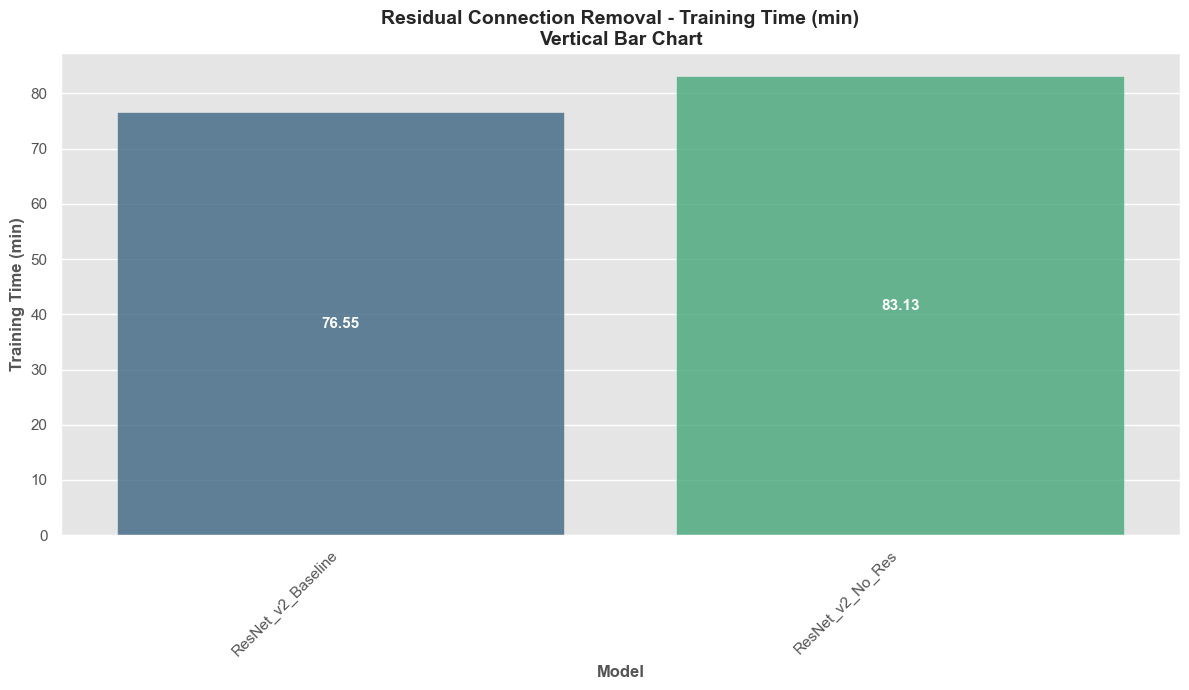

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


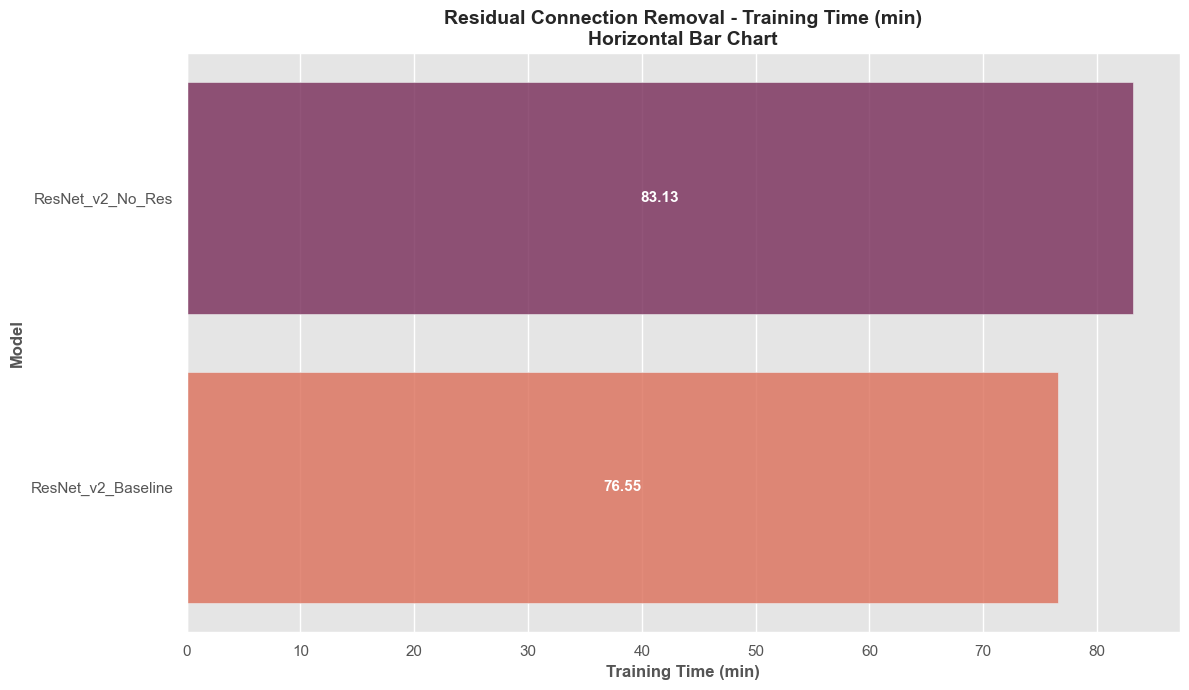

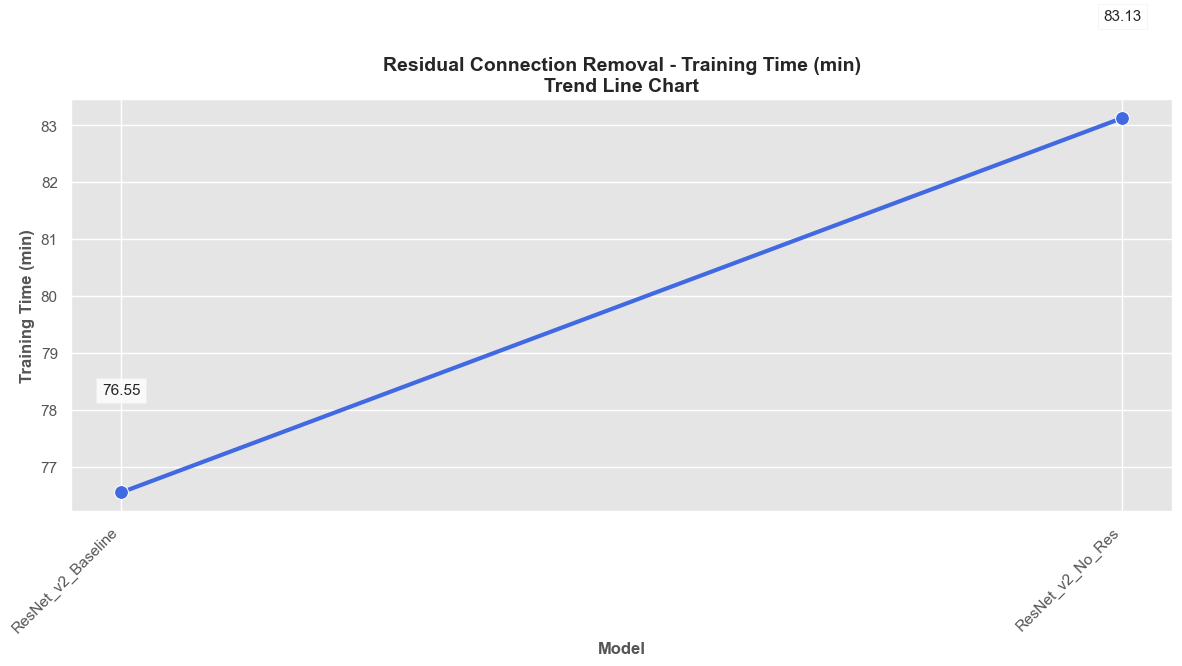

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


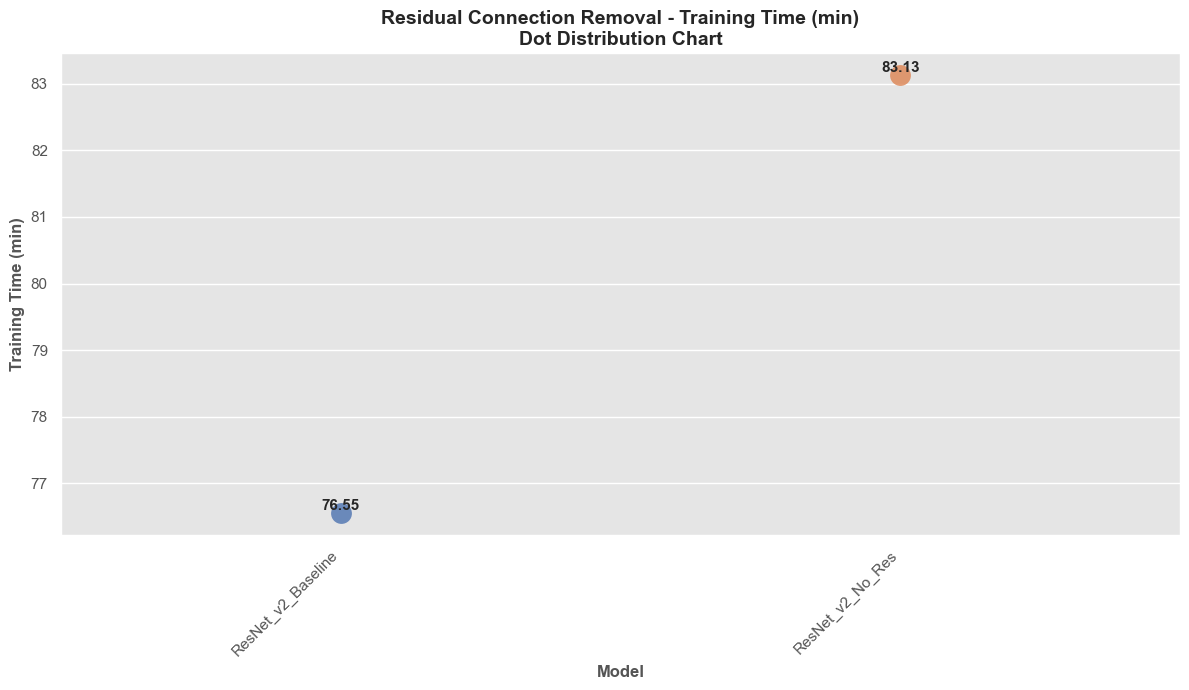

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


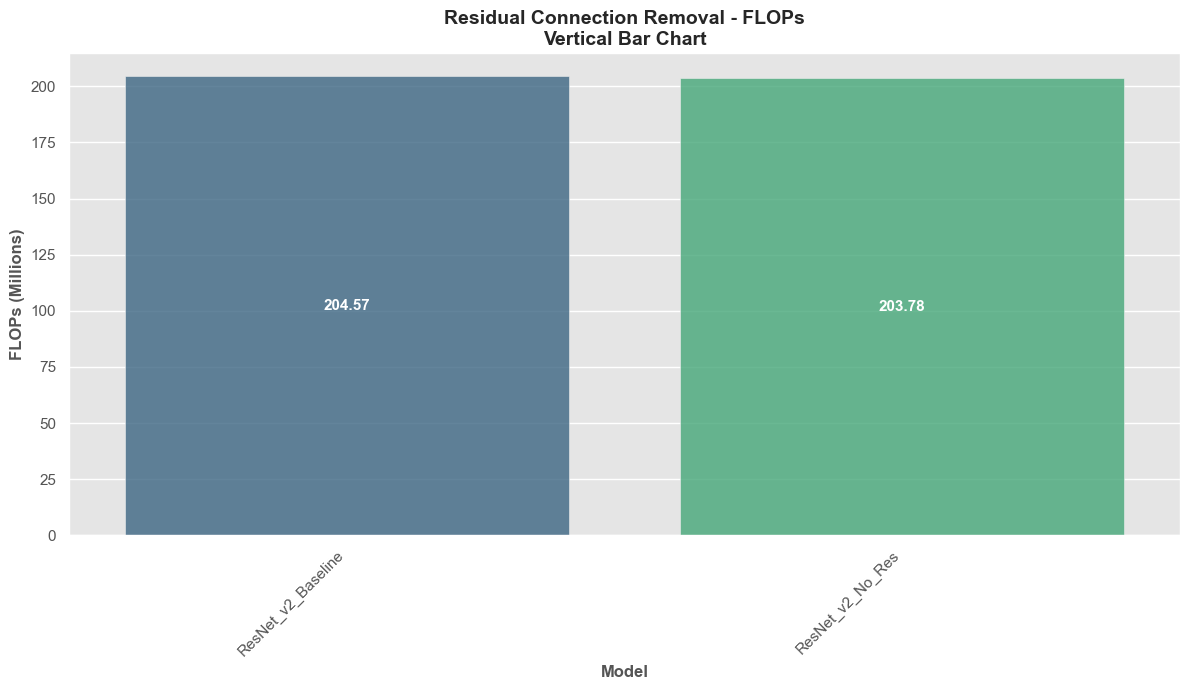

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


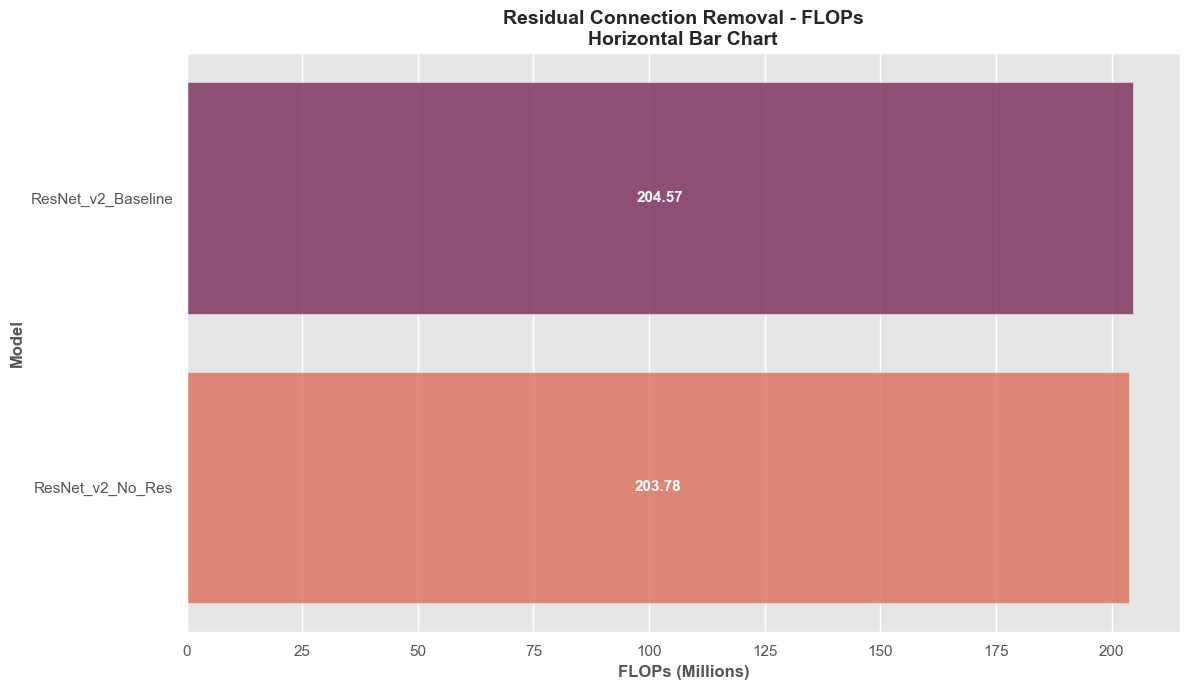

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:98: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


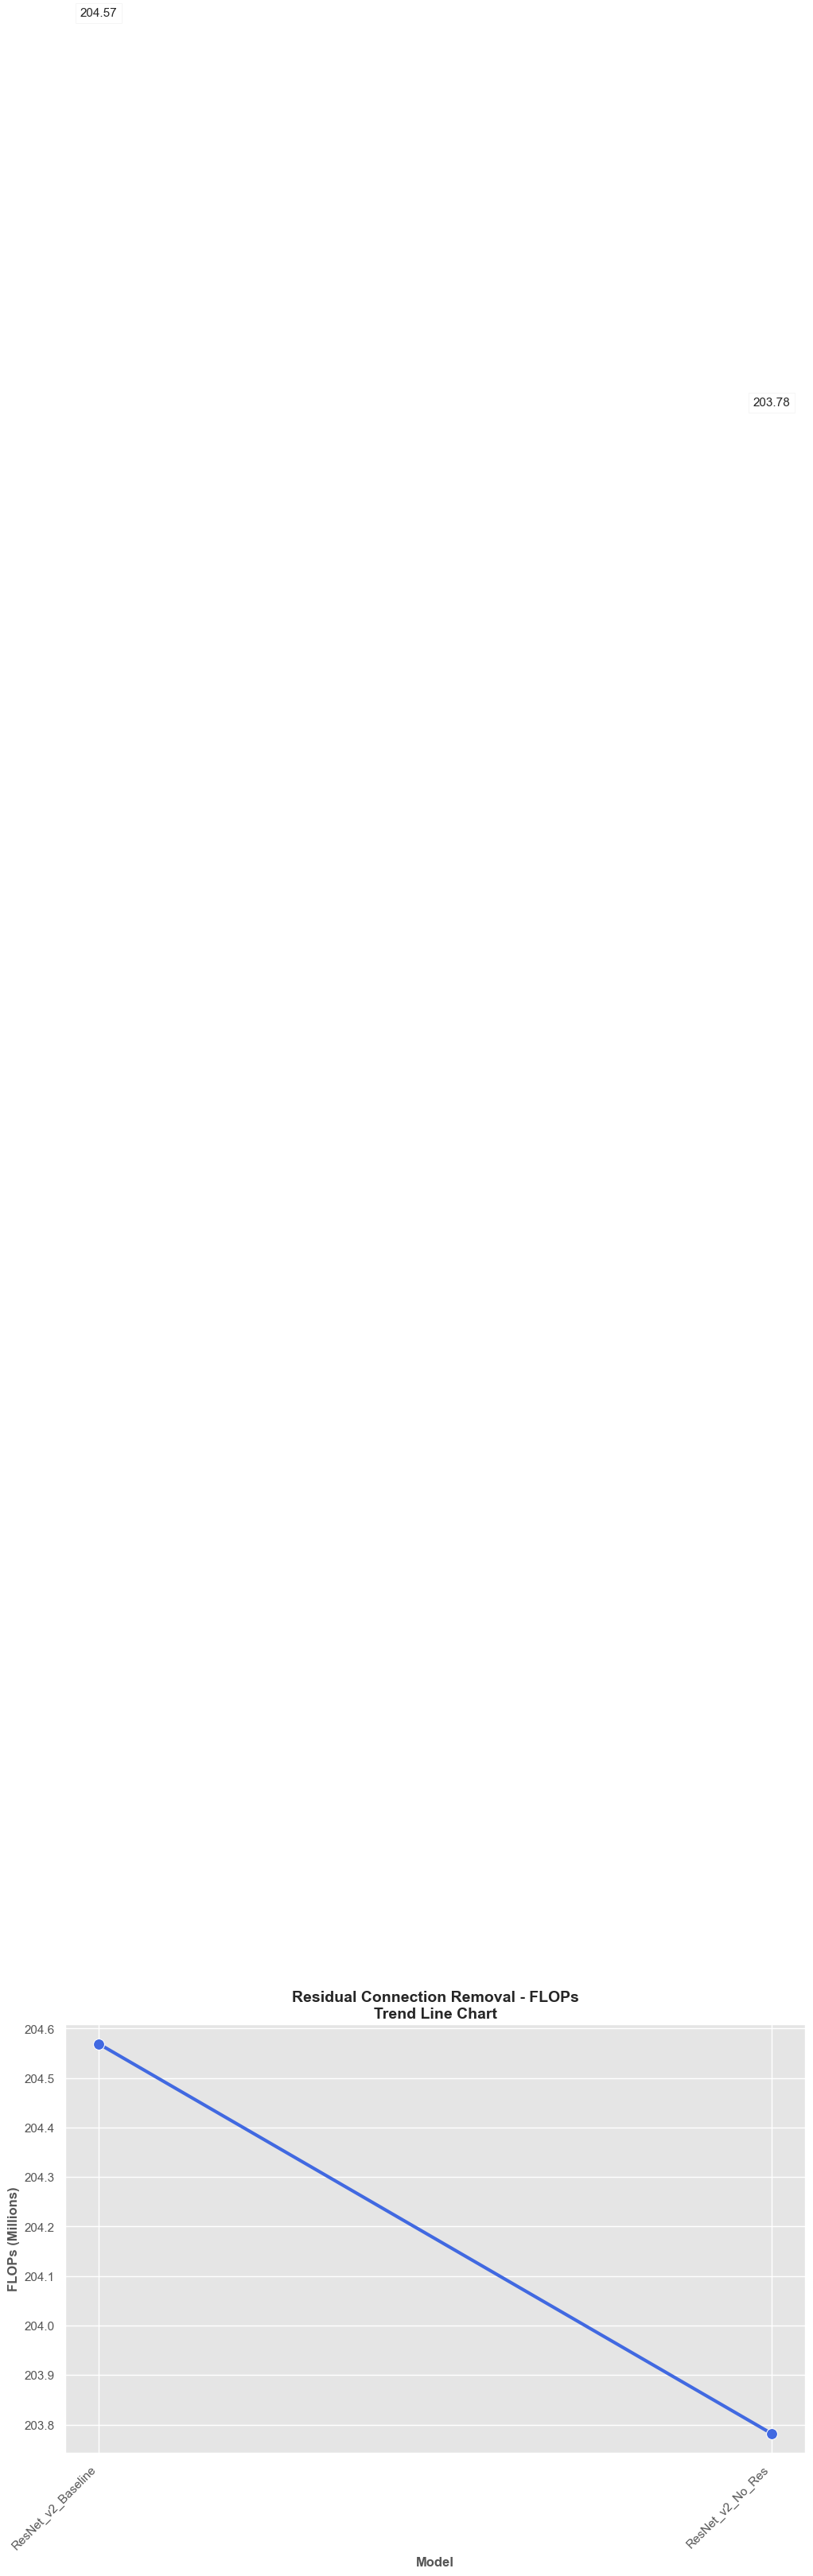

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


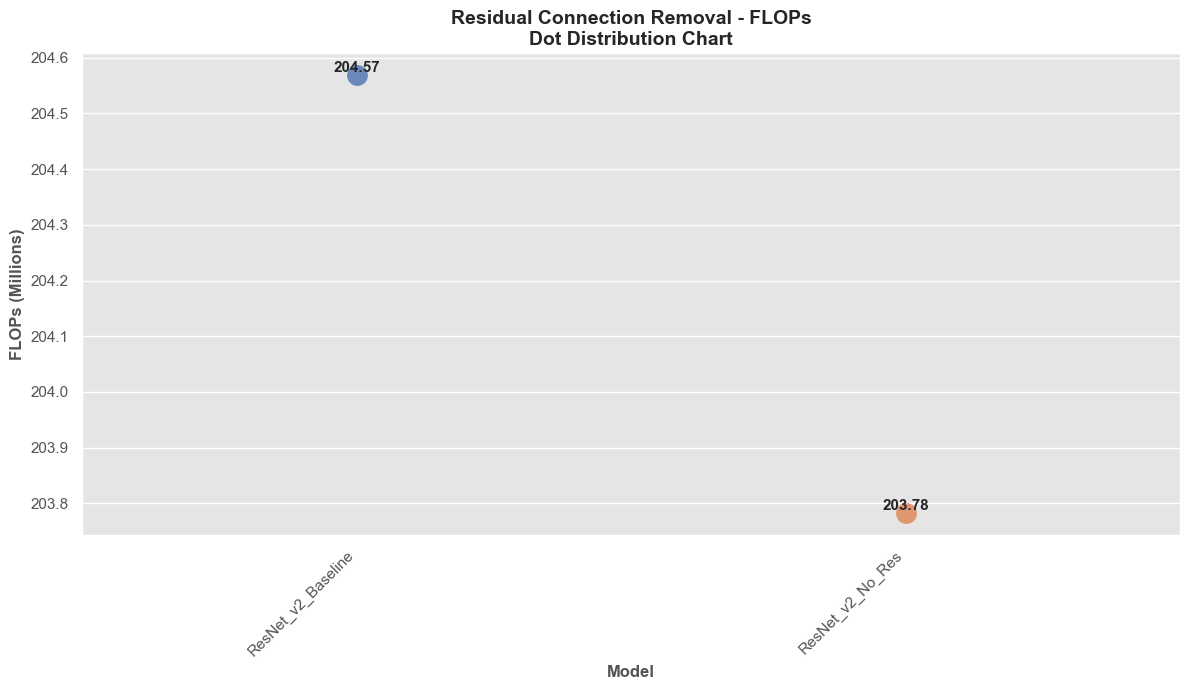

In [48]:
group_name = "Residual Connection Removal"
models = ["ResNet_v2_Baseline", "ResNet_v2_No_Res"]

for metric in ["Best Test Acc (%)", "Training Time (min)", "FLOPs"]:
    plot_multiple_styles(group_name, models, metric)


C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


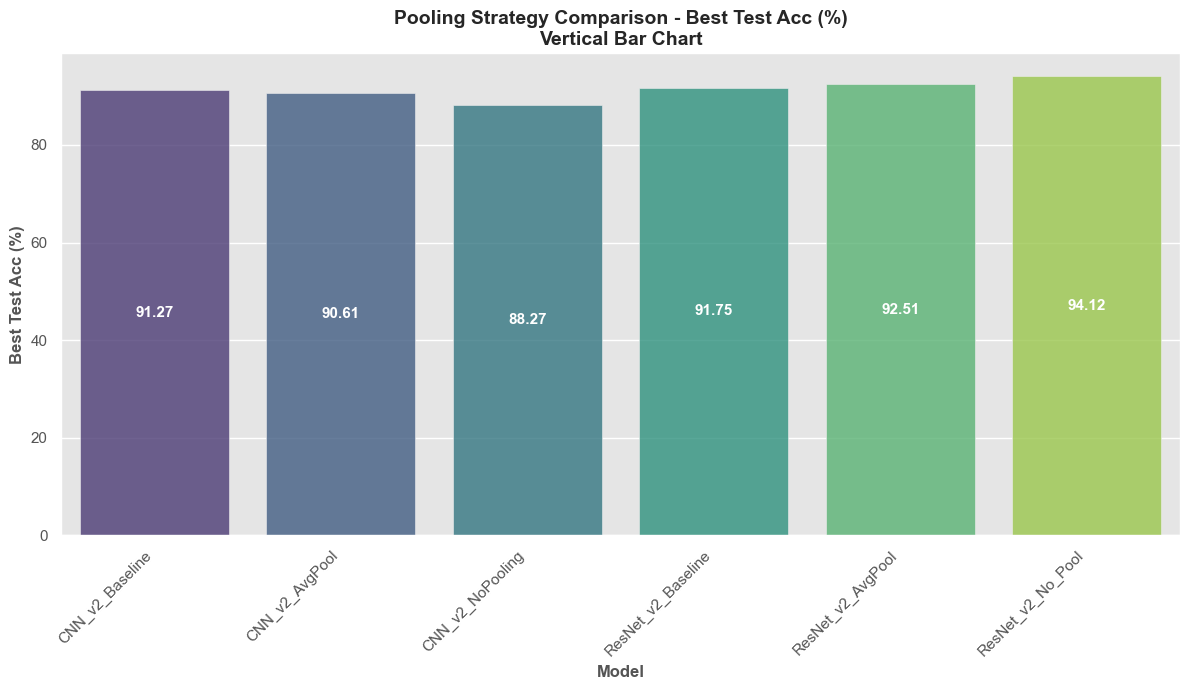

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


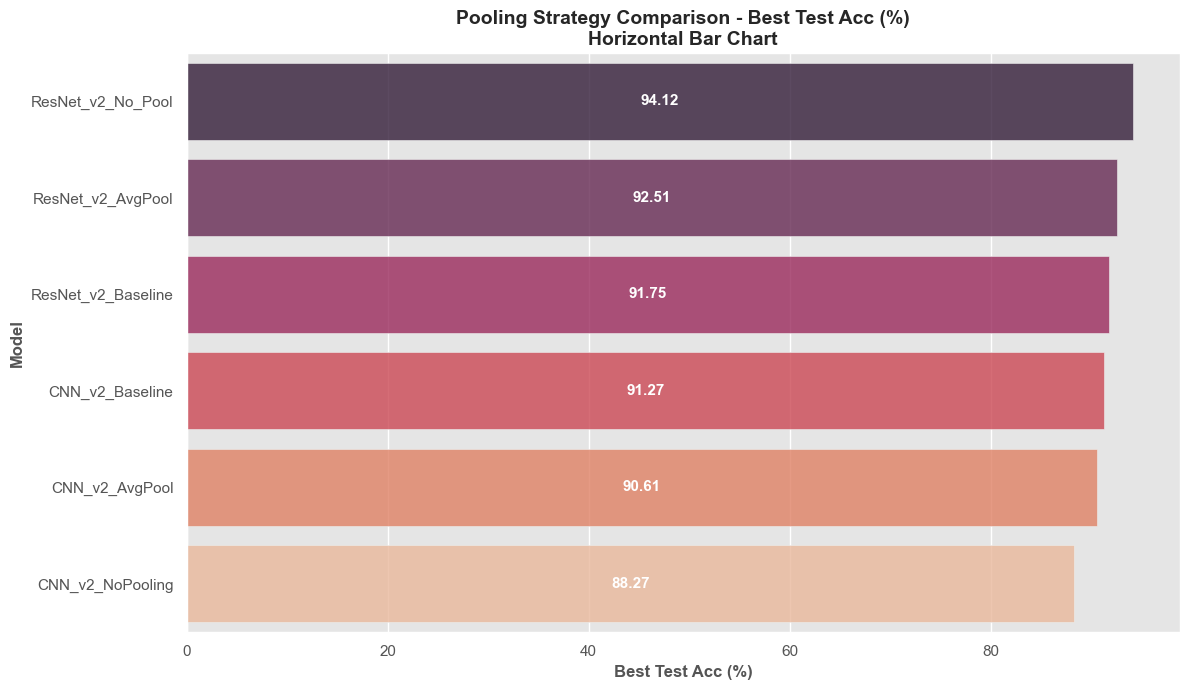

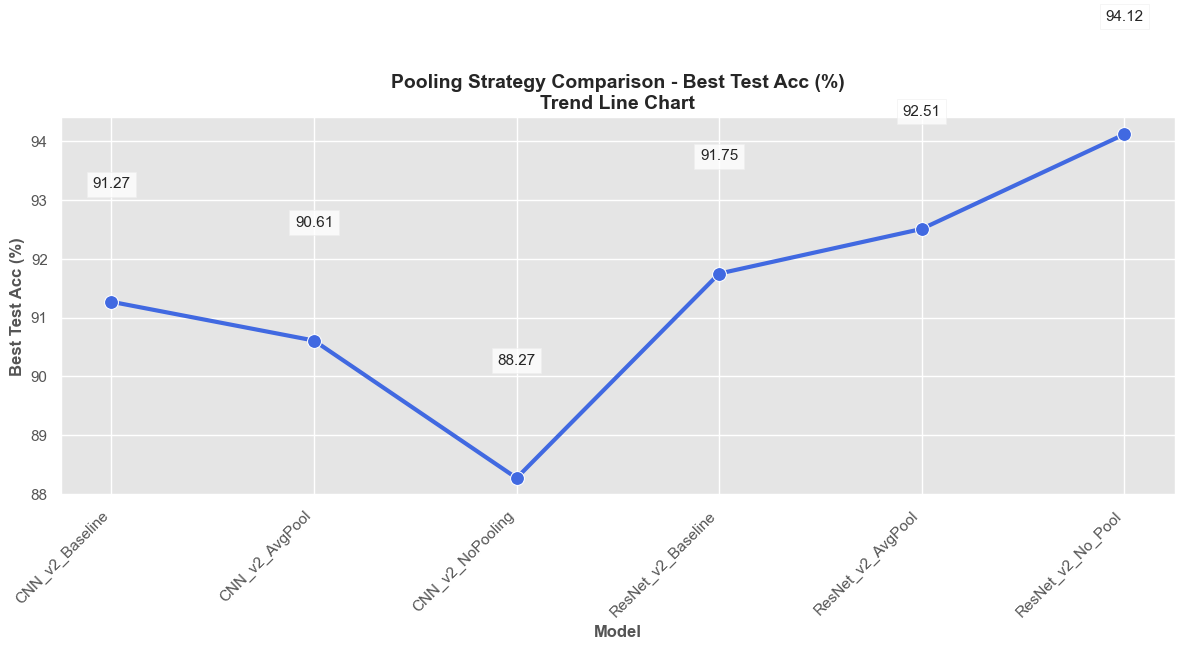

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


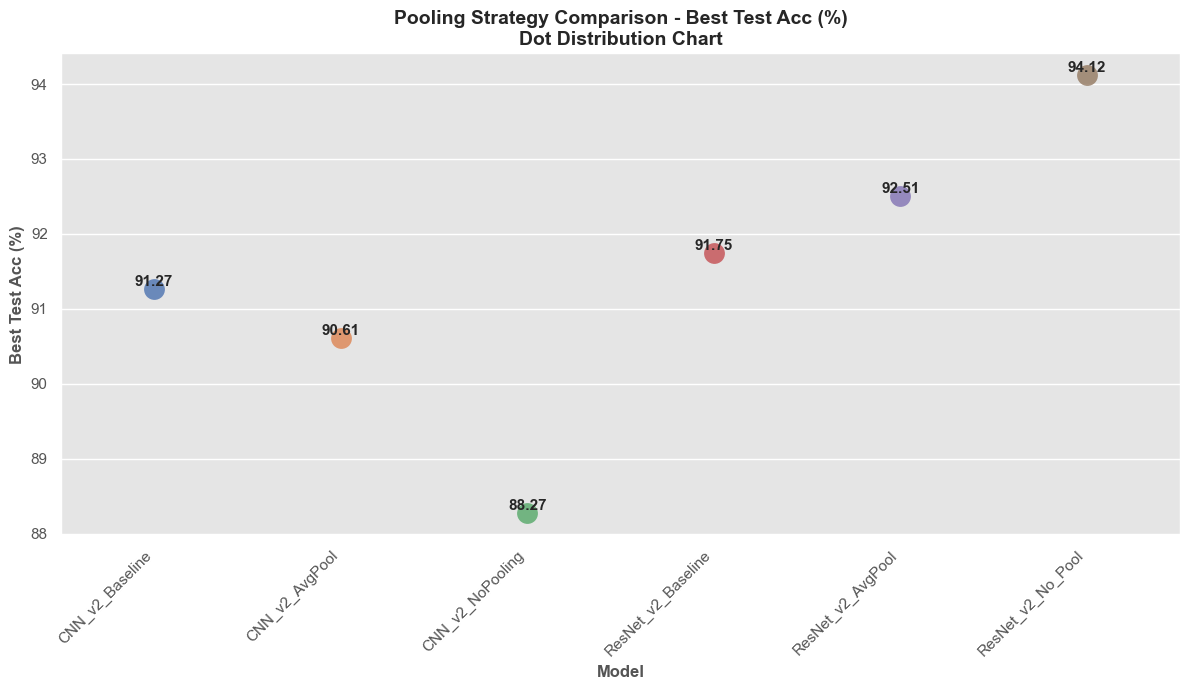

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


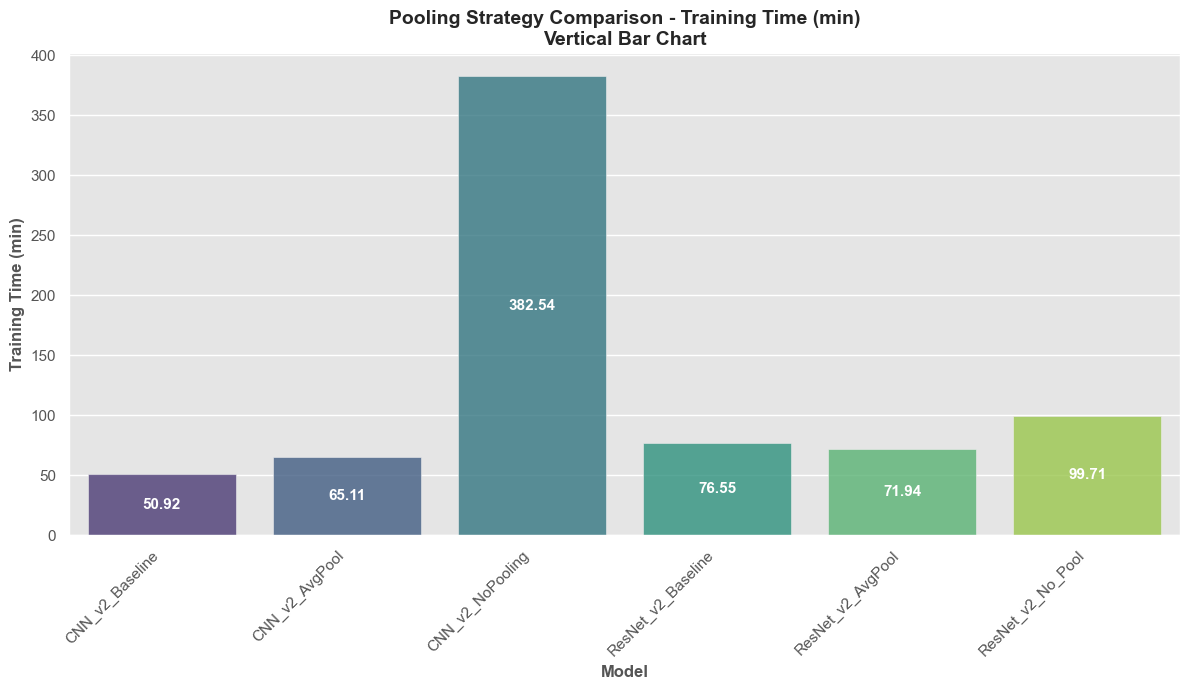

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


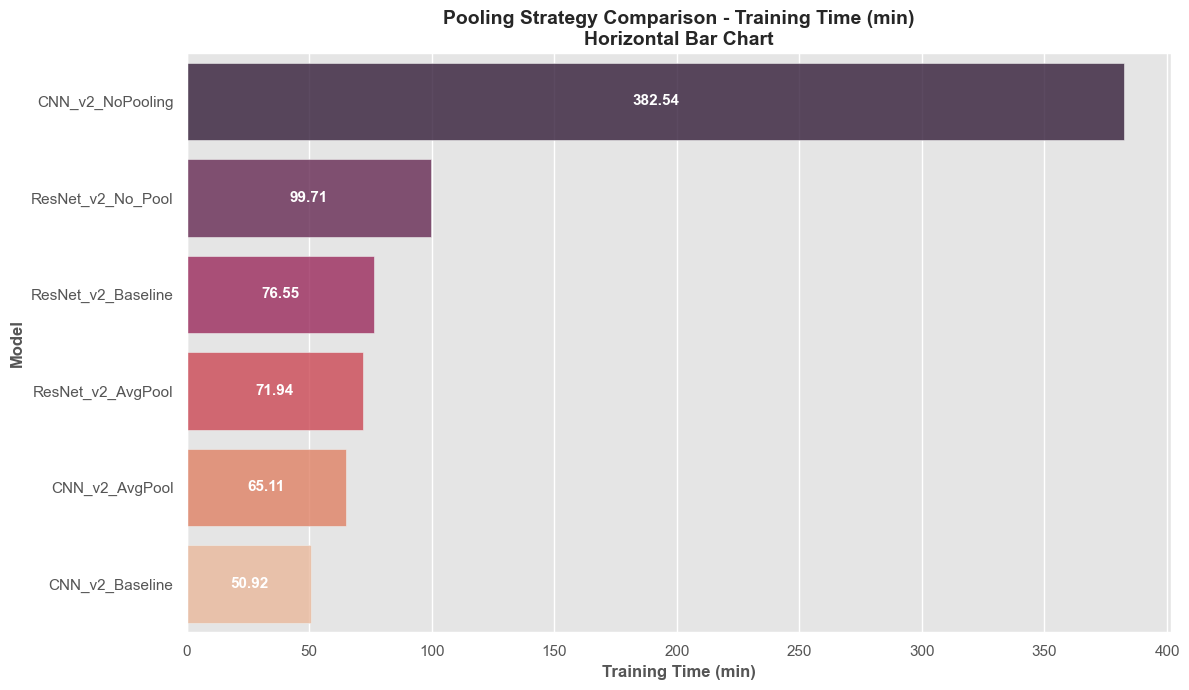

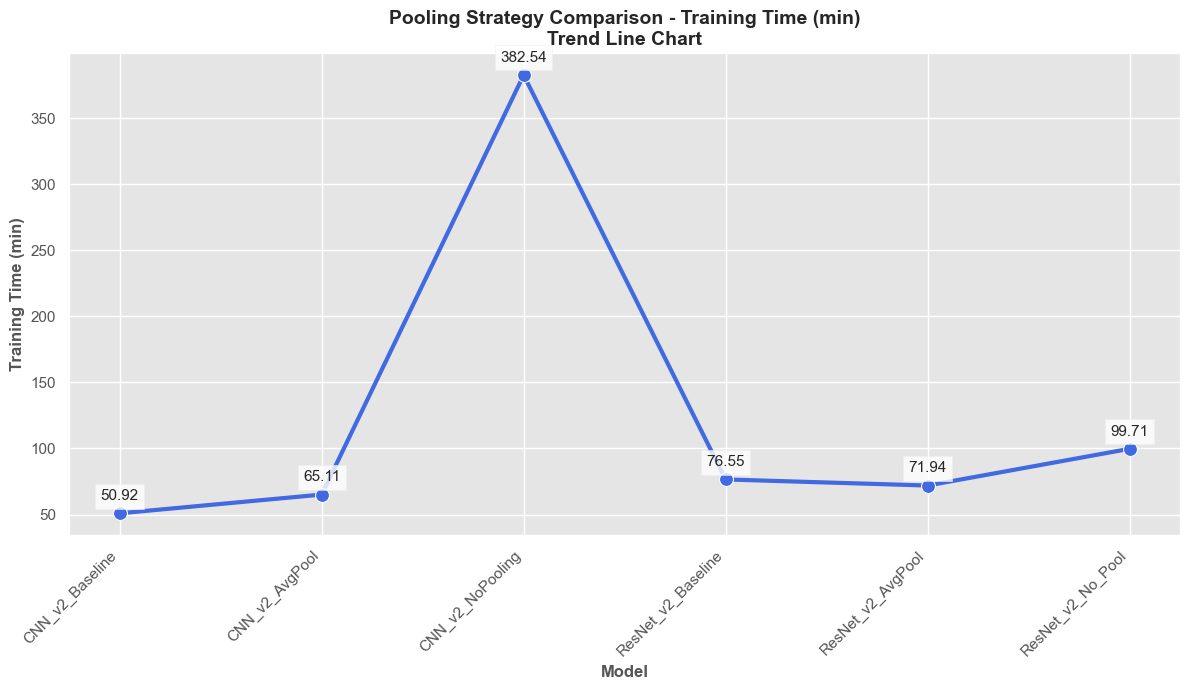

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


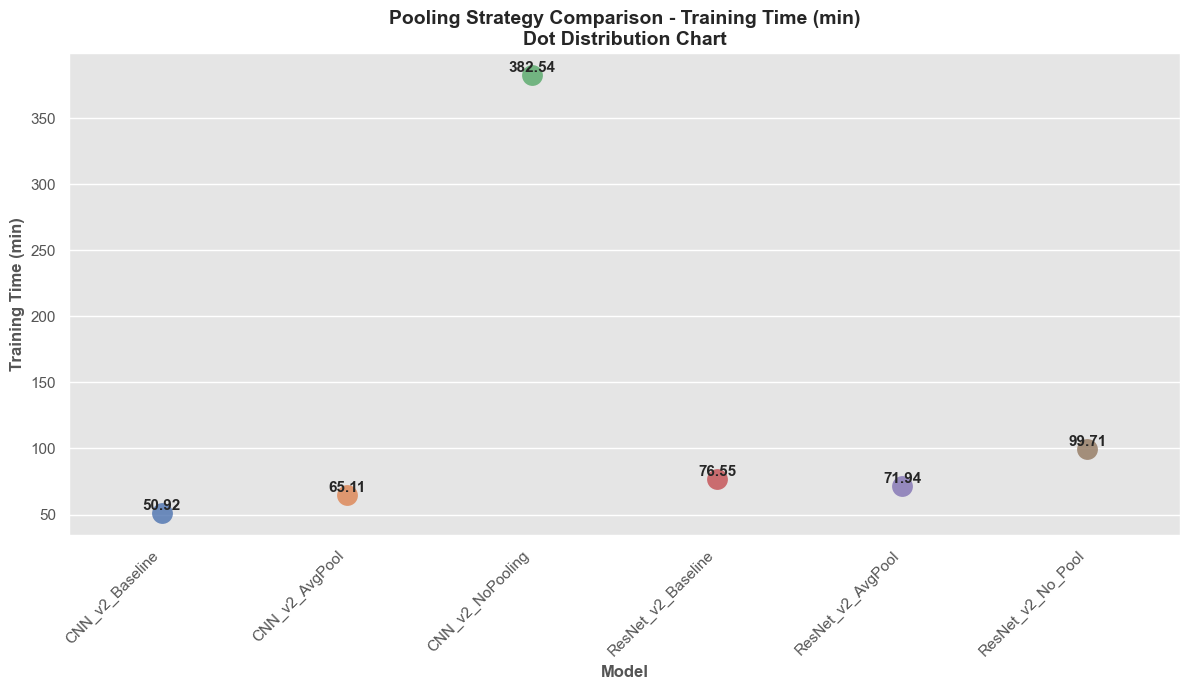

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


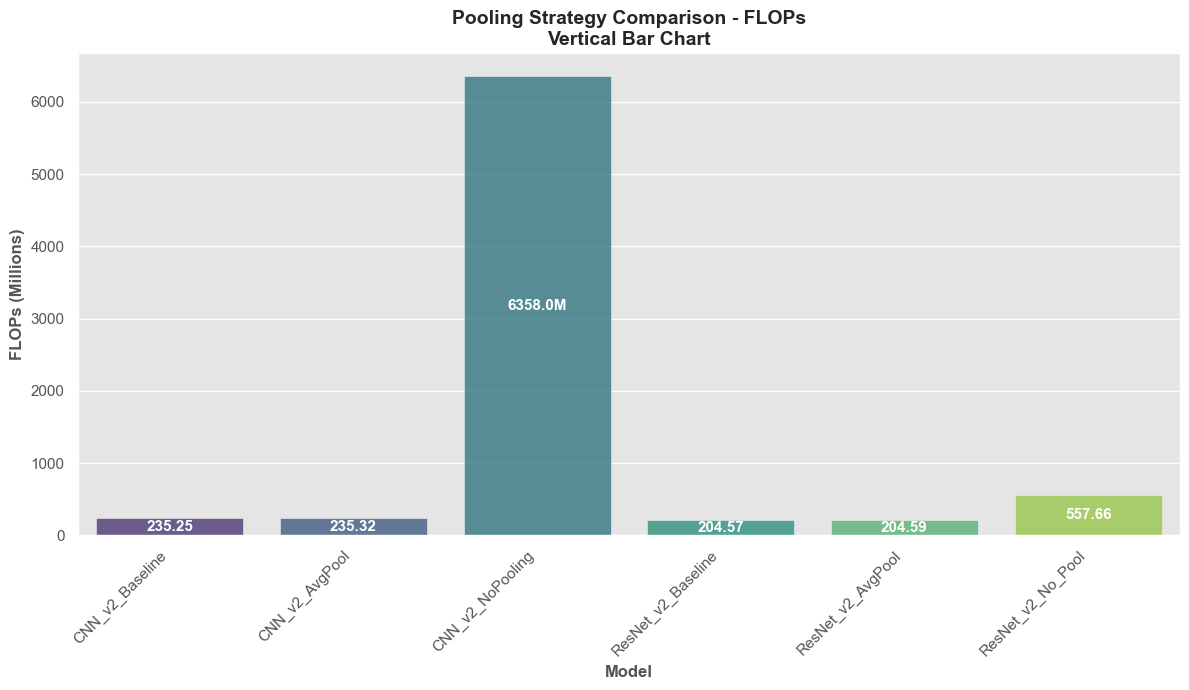

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


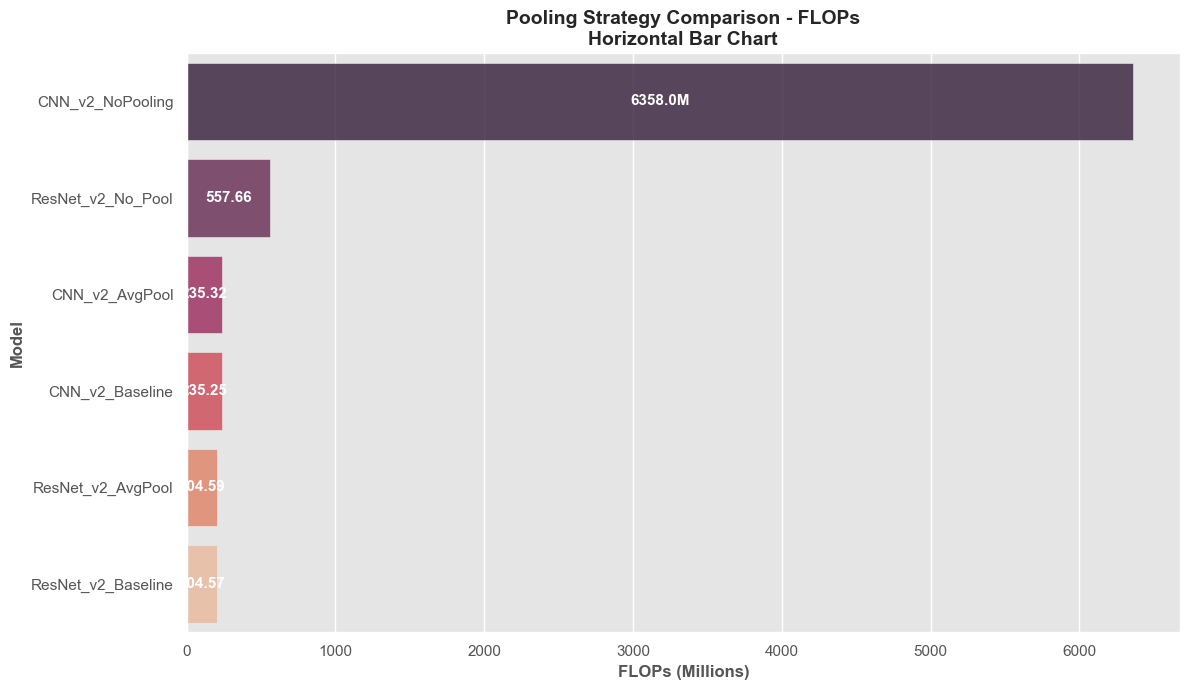

In [ ]:
group_name = "Pooling Strategy Comparison"
models = [
    "CNN_v2_Baseline", "CNN_v2_AvgPool", "CNN_v2_NoPooling",
    "ResNet_v2_Baseline", "ResNet_v2_AvgPool", "ResNet_v2_No_Pool"
]

for metric in ["Best Test Acc (%)", "Training Time (min)", "FLOPs"]:
    plot_multiple_styles(group_name, models, metric)


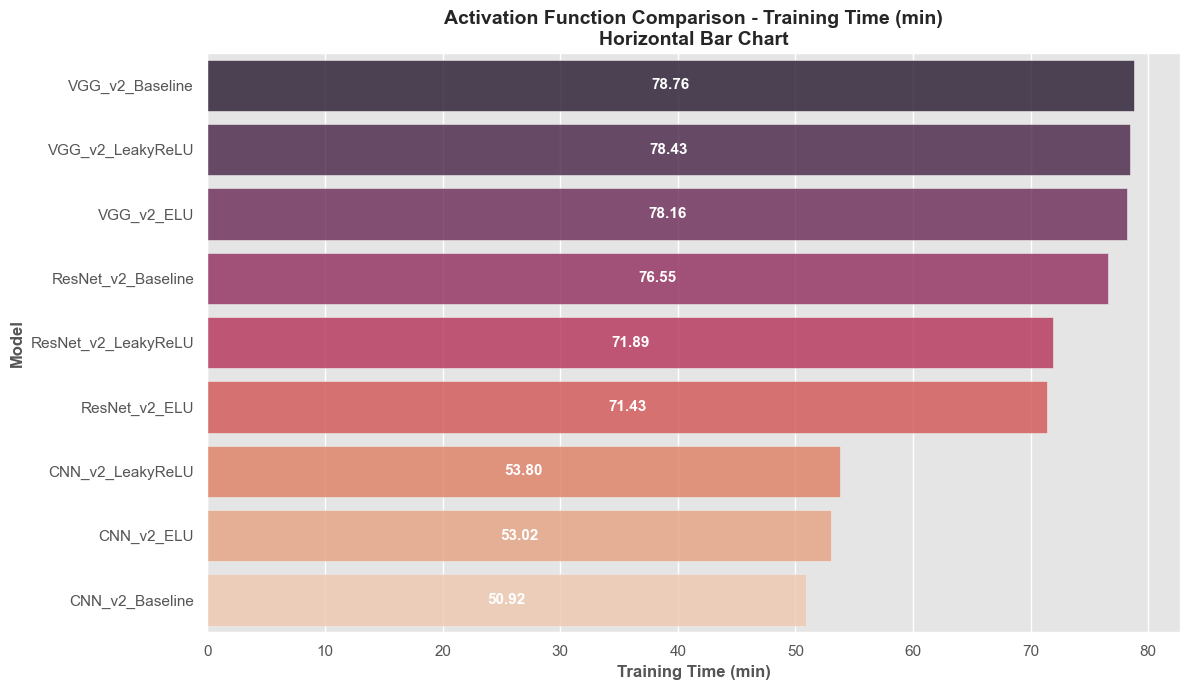

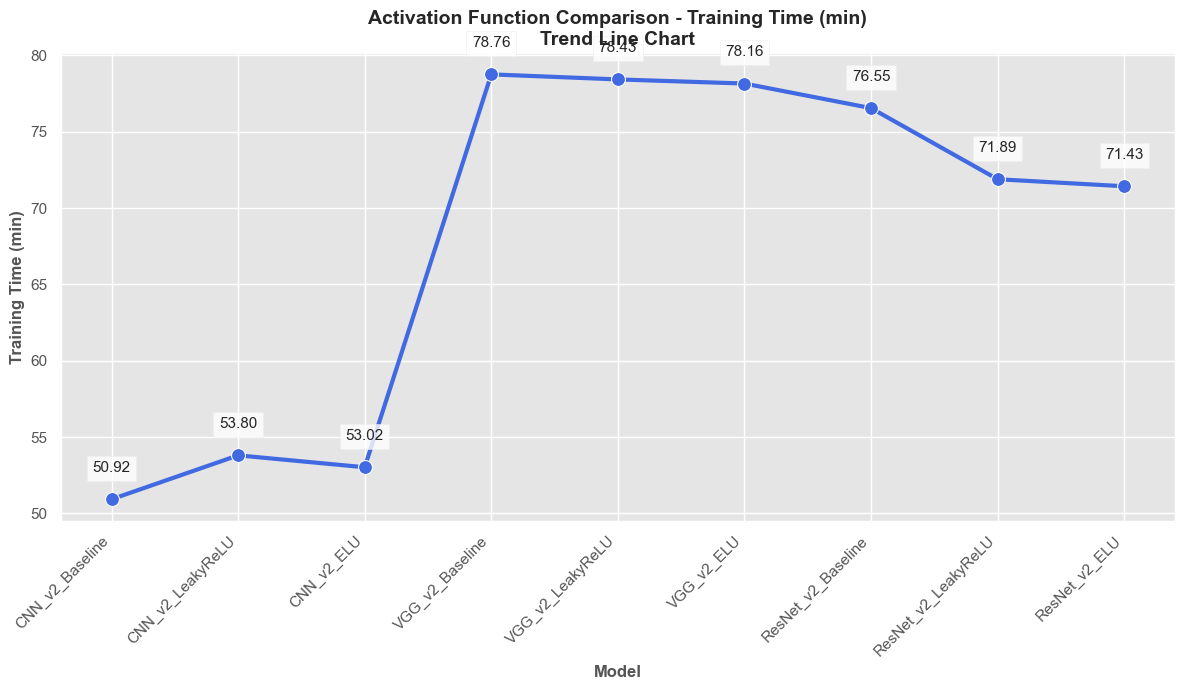

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


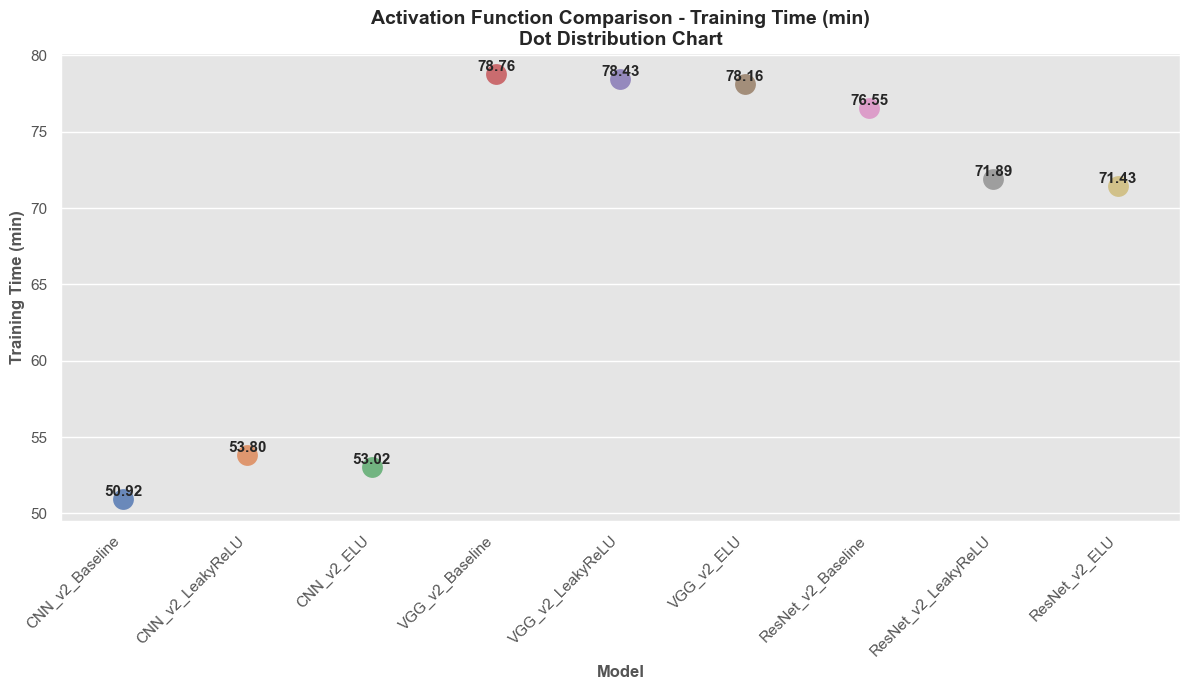

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=data.index, y=data[metric], palette="viridis", alpha=0.8)


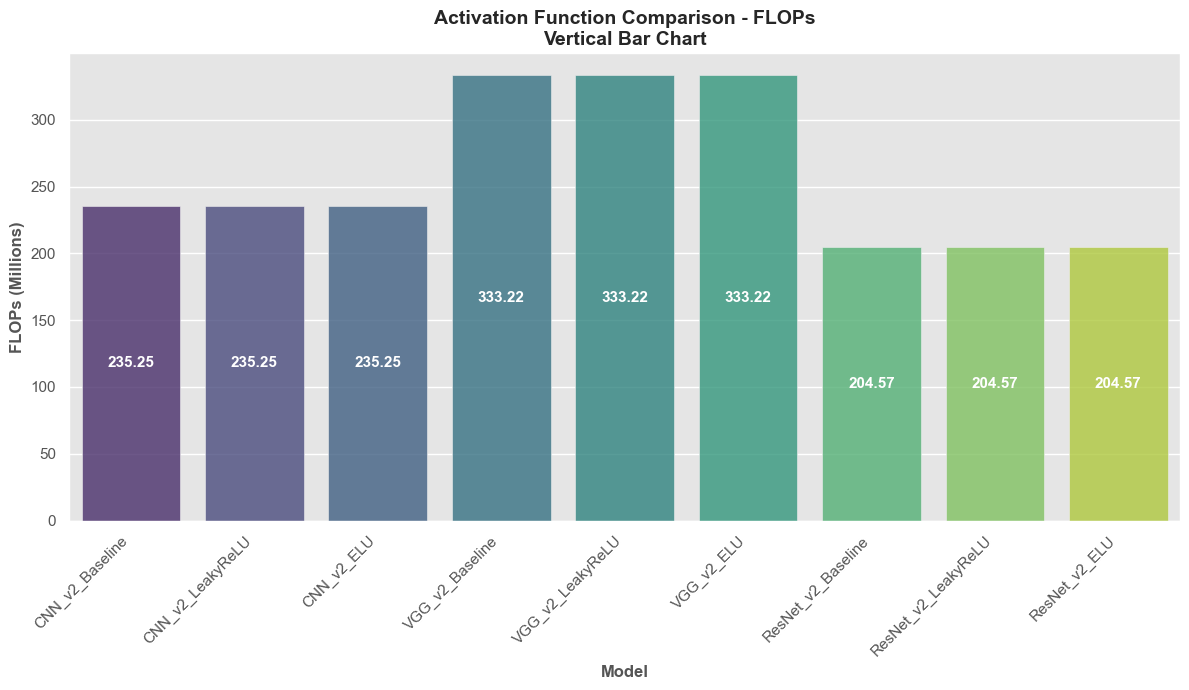

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=data_sorted.index, x=data_sorted[metric], palette="rocket", alpha=0.8)


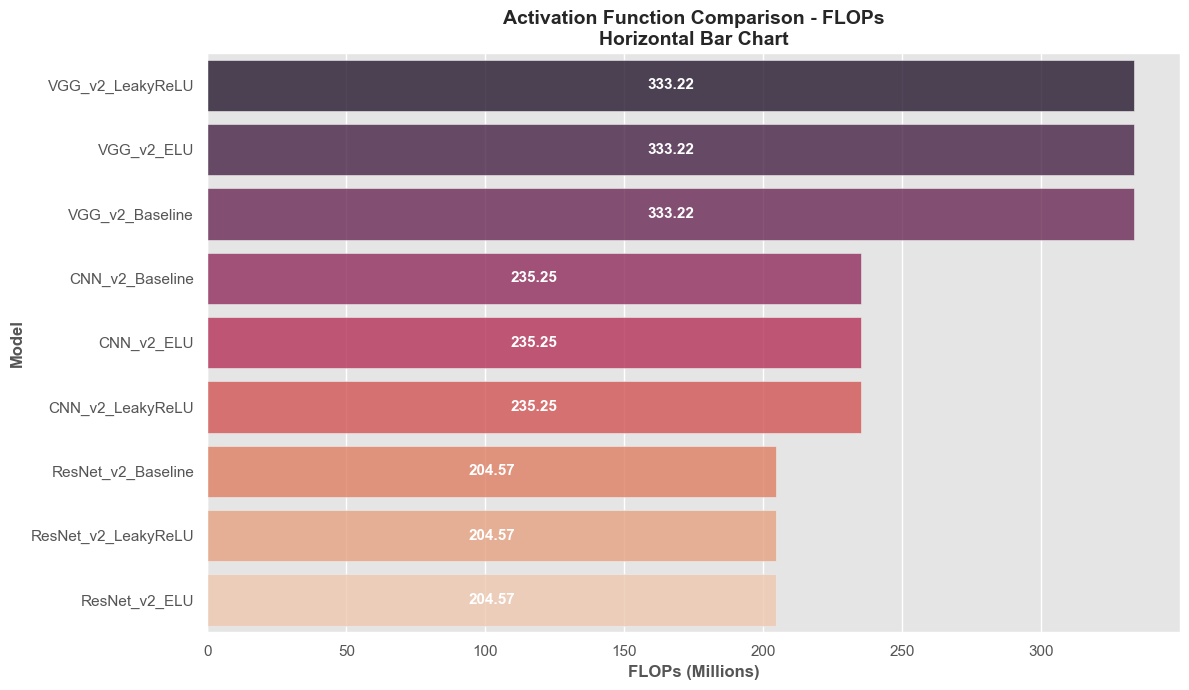

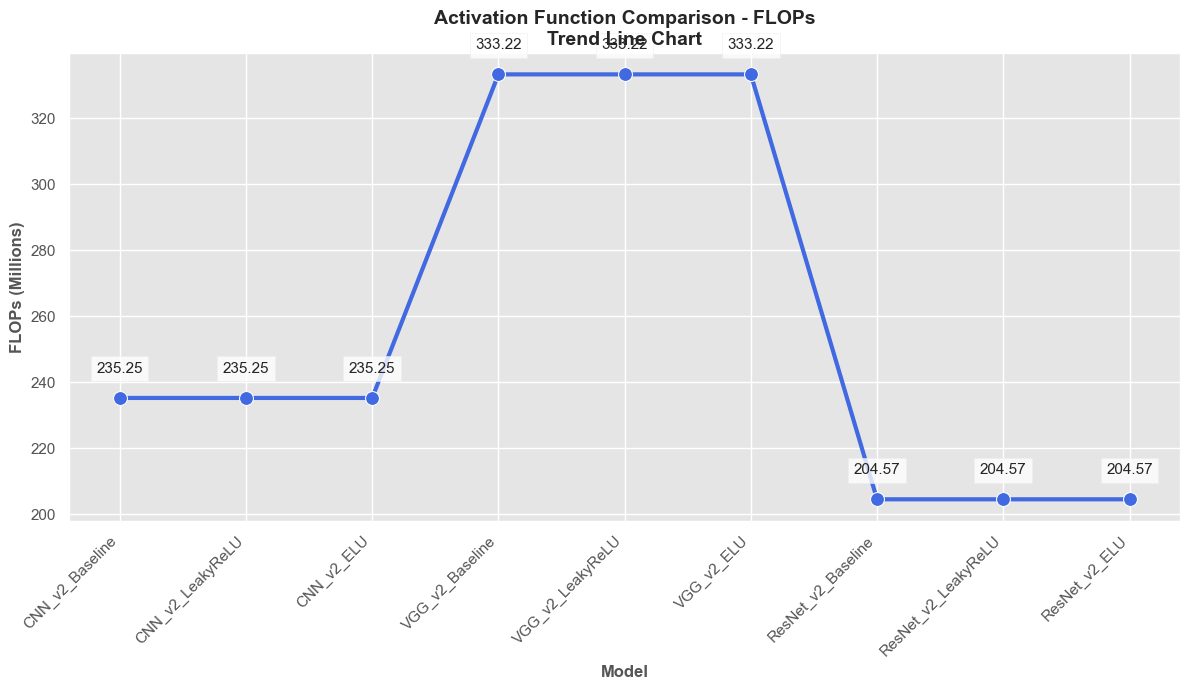

C:\Users\mo\AppData\Local\Temp\ipykernel_22200\1718939486.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.stripplot(x=data.index, y=data[metric],


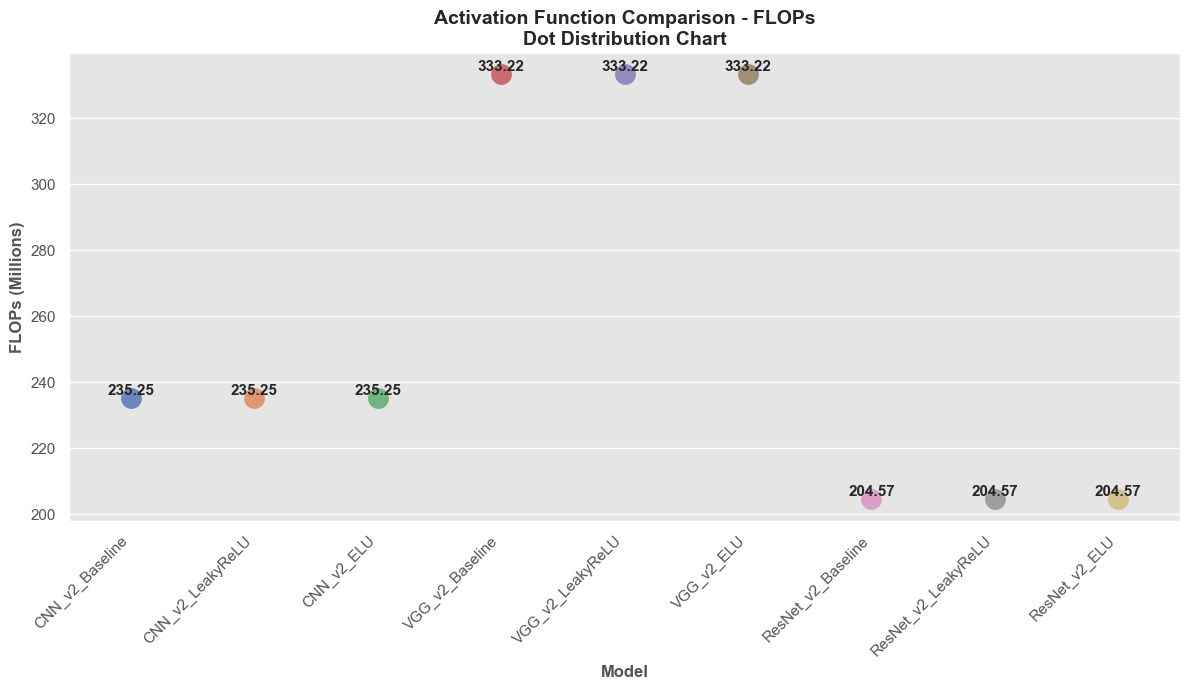

In [50]:
group_name = "Activation Function Comparison"
models = [
    "CNN_v2_Baseline", "CNN_v2_LeakyReLU", "CNN_v2_ELU",
    "VGG_v2_Baseline", "VGG_v2_LeakyReLU", "VGG_v2_ELU",
    "ResNet_v2_Baseline", "ResNet_v2_LeakyReLU", "ResNet_v2_ELU"
]

for metric in ["Best Test Acc (%)", "Training Time (min)", "FLOPs"]:
    plot_multiple_styles(group_name, models, metric)